In [1]:
import os
# os.environ['CUDA_VISIBLE_DEVICES'] = "1"
os.environ['TF_CPP_MIN_LOG_LEVEL'] = "2"
import re
import sys
from collections import Counter
from itertools import islice
from urllib.parse import urlparse, urlsplit, parse_qs, parse_qsl

import numpy as np
import parsel
from sklearn_crfsuite.metrics import flat_classification_report, sequence_accuracy_score

sys.path.insert(0, '..')
from autopager.storage import Storage
from autopager.htmlutils import (get_link_text, get_text_around_selector_list,
                                 get_link_href, get_selector_root)
from autopager.utils import (
    get_domain, normalize_whitespaces, normalize, ngrams, tokenize, ngrams_wb, replace_digits
)
from autopager.model import _num_tokens_feature, _elem_attr
from autopager import AUTOPAGER_LIMITS
from autopager.parserutils import (TagParser, MyHTMLParser, draw_scaled_page, position_check, compare_tag, get_first_tag)
parser = MyHTMLParser()
tagParser = TagParser()

In [2]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.sequence import pad_sequences
import random
tf.random.set_seed(0)
random.seed(0)
np.random.seed(0)

In [3]:
from ipywidgets import IntProgress
from IPython.display import display


In [4]:
storage = Storage()

Current test file:  ['en', 'zh', 'ko', 'ja', 'de', 'ru']


In [5]:
gpus = tf.config.experimental.list_physical_devices('GPU')

In [6]:
gpus

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'),
 PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU')]

In [93]:
USED_GPU = 1

In [8]:
for device in gpus:
    tf.config.experimental.set_memory_growth(device, True)

In [9]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if len(gpus)!=0:
  # Restrict TensorFlow to only use the first GPU
    try:
        tf.config.experimental.set_visible_devices(gpus[USED_GPU], 'GPU')
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPU")
    except RuntimeError as e:
    # Visible devices must be set before GPUs have been initialized
        print(e)
else:
    print("No GPUs visible")

2 Physical GPUs, 1 Logical GPU


In [10]:
%%time
urls = [rec['Page URL'] for rec in storage.iter_records(language='en',contain_button = True, file_type='T')]
X_raw, y, page_positions = storage.get_Xy(language='en',contain_button = True,  contain_position=True,file_type='T', scaled_page='normal')
print("pages: {}  domains: {}".format(len(urls), len({get_domain(url) for url in urls})))

pages: 164  domains: 55
CPU times: user 3.88 s, sys: 21.2 ms, total: 3.91 s
Wall time: 3.91 s


In [11]:
max_page_seq = 512

In [12]:
from tensorflow.keras import Model
from tensorflow.data import Dataset

In [13]:
import copy

## Slice data into chunks

In [14]:
def filter_empty(x, y):
    res_x = [page for page in x if len(x)!= 0]
    res_y = [page for page in y if len(y)!= 0]
    return x, y

In [15]:
chunks_x, chunks_y, chunk_positions = X_raw, y, page_positions

In [16]:
chunks_x, chunks_y = filter_empty(chunks_x, chunks_y)

## Load Pre-trained Fastext model

## Load Pre-trained Laser embedding

In [17]:
from LaserSentenceModel import LaserSentenceModel

In [18]:
laser = LaserSentenceModel()

In [19]:
laser.getSentenceVector('hello').shape

(1024,)

In [22]:
def textToMultiVector(text):
    ngram_next = _as_list(ngrams_wb(replace_digits(text), 2, 5),AUTOPAGER_LIMITS.max_text_features)
    return np.average(laser.getSentenceVector(ngram_next), axis = 0)

# Load Pre-trained Bert embedding

# Feature extraction

In [20]:
%%time
# XXX: these functions should be copy-pasted from autopager/model.py

def _as_list(generator, limit=None):
    """
    >>> _as_list(ngrams_wb("text", 2, 2), 0)
    []
    >>> _as_list(ngrams_wb("text", 2, 2), 2)
    ['te', 'ex']
    >>> _as_list(ngrams_wb("text", 2, 2))
    ['te', 'ex', 'xt']
    """
    return list(generator if limit is None else islice(generator, 0, limit))

def feat_to_tokens(feat, tokenizer):
    if type(feat) == type([]):
        feat = ' '.join(feat)
    tokens = tokenizer.tokenize(feat)
    return tokens

def num_token_feature_to_class(number):
    if number == '=0':
        return [1, 0, 0, 0]
    elif number == '=1':
        return [0, 1, 0, 0]
    elif number == '=2':
        return [0, 0, 1, 0]
    else:
        return [0, 0, 0, 1]

def link_to_features(link):
    text = normalize(get_link_text(link))
    href = get_link_href(link)
    if href is None:
        href = ""
    p = urlsplit(href)
    parent = link.xpath('..').extract()
    parent = get_first_tag(parser, parent[0])
    query_parsed = parse_qsl(p.query) #parse query string from path
    query_param_names = [k.lower() for k, v in query_parsed]
    query_param_names_ngrams = _as_list(ngrams_wb(
        " ".join([normalize(name) for name in query_param_names]), 3, 5, True
    ))

    # Classes of link itself and all its children.
    # It is common to have e.g. span elements with fontawesome
    # arrow icon classes inside <a> links.
    self_and_children_classes = ' '.join(link.xpath(".//@class").extract())
    parent_classes = ' '.join(link.xpath('../@class').extract())
    css_classes = normalize(parent_classes + ' ' + self_and_children_classes)
    
    token_feature = {
        'text-exact': replace_digits(text.strip()[:100].strip()),
#         'query': query_param_names,
        'query': query_param_names_ngrams,
        'parent-tag': parent,
#         'class': css_classes.split()[:AUTOPAGER_LIMITS.max_css_features],
        'class':_as_list(ngrams_wb(css_classes, 4, 5),
                          AUTOPAGER_LIMITS.max_css_features),
        'text': _as_list(ngrams_wb(replace_digits(text), 2, 5),
                         AUTOPAGER_LIMITS.max_text_features),
    }
    tag_feature = {
        'isdigit': 1 if text.isdigit() is True else 0,
        'isalpha': 1 if text.isalpha() is True else 0,
        'has-href': 0 if href is "" else 1,
        'path-has-page': 1 if 'page' in p.path.lower() else 0,
        'path-has-pageXX': 1 if re.search(r'[/-](?:p|page\w?)/?\d+', p.path.lower()) is not None else 0,
        'path-has-number': 1 if any(part.isdigit() for part in p.path.split('/')) else 0,
        'href-has-year': 1 if re.search('20\d\d', href) is not None else 0,
        'class-has-disabled': 1 if 'disabled' in css_classes else 0,
#         'num-tokens': num_token_feature_to_class(_num_tokens_feature(text)),
    }
    non_token_feature = []
    for k,v in tag_feature.items():
        if type(v) == type([]):
            non_token_feature.extend(v)
        else:
            non_token_feature.append(v)

    return [token_feature, non_token_feature]


def page_to_features(xseq):
    feat_list = [link_to_features(a) for a in xseq]
    around = get_text_around_selector_list(xseq, max_length=15)
#     print(len(feat_list))
    for feat, (before, after) in zip(feat_list, around):
        feat[0]['text-full'] = normalize(before) + ',' + feat[0]['text-exact'] + ',' + normalize(after)
    
    return feat_list

CPU times: user 9 µs, sys: 0 ns, total: 9 µs
Wall time: 17.2 µs


In [21]:
def get_token_tag_features_from_chunks(chunks):
    token_features = []
    tag_features = []
    for idx, page in enumerate(chunks):
        try:
            feat_list = page_to_features(page)
            token_features.append([node[0] for node in feat_list])
            tag_features.append(np.array([node[1] for node in feat_list]))
        except:
            raise Exception(f"Error occured on {idx}")
    return token_features, tag_features

In [22]:
def word_to_vector(word_list, word_vector_method = None):
    if word_vector_method is None:
        print("Need to specified a method.")
        return
    elif word_vector_method == 'FastText':
        if type(word_list) == type([]):
            if len(word_list) == 0:
                return np.zeros(ft.getModel().get_dimension())
            else:
                vectors_array = []
                for word in word_list:
                    vector = ft.getWordVector(word)
                    vectors_array.append(vector)
                mean_vector = np.mean(vectors_array, axis = 0)
                return mean_vector
        else:
            return ft.getWordVector(word_list)
    elif word_vector_method == 'Laser':
        return laser.getSentenceVector(word_list)

In [23]:
def pages_to_word_vector(ft, token_features):
    pages_vector = []
    for page in token_features:
        page_vectors = []
        for node in page:
            classes = word_to_vector(ft, node['class'])
            query = word_to_vector(ft, node['query'])
            p_tag = word_to_vector(ft, node['parent-tag'])
            full_vector = np.concatenate([classes, query, p_tag], axis = 0)
            page_vectors.append(full_vector)
        pages_vector.append(np.array(page_vectors))
    return pages_vector

In [24]:
token_features, tag_features = get_token_tag_features_from_chunks(chunks_x)
# train_tag_feature_token_list = extract_tokens_from_token_features(token_features)

In [94]:
token_features[0][0]

{'text-exact': '',
 'query': [],
 'parent-tag': 'li',
 'class': ['bran', 'rand', 'brand'],
 'text': [],
 'text-full': 'noscript) head,,'}

In [105]:
class_set = set()
query_set = set()
class_counter = dict()
query_counter = dict()
for page in token_features:
    for node in page:
        for class_name in node['class']:
            if class_name not in class_set:
                if str(len(class_name)) not in class_counter:
                    class_counter[str(len(class_name))] = 1
                else:
                    if class_name not in class_set:
                        class_counter[str(len(class_name))] += 1
                class_set.add(class_name)
        for query_name in node['query']:
            if query_name not in query_set:
                if str(len(query_name)) not in query_counter:
                    query_counter[str(len(query_name))] = 1
                else:
                    query_counter[str(len(query_name))] += 1
                query_set.add(query_name)

In [106]:
len(class_set)

21025

In [107]:
len(query_set)

2894

In [108]:
class_counter

{'4': 9345, '5': 11641, '2': 10, '3': 27, '1': 2}

In [109]:
query_counter

{'3': 898, '4': 1004, '5': 960, '1': 17, '2': 15}

In [25]:
token_feature_list = list(token_features[0][0].keys())

In [26]:
def pages_to_word_vector_from_keylist(word_vector_method, token_features, word_to_vec_list = token_feature_list):
    print(f"Transform key {word_to_vec_list} to word_vector ... ")
    pages_vector = []
    p = IntProgress(max=len(token_features))
    p.description = '(Init)'
    p.value = 0
    display(p)
    for idx, page in enumerate(token_features):
        p.description = f"Task: {idx+1}"
        p.value = idx+1
        page_vectors = []
        for node in page:
            full_vector_list = []
            for k,v in node.items():
                if k in word_to_vec_list:
                    full_vector_list.append(word_to_vector(v, word_vector_method))
            full_vector = np.concatenate(full_vector_list, axis=0)
            page_vectors.append(full_vector)
        pages_vector.append(np.array(page_vectors))
    p.description = '(Done)'
    return pages_vector

In [27]:
def page_to_bert_embeddings(token_features, tokenizer):
    text_first_segs = []
    for page in token_features:
        page_one_features = []
        for node in page:
            text_exact = tokenizer.tokenize(node["text-exact"])
            page_one_features.append(["[CLS]"]+text_exact+["[SEP]"])
        text_first_segs.append(page_one_features)
    print("Start encode first seg embeddings")
    first_emb = pbert.page_list_to_bert_embedding_list(text_first_segs, Token=True)
    return first_emb

In [28]:
top_parent_tags = {}
for page in token_features:
    for node in page:
        p_tag = node['parent-tag']
        if p_tag not in top_parent_tags:
            top_parent_tags[p_tag] = 1
        else:
            top_parent_tags[p_tag] += 1
sorted_parent_tags = sorted(top_parent_tags.items(),key=lambda x:x[1],reverse=True)

In [29]:
data_map_for_ptag = sorted_parent_tags[:30]

In [30]:
def sparse_representation_with_map(tag, data_map = data_map_for_ptag):
    rt_vec = [0] * len(data_map)
    for idx, map_tag in enumerate(data_map):
        if tag == map_tag[0]:
            rt_vec[idx] = 1
            break
    return rt_vec

In [31]:
def get_ptags_vector(token_features):
    pages_ptag = []
    for page in token_features:
        ptag_page = []
        for node in page:
            p_tag = node['parent-tag']
            ptag_page.append(sparse_representation_with_map(p_tag))
        pages_ptag.append(np.array(ptag_page))
    return pages_ptag

In [32]:
ptags_vector = get_ptags_vector(token_features)

In [33]:
from collections import OrderedDict

In [34]:
class TagTokenizer:
    def __init__(self, myDict = None):
        rt_dict = {}
        rt_dict['[PAD]'] = 0
        rt_dict['[UNK]'] = 1
        i = 2
        if myDict is not None:
            for k,v in myDict.items():
                rt_dict[k] = i
                i+=1
        self.map = rt_dict
        
    def tokenize(self, word):
        if type(word) == type([]):
            token_list = []
            for _word in word:
                if _word not in self.map:
                    token_list.append(self.map['[UNK]'])
                else:
                    token_list.append(self.map[_word])
            return token_list
        else:
            if word not in self.map:
                return self.map['[UNK]']
            else:
                return self.map[word]
    def get_size(self):
        return len(self.map)

In [35]:
top_thousand_class = {}
top_thousand_query = {}
text_map = {}
for page in token_features:
    for node in page:
        for _class in node['class']:
            if _class in top_thousand_class:
                top_thousand_class[_class]+=1
            else:
                top_thousand_class[_class]=1
        for _query in node['query']:
            if _query in top_thousand_query:
                top_thousand_query[_query]+=1
            else:
                top_thousand_query[_query]=1
        for _text in node['text']:
            if _text not in text_map:
                text_map[_text] = 1

class_tokenizer = TagTokenizer(top_thousand_class)
query_tokenizer = TagTokenizer(top_thousand_query)
text_tokenizer = TagTokenizer(text_map)

In [36]:
print(class_tokenizer.get_size())
print(query_tokenizer.get_size())

21027
2896


In [37]:
ft_full_tokens_emb = np.load('embedding/train/LaserEmb.npy', allow_pickle=True)

In [38]:
ft_full_tokens_emb[0].shape

(303, 1024)

In [39]:
train_tag_info_list = tag_features #features which only have tag true/false information

## Padding to fixed size

In [40]:
def prepare_input_ids(page_tokens, max_len):
    pages_class = []
    pages_query = []
    pages_text = []
#     print(len(page_tokens))
    for page in page_tokens:
        class_page = []
        query_page = []
        text_page = []
        for node in page:
            #class
            class_ids = class_tokenizer.tokenize(node['class'])
            class_ids = class_ids + [0] * (max_len-len(class_ids))
            class_page.append(class_ids[:max_len])
            #query
            query_ids = query_tokenizer.tokenize(node['query'])
            query_ids = query_ids + [0] * (max_len-len(query_ids))
            query_page.append(query_ids[:max_len])
            #text
            text_ids = text_tokenizer.tokenize(node['text'])
            text_ids = text_ids + [0] * (max_len-len(text_ids))
            text_page.append(text_ids[:max_len])
        pages_class.append(np.array(class_page))
        pages_query.append(np.array(query_page))
        pages_text.append(np.array(text_page))
    return pages_class, pages_query, pages_text

In [41]:
max_len = 256

In [42]:
pages_class, pages_query, pages_text = prepare_input_ids(token_features, max_len)

In [43]:
train_attr_x = ft_full_tokens_emb

In [44]:
train_ptag = ptags_vector

In [45]:
train_tag_x = tag_features

In [46]:
train_composite_with_token = [train_attr_x, train_ptag, pages_class, pages_query, train_tag_x]

In [47]:
labels = ["O", "PREV", "PAGE", "NEXT"]
tag2idx = { label:idx for idx,label in enumerate(labels)}
idx2tag = { idx:label for idx,label in enumerate(labels)}
num_tags = len(labels)

In [48]:
train_y = [np.array([tag2idx.get(l) for l in lab]) for lab in chunks_y]

In [49]:
for inputs in train_composite_with_token:
    print(inputs[0].shape)

(303, 1024)
(303, 30)
(303, 256)
(303, 256)
(303, 8)


## Build BERT-BiLSTM-CRF Model

In [50]:
from tensorflow_addons.layers.crf import CRF

In [51]:
from tensorflow.keras.layers import (Dense, Input, Bidirectional, LSTM, Embedding, Masking, Concatenate,
                                    AveragePooling2D, MaxPooling2D, Reshape, Attention, GlobalAveragePooling1D
                                    )

In [52]:
tf.__version__

'2.3.0'

## Test on val set

In [53]:
def label_distribution_to_label(predict_y):
    if len(predict_y.shape) != 3:
        return predict_y
    label_y = list()
    for page in predict_y:
        tmp = list()
        for lab in page:
            lab = lab.tolist()
            tmp.append(lab.index(max(lab)))
        label_y.append(tmp)
    return label_y

# custom Training

In [54]:
#For custom embedding

def get_heu_only_model(use_crf = True, embedding_size = 32, hidden_size = 300):
    ft_shape = (None, 1024)
    tag_info_shape = (None, 8)
    tag_emb_shape = (None, 256)
    ptag_emb_shape = (None, 30)
    embbed_output_shape = embedding_size
    page_embbed_shape = (-1, embbed_output_shape)
    pool_size = (256, 1)
    HIDDEN_UNITS = hidden_size
    NUM_CLASS = num_tags
    

    input_tag_information = Input(shape=(tag_info_shape), name="input_tag_information")
    input_ptag_vector = Input(shape=(ptag_emb_shape), name="input_ptag")
    
    merged = Concatenate()([input_ptag_vector, input_tag_information])
    merged = Dense(units = 256, activation = 'relu')(merged)
    merged = Dense(units = 256, activation = 'relu')(merged)
    model = Bidirectional(LSTM(units = HIDDEN_UNITS//2, return_sequences=True))(merged)
#     model = LSTM(units = HIDDEN_UNITS, return_sequences=True)(merged)
    if use_crf:
        crf=CRF(NUM_CLASS, name='crf_layer')
        out =crf(model)
    else:
        out = Dense(units = NUM_CLASS, activation='softmax')(model)
    model = Model([input_ptag_vector, input_tag_information], out)
    if use_crf:
        loss_fn = crf.get_loss
    else:
        loss_fn = tf.keras.losses.SparseCategoricalCrossentropy()
    return model, loss_fn

In [89]:
#For custom embedding

def get_custom_emb_model(use_crf = True, embedding_size = 32, hidden_size = 300):
    ft_shape = (None, 1024)
    tag_info_shape = (None, 8)
    tag_emb_shape = (None, 256)
    ptag_emb_shape = (None, 30)
    embbed_output_shape = embedding_size
    page_embbed_shape = (-1, embbed_output_shape)
    pool_size = (256, 1)
    HIDDEN_UNITS = hidden_size
    NUM_CLASS = num_tags
    
    input_ft_embedding = Input(shape=(ft_shape), name="input_ft_embeddings")
    input_tag_information = Input(shape=(tag_info_shape), name="input_tag_information")
    input_ptag_vector = Input(shape=(ptag_emb_shape), name="input_ptag")
    input_class = Input(shape=(tag_emb_shape), name="input_class")
    input_query = Input(shape=(tag_emb_shape), name="input_query")

    #Embedding layers
    ## input_class
    class_emb = Embedding(input_dim = class_tokenizer.get_size(), output_dim = embbed_output_shape, input_length=max_page_seq, mask_zero = True)(input_class)
    class_emb = AveragePooling2D(pool_size, data_format = 'channels_first')(class_emb)
#     class_emb = MaxPooling2D(pool_size, data_format = 'channels_first')(class_emb)
    class_emb = Reshape(page_embbed_shape, name="class_emb_out")(class_emb)
    ## input_query
    query_emb = Embedding(input_dim = query_tokenizer.get_size(), output_dim = embbed_output_shape, input_length=max_page_seq, mask_zero = True)(input_query)
    query_emb = AveragePooling2D(pool_size, data_format = 'channels_first')(query_emb)
#     query_emb = MaxPooling2D(pool_size, data_format = 'channels_first')(query_emb)
    query_emb = Reshape(page_embbed_shape, name="query_emb_out")(query_emb)
    ## input text
#     text_emb = Embedding(input_dim = text_tokenizer.get_size(), output_dim = 128, input_length=max_page_seq, mask_zero = True)(input_text)
#     text_emb = AveragePooling2D(pool_size, data_format = 'channels_first')(text_emb)
#     text_emb = Reshape((-1, 128), name="text_emb_out")(text_emb)

    input_tags = Concatenate()([class_emb, query_emb])
#     input_tags = Concatenate()([class_emb, query_emb, input_tag_information])
    input_tags_FFN = Dense(units = 2 * embbed_output_shape, activation = 'relu')(input_tags)
    input_tags_FFN = Dense(units = embbed_output_shape, activation = 'relu', name="input_tag_FFN_out")(input_tags_FFN)

#     ft_FFN = Concatenate()([input_ft_embedding])
    ft_FFN = Dense(units = 512, activation = 'relu', name="ft_FFN_01")(input_ft_embedding)
    ft_FFN = Dense(units = 256, activation = 'relu', name="ft_FFN_02")(ft_FFN)
    ft_FFN = Dense(units = 128, activation = 'relu', name="ft_FFN_out")(ft_FFN)
    
#     ptag_FFN = Dense(units = 128, activation = 'relu', name="ptag_FFN_01")(input_ptag_vector)
#     ptag_FFN = Dense(units = 64, activation = 'relu', name="ptag_FFN_out")(ptag_FFN)
    
    merged = Concatenate()([ft_FFN, input_ptag_vector, input_tag_information])
#     model = Bidirectional(LSTM(units = HIDDEN_UNITS//2, return_sequences=True))(merged)
    model = LSTM(units = HIDDEN_UNITS, return_sequences=True)(merged)
    if use_crf:
        crf=CRF(NUM_CLASS, name='crf_layer')
        out =crf(model)
    else:
        out = Dense(units = NUM_CLASS, activation='softmax')(model)
    model = Model([input_ft_embedding, input_ptag_vector, input_class, input_query, input_tag_information], out)
    if use_crf:
        loss_fn = crf.get_loss
    else:
        loss_fn = tf.keras.losses.SparseCategoricalCrossentropy()
    return model, loss_fn

In [56]:
#For custom embedding

def get_ablation_ptag_model(use_crf = True, embedding_size = 32, hidden_size = 300):
    ft_shape = (None, 1024)
    tag_info_shape = (None, 8)
    tag_emb_shape = (None, 256)
    ptag_emb_shape = (None, 30)
    embbed_output_shape = embedding_size
    page_embbed_shape = (-1, embbed_output_shape)
    pool_size = (256, 1)
    HIDDEN_UNITS = hidden_size
    NUM_CLASS = num_tags
    
    input_ft_embedding = Input(shape=(ft_shape), name="input_ft_embeddings")
    input_tag_information = Input(shape=(tag_info_shape), name="input_tag_information")
    input_ptag_vector = Input(shape=(ptag_emb_shape), name="input_ptag")
    input_class = Input(shape=(tag_emb_shape), name="input_class")
    input_query = Input(shape=(tag_emb_shape), name="input_query")

    #Embedding layers
    ## input_class
    class_emb = Embedding(input_dim = class_tokenizer.get_size(), output_dim = embbed_output_shape, input_length=max_page_seq, mask_zero = True)(input_class)
    class_emb = AveragePooling2D(pool_size, data_format = 'channels_first')(class_emb)
#     class_emb = MaxPooling2D(pool_size, data_format = 'channels_first')(class_emb)
    class_emb = Reshape(page_embbed_shape, name="class_emb_out")(class_emb)
    ## input_query
    query_emb = Embedding(input_dim = query_tokenizer.get_size(), output_dim = embbed_output_shape, input_length=max_page_seq, mask_zero = True)(input_query)
    query_emb = AveragePooling2D(pool_size, data_format = 'channels_first')(query_emb)
#     query_emb = MaxPooling2D(pool_size, data_format = 'channels_first')(query_emb)
    query_emb = Reshape(page_embbed_shape, name="query_emb_out")(query_emb)
    ## input text
#     text_emb = Embedding(input_dim = text_tokenizer.get_size(), output_dim = 128, input_length=max_page_seq, mask_zero = True)(input_text)
#     text_emb = AveragePooling2D(pool_size, data_format = 'channels_first')(text_emb)
#     text_emb = Reshape((-1, 128), name="text_emb_out")(text_emb)

    input_tags = Concatenate()([class_emb, query_emb])
#     input_tags = Concatenate()([class_emb, query_emb, input_tag_information])
    input_tags_FFN = Dense(units = 2 * embbed_output_shape, activation = 'relu')(input_tags)
    input_tags_FFN = Dense(units = embbed_output_shape, activation = 'relu', name="input_tag_FFN_out")(input_tags_FFN)

#     ft_FFN = Concatenate()([input_ft_embedding])
    ft_FFN = Dense(units = 512, activation = 'relu', name="ft_FFN_01")(input_ft_embedding)
    ft_FFN = Dense(units = 256, activation = 'relu', name="ft_FFN_02")(ft_FFN)
    ft_FFN = Dense(units = 128, activation = 'relu', name="ft_FFN_out")(ft_FFN)
    
#     ptag_FFN = Dense(units = 128, activation = 'relu', name="ptag_FFN_01")(input_ptag_vector)
#     ptag_FFN = Dense(units = 64, activation = 'relu', name="ptag_FFN_out")(ptag_FFN)
    
    merged = Concatenate()([ft_FFN, input_tags_FFN, input_tag_information])
#     model = Bidirectional(LSTM(units = HIDDEN_UNITS//2, return_sequences=True))(merged)
    model = LSTM(units = HIDDEN_UNITS, return_sequences=True)(merged)
    if use_crf:
        crf=CRF(NUM_CLASS, name='crf_layer')
        out =crf(model)
    else:
        out = Dense(units = NUM_CLASS, activation='softmax')(model)
    model = Model([input_ft_embedding, input_ptag_vector, input_class, input_query, input_tag_information], out)
    if use_crf:
        loss_fn = crf.get_loss
    else:
        loss_fn = tf.keras.losses.SparseCategoricalCrossentropy()
    return model, loss_fn

In [57]:
#For custom embedding

def get_ablation_model(use_crf = True, embedding_size = 32, hidden_size = 300, attrReq = 'all'):
    ft_shape = (None, 1024)
    tag_info_shape = (None, 38)
    tag_emb_shape = (None, 256)
    embbed_output_shape = embedding_size
    page_embbed_shape = (-1, embbed_output_shape)
    pool_size = (256, 1)
    HIDDEN_UNITS = hidden_size
    NUM_CLASS = num_tags
    
    input_ft_embedding = Input(shape=(ft_shape), name="input_ft_embeddings")
    input_tag_information = Input(shape=(tag_info_shape), name="input_tag_information")
    input_class = Input(shape=(tag_emb_shape), name="input_class")
    input_query = Input(shape=(tag_emb_shape), name="input_query")

    #Embedding layers
    ## input_class
    class_emb = Embedding(input_dim = class_tokenizer.get_size(), output_dim = embbed_output_shape, input_length=max_page_seq, mask_zero = True)(input_class)
    class_emb = AveragePooling2D(pool_size, data_format = 'channels_first')(class_emb)
#     class_emb = MaxPooling2D(pool_size, data_format = 'channels_first')(class_emb)
    class_emb = Reshape(page_embbed_shape, name="class_emb_out")(class_emb)
    ## input_query
    query_emb = Embedding(input_dim = query_tokenizer.get_size(), output_dim = embbed_output_shape, input_length=max_page_seq, mask_zero = True)(input_query)
    query_emb = AveragePooling2D(pool_size, data_format = 'channels_first')(query_emb)
#     query_emb = MaxPooling2D(pool_size, data_format = 'channels_first')(query_emb)
    query_emb = Reshape(page_embbed_shape, name="query_emb_out")(query_emb)
    ## input text
#     text_emb = Embedding(input_dim = text_tokenizer.get_size(), output_dim = 128, input_length=max_page_seq, mask_zero = True)(input_text)
#     text_emb = AveragePooling2D(pool_size, data_format = 'channels_first')(text_emb)
#     text_emb = Reshape((-1, 128), name="text_emb_out")(text_emb)
    
    if attrReq == 'all':
        input_tags = Concatenate()([class_emb, query_emb])
    elif attrReq == 'class':
        input_tags = class_emb
    elif attrReq == 'query':
        input_tags = query_emb
#     input_tags = Concatenate()([class_emb, query_emb, input_tag_information])
    input_tags_FFN = Dense(units = 2 * embbed_output_shape, activation = 'relu')(input_tags)
    input_tags_FFN = Dense(units = embbed_output_shape, activation = 'relu', name="input_tag_FFN_out")(input_tags_FFN)

#     ft_FFN = Concatenate()([input_ft_embedding])
    ft_FFN = Dense(units = 512, activation = 'relu', name="ft_FFN_01")(input_ft_embedding)
    ft_FFN = Dense(units = 256, activation = 'relu', name="ft_FFN_02")(ft_FFN)
    ft_FFN = Dense(units = 128, activation = 'relu', name="ft_FFN_out")(ft_FFN)


    merged = Concatenate()([ft_FFN, input_tags_FFN, input_tag_information])
#     model = Bidirectional(LSTM(units = HIDDEN_UNITS//2, return_sequences=True))(merged)
    model = LSTM(units = HIDDEN_UNITS, return_sequences=True)(merged)
    if use_crf:
        crf=CRF(NUM_CLASS, name='crf_layer')
        out =crf(model)
    else:
        out = Dense(units = NUM_CLASS, activation='softmax')(model)
    model = Model([input_ft_embedding, input_tag_information, input_class, input_query], out)
    if use_crf:
        loss_fn = crf.get_loss
    else:
        loss_fn = tf.keras.losses.SparseCategoricalCrossentropy()
    return model, loss_fn

In [58]:
#For hueristic label

def get_ablation_model_hl(use_crf = True, embedding_size = 32, hidden_size = 300):
    ft_shape = (None, 1024)
    tag_info_shape = (None, 38)
    tag_emb_shape = (None, 256)
    embbed_output_shape = embedding_size
    page_embbed_shape = (-1, embbed_output_shape)
    pool_size = (256, 1)
    HIDDEN_UNITS = hidden_size
    NUM_CLASS = num_tags
    
    input_ft_embedding = Input(shape=(ft_shape), name="input_ft_embeddings")
    input_tag_information = Input(shape=(tag_info_shape), name="input_tag_information")
    input_class = Input(shape=(tag_emb_shape), name="input_class")
    input_query = Input(shape=(tag_emb_shape), name="input_query")

    #Embedding layers
    ## input_class
    class_emb = Embedding(input_dim = class_tokenizer.get_size(), output_dim = embbed_output_shape, input_length=max_page_seq, mask_zero = True)(input_class)
    class_emb = AveragePooling2D(pool_size, data_format = 'channels_first')(class_emb)
#     class_emb = MaxPooling2D(pool_size, data_format = 'channels_first')(class_emb)
    class_emb = Reshape(page_embbed_shape, name="class_emb_out")(class_emb)
    ## input_query
    query_emb = Embedding(input_dim = query_tokenizer.get_size(), output_dim = embbed_output_shape, input_length=max_page_seq, mask_zero = True)(input_query)
    query_emb = AveragePooling2D(pool_size, data_format = 'channels_first')(query_emb)
#     query_emb = MaxPooling2D(pool_size, data_format = 'channels_first')(query_emb)
    query_emb = Reshape(page_embbed_shape, name="query_emb_out")(query_emb)

    
    input_tags = Concatenate()([class_emb, query_emb])
    input_tags_FFN = Dense(units = 2 * embbed_output_shape, activation = 'relu')(input_tags)
    input_tags_FFN = Dense(units = embbed_output_shape, activation = 'relu', name="input_tag_FFN_out")(input_tags_FFN)

    ft_FFN = Dense(units = 512, activation = 'relu', name="ft_FFN_01")(input_ft_embedding)
    ft_FFN = Dense(units = 256, activation = 'relu', name="ft_FFN_02")(ft_FFN)
    ft_FFN = Dense(units = 128, activation = 'relu', name="ft_FFN_out")(ft_FFN)


    merged = Concatenate()([ft_FFN, input_tags_FFN])
#     model = Bidirectional(LSTM(units = HIDDEN_UNITS//2, return_sequences=True))(merged)
    model = LSTM(units = HIDDEN_UNITS, return_sequences=True)(merged)
    if use_crf:
        crf=CRF(NUM_CLASS, name='crf_layer')
        out =crf(model)
    else:
        out = Dense(units = NUM_CLASS, activation='softmax')(model)
    model = Model([input_ft_embedding, input_tag_information, input_class, input_query], out)
    if use_crf:
        loss_fn = crf.get_loss
    else:
        loss_fn = tf.keras.losses.SparseCategoricalCrossentropy()
    return model, loss_fn

In [59]:
batch_size = 1

In [60]:
def list_to_dataSet(data, dataType):
    dataset = Dataset.from_generator(lambda: iter(data), dataType)
    return dataset
def zip_dataSet(data):
    data_tuple = tuple(data)
    dataset = Dataset.zip(data_tuple)
    return dataset
def describe_dataset(dataset):
    print(train_dataset.element_spec)

In [61]:
def composite_splite_to_train_val(composite_x, y, number):
    x_train = [ data[:-number] for data in composite_x]
    y_train = y[:-number]
    x_val = [ data[-number:] for data in composite_x]
    y_val = y[-number:]
    return x_train, y_train, x_val, y_val

In [62]:
def composite_cut_data(composite_x, y, percent):
    number = round(len(y) * percent)
    new_composite_x = [ data[:number] for data in composite_x]
    new_y = y[:number]

    return new_composite_x, new_y

In [63]:
x_train, y_train, x_val, y_val = composite_splite_to_train_val(train_composite_with_token, train_y, 20)

In [64]:
def data_list_to_dataset(x, y, isValidation = False, batch_size = 1):
    all_data = None
    for data in x:
        dataset = list_to_dataSet(data, tf.float32)
        if all_data == None:
            all_data = dataset
        else:
            all_data = Dataset.zip((all_data, dataset))
    y_ds = list_to_dataSet(y, tf.int32)
    final_set = Dataset.zip((all_data, y_ds))
    if not isValidation:
        final_set = final_set.shuffle(buffer_size=1024).batch(batch_size)
    else:
        final_set = final_set.batch(batch_size)
    return final_set

def composite_list_to_dataset(x, batch_size = 1):
    all_data = None
    for data in x:
        dataset = list_to_dataSet(data, tf.float32)
        if all_data == None:
            all_data = dataset
        else:
            all_data = Dataset.zip((all_data, dataset))
    return all_data.batch(batch_size)

In [65]:
train_dataset = data_list_to_dataset(x_train, y_train, isValidation=False)

In [66]:
val_dataset = data_list_to_dataset(x_val, y_val, isValidation=True)

In [67]:
def GenerateData(train_composite_with_token, train_y, percent):
    train_composite_with_token, train_y = train_composite_with_token[:len(train_composite_with_token)*percent], train_y[:len(train_y)*percent]
    x_train, y_train, x_val, y_val = composite_splite_to_train_val(train_composite_with_token, train_y, )

In [68]:
model, loss_fn = get_custom_emb_model(use_crf=True, embedding_size = 32, hidden_size = 300)

In [69]:
model.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_class (InputLayer)        [(None, None, 256)]  0                                            
__________________________________________________________________________________________________
input_query (InputLayer)        [(None, None, 256)]  0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, None, 256, 32 672864      input_class[0][0]                
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, None, 256, 32 92672       input_query[0][0]                
_______________________________________________________________________________________

In [70]:
optimizer = keras.optimizers.Adam()

In [71]:
from sklearn.metrics import classification_report
from collections import Counter
def calculate_pages_metric(y_true_pages, y_predict_pages):
    pages_f1 = []
    nexts_f1 = []
    avg_f1 = []
    for y_true, y_predict in zip(y_true_pages, y_predict_pages):
        if len(y_true) == 0:
            break
        report = classification_report(y_true, y_predict,output_dict=True)
#         print(report)
        PAGE = report['2']['f1-score']
        NEXT = report['3']['f1-score']
        pages_f1.append(PAGE)
        nexts_f1.append(NEXT)
        avg_f1.append((PAGE+NEXT)/2)
    return pages_f1, nexts_f1, avg_f1
def calculate_page_metric(y_true, y_predict):    
    report = classification_report(y_true, y_predict,labels=[0,2,3],output_dict=True)
    OTHER = report['0']['f1-score']
    PAGE = report['2']['f1-score']
    NEXT = report['3']['f1-score']
    if 2 in y_true and 3 in y_true:
        AVG = (PAGE+NEXT)/2
    elif 2 in y_true and 3 not in y_true:
        AVG = PAGE
    elif 2 not in y_true and 3 in y_true:
        AVG = NEXT
    else:
        AVG = OTHER
    return AVG

In [72]:
#Test for data predict
for (batch_x, batch_y) in train_dataset.take(1):
    batch_predict_y = model(batch_x).numpy()
    batch_true_y = batch_y.numpy()
    print(batch_true_y)
    print(calculate_page_metric(batch_true_y[0], batch_predict_y[0]))
    print(classification_report(batch_true_y[0], batch_predict_y[0]))
    break

[[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0]]
0.32323232323232326
              precision    recall  f1-score   support

           0       1.00      0.19      0.32        83
           1       0.00      0.00      0.00         1
           2       0.00      0.00      0.00         0
           3       0.00      0.00      0.00         0

    accuracy                           0.19        84
   macro avg       0.25      0.05      0.08        84
weighted avg       0.99      0.19      0.32        84



/home/sam/DL/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [73]:
def train_on_epoch(epochs, model, optimizer, train_dataset, val_dataset, best_model_method = 'f1-score'):
    import time
    
    epochs = epochs
    best_weights = None
    best_f1_weights = None
    best = np.Inf
    best_loss_history = None
    best_f1 = 0
    best_f1_history = None
    avg_epoch_losses = []
    avg_epoch_f1s = []
    for epoch in range(epochs):
        print("\nStart of epoch %d" % (epoch,))
        start_time = time.time()

        # Iterate over the batches of the dataset.
        for step, (x_batch_train, y_batch_train) in enumerate(train_dataset):
            with tf.GradientTape() as tape:
                logits = model(x_batch_train, training=True)
                loss_value = loss_fn(y_batch_train, logits)
            grads = tape.gradient(loss_value, model.trainable_weights)
            optimizer.apply_gradients(zip(grads, model.trainable_weights))

            # Log every 50 batches.
#             if step % 50 == 0:
#                 print(
#                     "Training loss (for one batch) at step %d: %.4f"
#                     % (step, float(loss_value))
#                 )
#                 print("Seen so far: %d samples" % ((step + 1) * batch_size))


        # Run a validation loop at the end of each epoch.
        val_losses = []
        val_f1s = []
        for x_batch_val, y_batch_val in val_dataset:
            val_logits = model(x_batch_val, training=False)
            val_loss_value = loss_fn(y_batch_val, val_logits)
            val_avg_f1 = calculate_page_metric(y_batch_val.numpy()[0], val_logits.numpy()[0])
            val_losses.append(val_loss_value)
            val_f1s.append(val_avg_f1)
        average_val_loss = np.average(val_losses)
        average_val_f1 = np.average(val_f1s)
        avg_epoch_losses.append(average_val_loss)
        avg_epoch_f1s.append(average_val_f1)
        if average_val_loss < best:
            best_weights = model.get_weights()
            best = average_val_loss
            best_loss_history = [val_losses, val_f1s]
        if average_val_f1 > best_f1:
            best_f1_weights = model.get_weights()
            best_f1 = average_val_f1
            best_f1_history = [val_losses, val_f1s]
        print("Validation loss: %.4f" % (float(average_val_loss),))
        print("Validation F1: %.4f" % (float(average_val_f1),))
        print("Time taken: %.2fs" % (time.time() - start_time))
    print(f"Best loss: {best}, Best F1: {best_f1}")
    print(f"Training finish, load best weights. {best_model_method}")
    
    if best_model_method == 'loss':
        model.set_weights(best_weights)
    elif best_model_method == 'f1-score':
        model.set_weights(best_f1_weights)
    avg_epoch_result = {"epoch_losses": avg_epoch_losses, "epoch_f1s": avg_epoch_f1s}
    return model, avg_epoch_result

In [74]:
def learning_curve(epochs, model, optimizer, train_dataset, val_dataset):
    import time
    
    epochs = epochs
    best_f1_weights = None
    best_f1 = 0
    best_f1_history = None
    best_train = 0

    for epoch in range(epochs):
#         print("\nStart of epoch %d" % (epoch,))
        start_time = time.time()
        train_f1s = []
        # Iterate over the batches of the dataset.
        for step, (x_batch_train, y_batch_train) in enumerate(train_dataset):
            with tf.GradientTape() as tape:
                logits = model(x_batch_train, training=True)
                loss_value = loss_fn(y_batch_train, logits)
                train_avg_f1 = calculate_page_metric(y_batch_train.numpy()[0], logits.numpy()[0])
                train_f1s.append(train_avg_f1)
            grads = tape.gradient(loss_value, model.trainable_weights)
            optimizer.apply_gradients(zip(grads, model.trainable_weights))

        average_train_f1 = np.average(train_f1s)
        
        # Run a validation loop at the end of each epoch.
        val_losses = []
        val_f1s = []
        for x_batch_val, y_batch_val in val_dataset:
            val_logits = model(x_batch_val, training=False)
            val_loss_value = loss_fn(y_batch_val, val_logits)
            val_avg_f1 = calculate_page_metric(y_batch_val.numpy()[0], val_logits.numpy()[0])
            val_losses.append(val_loss_value)
            val_f1s.append(val_avg_f1)

        average_val_f1 = np.average(val_f1s)

        if average_val_f1 > best_f1:
            best_f1 = average_val_f1
            best_train = average_train_f1
            
    print(f"Best train f1: {best_train}, Best val f1: {best_f1}")
    
    return best_train, best_f1

## Test on batch

In [75]:
import pandas as pd

In [77]:
def prepare_for_testing(test_X_raw, test_y_raw): #ft-bert -no chunks
    chunks_test_x, chunks_test_y = test_X_raw, test_y_raw
    chunks_test_x, chunks_test_y = filter_empty(chunks_test_x, chunks_test_y)
    test_token_features, test_tag_features = get_token_tag_features_from_chunks(chunks_test_x)
    
    test_ptags_vector = get_ptags_vector(test_token_features)
#     test_ft_emb = pages_to_word_vector_from_keylist('Laser', test_token_features, ['text-exact'])
    test_ft_emb = pages_to_word_vector_from_keylist('Laser', test_token_features, ['text-full'])
#     test_ft_emb = page_to_bert_embeddings(test_token_features, pbert.get_tokenizer())
    test_tag_info_list = test_tag_features
    ## Tokens prepare
    test_pages_class, test_pages_query, test_pages_text = prepare_input_ids(test_token_features, max_len)
    ## X_test_input
#     test_tag_x = [ np.concatenate([tag_info,ptags], axis = 1) if len(tag_info)!=0 else np.array([]) for tag_info, ptags in zip(test_tag_info_list, test_ptags_vector)]
    test_composite_input = [test_ft_emb, test_ptags_vector, test_pages_class, test_pages_query, test_tag_info_list]
    
    ## y_test_input
    y_test = [[tag2idx.get(l) for l in lab] for lab in chunks_test_y]
    y_test = [[idx2tag.get(lab) for lab in page] for page in y_test]
    y_test = np.asarray(y_test)
    
    return test_composite_input, y_test

In [85]:
def evaluate_from_batch(model, x, y, evaluate_labels, multiTask = False):
    print("Start predicting test data ...")
    test_page_dataset = composite_list_to_dataset(x)
    predicted_y = []
    for pageIdx, batch_x_test in enumerate(test_page_dataset):
        if len(y[pageIdx]) == 0:
            batch_predict_y = np.array([])
        else:
            if multiTask:
                batch_predict_y = model(batch_x_test)[0][0].numpy()
            else:
                batch_predict_y = model(batch_x_test)[0].numpy()
#         print(batch_predict_y.shape)
        if len(batch_predict_y.shape) != 1:
            tmp = list()
            for lab in batch_predict_y:
                lab = lab.tolist()
                tmp.append(lab.index(max(lab)))
            batch_predict_y = tmp
        predicted_y.append(batch_predict_y)
    print("Start evaluating test data ...")
    predict_y = np.asarray([[idx2tag.get(lab) for lab in page] for page in predicted_y])
#     report = flat_classification_report(y, predict_y, labels=evaluate_labels, digits=3,output_dict=True)
    macro_report = page_level_score(predict_y, y)
    micro_report = node_level_score(predict_y, y)
    print("Macro")
    print(macro_report)
    print("Micro")
    print(micro_report)
    return (0.5*(macro_report['page_f1'] + macro_report['next_f1']) + 0.5*(micro_report['page_f1'] + micro_report['next_f1']))/2

In [79]:
def evaluate_model(model, target = "all"):
    TEST_MODEL = model
#     test_languages = storage.get_all_test_languages()
    test_languages = ['en','de','ru','zh','ja','ko']
    if target != "all":
        test_languages = [target]
    reports = {}
    for language in test_languages:
        print("Testing language: ", language)
        test_urls = [rec['Page URL'] for rec in storage.iter_test_records_by_language(language=language)]
        test_X_raw, test_y = storage.get_test_Xy_by_language(language=language)
        print("pages: {}  domains: {}".format(len(test_urls), len({get_domain(url) for url in test_urls})))
        _test_x, _test_y = prepare_for_testing(test_X_raw, test_y)
        score = evaluate_from_batch(TEST_MODEL, _test_x, _test_y, ['PAGE','NEXT'])
#         print(pd.DataFrame(report))
#         reports[language] = report
        print("===================================")
    return score

In [80]:
def calculate_macro_avg(reports):
    avg_macro = 0
    for lan, report in reports.items():
        avg_macro+=report['macro avg']['f1-score']
    return avg_macro/len(reports)

## Level evaluate

In [83]:
def node_level_score(y_pred, y_true):

    reports = flat_classification_report(y_true, y_pred, labels=['PAGE', 'NEXT'], digits=3, output_dict = True)

    page_prec = reports['PAGE']['precision']
    page_rec = reports['PAGE']['recall']
    page_f1 = reports['PAGE']['f1-score']
    next_prec = reports['NEXT']['precision']
    next_rec = reports['NEXT']['recall']
    next_f1 = reports['NEXT']['f1-score']
    
    record = {"page_prec": page_prec, "page_rec": page_rec, "page_f1": page_f1, "next_prec": next_prec, "next_rec": next_rec, "next_f1": next_f1}
    return record

def page_level_score(y_pred, y_true):
    page_prec = 0
    page_rec = 0
    page_f1 = 0
    next_prec = 0
    next_rec = 0
    next_f1 = 0
    macro_f1 = 0
    size = 0
    for idx, (page_pred, page_true) in enumerate(zip(y_pred, y_true)):
        
        if 'NEXT' not in page_true and 'PAGE' not in page_true and 'PREV' not in page_true:
#             print("Continue at ",idx)
            continue
        else:
            size += 1
        reports = classification_report(page_true, page_pred, labels=['PAGE', 'NEXT'], digits=3, output_dict = True)
#         print(reports)
        page_prec += reports['PAGE']['precision']
        page_rec += reports['PAGE']['recall']
        page_f1 += reports['PAGE']['f1-score']
        next_prec += reports['NEXT']['precision']
        next_rec += reports['NEXT']['recall']
        next_f1 += reports['NEXT']['f1-score']
    record = {"page_prec": page_prec/size, "page_rec": page_rec/size, "page_f1": page_f1/size, "next_prec": next_prec/size, "next_rec": next_rec/size, "next_f1": next_f1/size}
    return record

In [86]:
score = evaluate_model(model, target='en')

Testing language:  en
pages: 49  domains: 34
Transform key ['text-full'] to word_vector ... 


IntProgress(value=0, description='(Init)', max=49)

Start predicting test data ...
Start evaluating test data ...
Macro
{'page_prec': 0.006728723553656785, 'page_rec': 0.12950310559006212, 'page_f1': 0.012428559038357084, 'next_prec': 0.0038852295010593572, 'next_rec': 0.17391304347826086, 'next_f1': 0.007513399288649938}
Micro
{'page_prec': 0.0034396497811131957, 'page_rec': 0.1746031746031746, 'page_f1': 0.006746396810794235, 'next_prec': 0.0009754194303550526, 'next_rec': 0.1724137931034483, 'next_f1': 0.0019398642095053344}


/home/sam/DL/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/sam/DL/lib/python3.6/site-packages/sklearn/utils/validation.py:71: FutureWarning: Pass labels=['PAGE', 'NEXT'] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


In [87]:
score

0.007157054836826647

### Training

In [90]:
import pandas as pd

In [91]:
HUE_ONLY_RECORDS = []
for iteration in range(3):
    print("Iteration start ",iteration)
    model, loss_fn = get_heu_only_model(use_crf=True)
    model, avg_epoch_result = train_on_epoch(25, model, optimizer, train_dataset, val_dataset)
    reports = evaluate_model(model)
    macro_avg = calculate_macro_avg(reports)
    print(f"Iter: {iteration}, macro f1: {macro_avg}")
    record = {"iter": iteration, "macro_avg": macro_avg}
    HUE_ONLY_RECORDS.append(record)

Iteration start  0

Start of epoch 0


/home/sam/DL/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/sam/DL/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Validation loss: 37.7977
Validation F1: 0.5311
Time taken: 70.09s

Start of epoch 1
Validation loss: 39.2320
Validation F1: 0.6378
Time taken: 70.47s

Start of epoch 2
Validation loss: 30.5737
Validation F1: 0.7170
Time taken: 69.84s

Start of epoch 3
Validation loss: 34.3800
Validation F1: 0.8063
Time taken: 70.01s

Start of epoch 4
Validation loss: 34.5944
Validation F1: 0.7869
Time taken: 69.63s

Start of epoch 5
Validation loss: 30.1487
Validation F1: 0.7908
Time taken: 69.93s

Start of epoch 6
Validation loss: 27.1832
Validation F1: 0.8068
Time taken: 70.16s

Start of epoch 7
Validation loss: 30.7785
Validation F1: 0.7861
Time taken: 69.68s

Start of epoch 8
Validation loss: 27.8797
Validation F1: 0.8062
Time taken: 70.15s

Start of epoch 9
Validation loss: 28.8393
Validation F1: 0.7999
Time taken: 69.75s

Start of epoch 10
Validation loss: 28.0788
Validation F1: 0.8075
Time taken: 69.63s

Start of epoch 11
Validation loss: 27.0886
Validation F1: 0.8075
Time taken: 70.08s

Start o

/home/sam/DL/lib/python3.6/site-packages/sklearn/utils/validation.py:71: FutureWarning: Pass labels=['PAGE', 'NEXT'] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


pages: 20  domains: 7
Start predicting test data ...
Start evaluating test data ...
                 PAGE       NEXT   micro avg   macro avg  weighted avg
precision    0.804511   0.461538    0.773973    0.633025      0.757645
recall       0.769784   0.272727    0.701863    0.521256      0.701863
f1-score     0.786765   0.342857    0.736156    0.564811      0.726107
support    139.000000  22.000000  161.000000  161.000000    161.000000
Testing language:  ru


/home/sam/DL/lib/python3.6/site-packages/sklearn/utils/validation.py:71: FutureWarning: Pass labels=['PAGE', 'NEXT'] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


pages: 21  domains: 14
Start predicting test data ...
Start evaluating test data ...
                PAGE      NEXT  micro avg  macro avg  weighted avg
precision   0.931034  1.000000   0.942857   0.965517      0.942006
recall      0.729730  0.857143   0.750000   0.793436      0.750000
f1-score    0.818182  0.923077   0.835443   0.870629      0.834870
support    37.000000  7.000000  44.000000  44.000000     44.000000
Testing language:  zh


/home/sam/DL/lib/python3.6/site-packages/sklearn/utils/validation.py:71: FutureWarning: Pass labels=['PAGE', 'NEXT'] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


pages: 44  domains: 19
Start predicting test data ...
Start evaluating test data ...
                 PAGE       NEXT   micro avg   macro avg  weighted avg
precision    0.704403   0.500000    0.681564    0.602201      0.688105
recall       0.404332   0.416667    0.405316    0.410499      0.405316
f1-score     0.513761   0.454545    0.508333    0.484153      0.509040
support    277.000000  24.000000  301.000000  301.000000    301.000000
Testing language:  ja


/home/sam/DL/lib/python3.6/site-packages/sklearn/utils/validation.py:71: FutureWarning: Pass labels=['PAGE', 'NEXT'] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


pages: 23  domains: 9
Start predicting test data ...
Start evaluating test data ...
                PAGE       NEXT  micro avg  macro avg  weighted avg
precision   0.892857   0.857143   0.885714   0.875000      0.886310
recall      0.510204   0.545455   0.516667   0.527829      0.516667
f1-score    0.649351   0.666667   0.652632   0.658009      0.652525
support    49.000000  11.000000  60.000000  60.000000     60.000000
Testing language:  ko


/home/sam/DL/lib/python3.6/site-packages/sklearn/utils/validation.py:71: FutureWarning: Pass labels=['PAGE', 'NEXT'] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


pages: 24  domains: 13
Start predicting test data ...
Start evaluating test data ...
                PAGE      NEXT  micro avg  macro avg  weighted avg
precision   0.714286  1.000000   0.733333   0.857143      0.736264
recall      0.166667  0.200000   0.169231   0.183333      0.169231
f1-score    0.270270  0.333333   0.275000   0.301802      0.275121
support    60.000000  5.000000  65.000000  65.000000     65.000000
Iter: 0, macro f1: 0.5860605544642494
Iteration start  1


/home/sam/DL/lib/python3.6/site-packages/sklearn/utils/validation.py:71: FutureWarning: Pass labels=['PAGE', 'NEXT'] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)



Start of epoch 0


/home/sam/DL/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/sam/DL/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Validation loss: 29.8769
Validation F1: 0.5277
Time taken: 71.19s

Start of epoch 1
Validation loss: 31.8245
Validation F1: 0.6846
Time taken: 70.50s

Start of epoch 2
Validation loss: 24.3132
Validation F1: 0.7280
Time taken: 70.10s

Start of epoch 3
Validation loss: 24.3684
Validation F1: 0.7346
Time taken: 70.06s

Start of epoch 4
Validation loss: 22.5300
Validation F1: 0.6441
Time taken: 70.40s

Start of epoch 5
Validation loss: 25.0995
Validation F1: 0.7162
Time taken: 70.86s

Start of epoch 6
Validation loss: 28.3676
Validation F1: 0.7397
Time taken: 69.73s

Start of epoch 7
Validation loss: 17.4602
Validation F1: 0.7122
Time taken: 69.88s

Start of epoch 8
Validation loss: 23.3890
Validation F1: 0.7605
Time taken: 69.94s

Start of epoch 9
Validation loss: 25.1420
Validation F1: 0.7670
Time taken: 70.88s

Start of epoch 10
Validation loss: 18.1215
Validation F1: 0.7080
Time taken: 71.06s

Start of epoch 11
Validation loss: 25.7427
Validation F1: 0.7591
Time taken: 70.41s

Start o

/home/sam/DL/lib/python3.6/site-packages/sklearn/utils/validation.py:71: FutureWarning: Pass labels=['PAGE', 'NEXT'] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


pages: 20  domains: 7
Start predicting test data ...
Start evaluating test data ...
                 PAGE       NEXT   micro avg   macro avg  weighted avg
precision    0.820513   0.473684    0.772059    0.647099      0.773120
recall       0.690647   0.409091    0.652174    0.549869      0.652174
f1-score     0.750000   0.439024    0.707071    0.594512      0.707506
support    139.000000  22.000000  161.000000  161.000000    161.000000
Testing language:  ru


/home/sam/DL/lib/python3.6/site-packages/sklearn/utils/validation.py:71: FutureWarning: Pass labels=['PAGE', 'NEXT'] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


pages: 21  domains: 14
Start predicting test data ...
Start evaluating test data ...
                PAGE      NEXT  micro avg  macro avg  weighted avg
precision   0.928571  1.000000   0.941176   0.964286      0.939935
recall      0.702703  0.857143   0.727273   0.779923      0.727273
f1-score    0.800000  0.923077   0.820513   0.861538      0.819580
support    37.000000  7.000000  44.000000  44.000000     44.000000
Testing language:  zh


/home/sam/DL/lib/python3.6/site-packages/sklearn/utils/validation.py:71: FutureWarning: Pass labels=['PAGE', 'NEXT'] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


pages: 44  domains: 19
Start predicting test data ...
Start evaluating test data ...
                 PAGE       NEXT   micro avg   macro avg  weighted avg
precision    0.834395   0.350000    0.779661    0.592197      0.795772
recall       0.472924   0.291667    0.458472    0.382295      0.458472
f1-score     0.603687   0.318182    0.577406    0.460934      0.580922
support    277.000000  24.000000  301.000000  301.000000    301.000000
Testing language:  ja


/home/sam/DL/lib/python3.6/site-packages/sklearn/utils/validation.py:71: FutureWarning: Pass labels=['PAGE', 'NEXT'] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


pages: 23  domains: 9
Start predicting test data ...
Start evaluating test data ...
                PAGE       NEXT  micro avg  macro avg  weighted avg
precision   0.675000   0.857143   0.702128   0.766071      0.708393
recall      0.551020   0.545455   0.550000   0.548237      0.550000
f1-score    0.606742   0.666667   0.616822   0.636704      0.617728
support    49.000000  11.000000  60.000000  60.000000     60.000000
Testing language:  ko


/home/sam/DL/lib/python3.6/site-packages/sklearn/utils/validation.py:71: FutureWarning: Pass labels=['PAGE', 'NEXT'] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


pages: 24  domains: 13
Start predicting test data ...
Start evaluating test data ...
                PAGE  NEXT  micro avg  macro avg  weighted avg
precision   0.634146   0.0   0.590909   0.317073      0.585366
recall      0.433333   0.0   0.400000   0.216667      0.400000
f1-score    0.514851   0.0   0.477064   0.257426      0.475248
support    60.000000   5.0  65.000000  65.000000     65.000000
Iter: 1, macro f1: 0.5855208461691787
Iteration start  2


/home/sam/DL/lib/python3.6/site-packages/sklearn/utils/validation.py:71: FutureWarning: Pass labels=['PAGE', 'NEXT'] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)



Start of epoch 0


/home/sam/DL/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/sam/DL/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Validation loss: 26.3269
Validation F1: 0.6457
Time taken: 71.06s

Start of epoch 1
Validation loss: 23.4893
Validation F1: 0.7179
Time taken: 70.75s

Start of epoch 2
Validation loss: 22.1478
Validation F1: 0.7429
Time taken: 70.86s

Start of epoch 3
Validation loss: 21.3434
Validation F1: 0.7596
Time taken: 70.64s

Start of epoch 4
Validation loss: 20.7367
Validation F1: 0.7090
Time taken: 70.67s

Start of epoch 5
Validation loss: 19.8129
Validation F1: 0.6941
Time taken: 70.63s

Start of epoch 6
Validation loss: 19.4955
Validation F1: 0.7181
Time taken: 70.97s

Start of epoch 7
Validation loss: 22.0894
Validation F1: 0.7092
Time taken: 70.76s

Start of epoch 8
Validation loss: 20.1484
Validation F1: 0.7183
Time taken: 70.97s

Start of epoch 9
Validation loss: 24.3101
Validation F1: 0.7841
Time taken: 70.11s

Start of epoch 10
Validation loss: 22.7340
Validation F1: 0.7693
Time taken: 70.09s

Start of epoch 11
Validation loss: 22.8142
Validation F1: 0.7660
Time taken: 70.65s

Start o

/home/sam/DL/lib/python3.6/site-packages/sklearn/utils/validation.py:71: FutureWarning: Pass labels=['PAGE', 'NEXT'] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


pages: 20  domains: 7
Start predicting test data ...
Start evaluating test data ...
                 PAGE       NEXT   micro avg   macro avg  weighted avg
precision    0.773723   0.733333    0.769737    0.753528      0.768204
recall       0.762590   0.500000    0.726708    0.631295      0.726708
f1-score     0.768116   0.594595    0.747604    0.681355      0.744405
support    139.000000  22.000000  161.000000  161.000000    161.000000
Testing language:  ru


/home/sam/DL/lib/python3.6/site-packages/sklearn/utils/validation.py:71: FutureWarning: Pass labels=['PAGE', 'NEXT'] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


pages: 21  domains: 14
Start predicting test data ...
Start evaluating test data ...
                PAGE      NEXT  micro avg  macro avg  weighted avg
precision   0.931034  1.000000   0.942857   0.965517      0.942006
recall      0.729730  0.857143   0.750000   0.793436      0.750000
f1-score    0.818182  0.923077   0.835443   0.870629      0.834870
support    37.000000  7.000000  44.000000  44.000000     44.000000
Testing language:  zh


/home/sam/DL/lib/python3.6/site-packages/sklearn/utils/validation.py:71: FutureWarning: Pass labels=['PAGE', 'NEXT'] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


pages: 44  domains: 19
Start predicting test data ...
Start evaluating test data ...
                 PAGE       NEXT   micro avg   macro avg  weighted avg
precision    0.605263   0.421053    0.588517    0.513158      0.590575
recall       0.415162   0.333333    0.408638    0.374248      0.408638
f1-score     0.492505   0.372093    0.482353    0.432299      0.482904
support    277.000000  24.000000  301.000000  301.000000    301.000000
Testing language:  ja


/home/sam/DL/lib/python3.6/site-packages/sklearn/utils/validation.py:71: FutureWarning: Pass labels=['PAGE', 'NEXT'] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


pages: 23  domains: 9
Start predicting test data ...
Start evaluating test data ...
                PAGE       NEXT  micro avg  macro avg  weighted avg
precision   0.900000   1.000000   0.916667   0.950000      0.918333
recall      0.551020   0.545455   0.550000   0.548237      0.550000
f1-score    0.683544   0.705882   0.687500   0.694713      0.687640
support    49.000000  11.000000  60.000000  60.000000     60.000000
Testing language:  ko


/home/sam/DL/lib/python3.6/site-packages/sklearn/utils/validation.py:71: FutureWarning: Pass labels=['PAGE', 'NEXT'] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


pages: 24  domains: 13
Start predicting test data ...
Start evaluating test data ...
                PAGE  NEXT  micro avg  macro avg  weighted avg
precision   0.714286   0.0   0.714286   0.357143      0.659341
recall      0.166667   0.0   0.153846   0.083333      0.153846
f1-score    0.270270   0.0   0.253165   0.135135      0.249480
support    60.000000   5.0  65.000000  65.000000     65.000000
Iter: 2, macro f1: 0.5778135422314427


/home/sam/DL/lib/python3.6/site-packages/sklearn/utils/validation.py:71: FutureWarning: Pass labels=['PAGE', 'NEXT'] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)
/home/sam/DL/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [86]:
HUE_ONLY_RECORDS

[]

In [88]:
## Test en set
Best = 0
Best_weight = None
for iteration in range(5):
    print("Iteration start ",iteration)
    model, loss_fn = get_custom_emb_model(use_crf=True, embedding_size = 32, hidden_size = 300)
    model, avg_epoch_result = train_on_epoch(25, model, optimizer, train_dataset, val_dataset)
    score = evaluate_model(model, target='en')
    if score > Best:
        Best = score
        Best_weight = model.get_weights()

Iteration start  0

Start of epoch 0


/home/sam/DL/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/sam/DL/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Validation loss: 18.5542
Validation F1: 0.5077
Time taken: 73.61s

Start of epoch 1
Validation loss: 25.3556
Validation F1: 0.6051
Time taken: 72.07s

Start of epoch 2
Validation loss: 24.8002
Validation F1: 0.7137
Time taken: 73.60s

Start of epoch 3
Validation loss: 21.0717
Validation F1: 0.6908
Time taken: 72.76s

Start of epoch 4
Validation loss: 17.7593
Validation F1: 0.7978
Time taken: 72.17s

Start of epoch 5
Validation loss: 19.5624
Validation F1: 0.8110
Time taken: 73.48s

Start of epoch 6
Validation loss: 21.4364
Validation F1: 0.8274
Time taken: 73.28s

Start of epoch 7
Validation loss: 17.9449
Validation F1: 0.8757
Time taken: 73.71s

Start of epoch 8
Validation loss: 25.0972
Validation F1: 0.9010
Time taken: 72.79s

Start of epoch 9
Validation loss: 15.5565
Validation F1: 0.8250
Time taken: 70.67s

Start of epoch 10
Validation loss: 17.7912
Validation F1: 0.8318
Time taken: 73.06s

Start of epoch 11
Validation loss: 25.2408
Validation F1: 0.8692
Time taken: 73.41s

Start o

IntProgress(value=0, description='(Init)', max=49)

Start predicting test data ...
Start evaluating test data ...
Macro
{'page_prec': 0.3740510697032436, 'page_rec': 0.3504313319530711, 'page_f1': 0.35878051332015526, 'next_prec': 0.391304347826087, 'next_rec': 0.34782608695652173, 'next_f1': 0.36231884057971014}
Micro
{'page_prec': 0.9041095890410958, 'page_rec': 0.5238095238095238, 'page_f1': 0.6633165829145728, 'next_prec': 1.0, 'next_rec': 0.3793103448275862, 'next_f1': 0.5499999999999999}


/home/sam/DL/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/sam/DL/lib/python3.6/site-packages/sklearn/utils/validation.py:71: FutureWarning: Pass labels=['PAGE', 'NEXT'] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


Iteration start  1

Start of epoch 0
Validation loss: 19.9408
Validation F1: 0.4983
Time taken: 72.54s

Start of epoch 1
Validation loss: 23.2503
Validation F1: 0.7013
Time taken: 72.14s

Start of epoch 2
Validation loss: 21.1211
Validation F1: 0.7854
Time taken: 70.95s

Start of epoch 3
Validation loss: 19.0762
Validation F1: 0.7769
Time taken: 70.65s

Start of epoch 4
Validation loss: 24.3087
Validation F1: 0.7860
Time taken: 70.99s

Start of epoch 5
Validation loss: 24.9735
Validation F1: 0.8010
Time taken: 73.12s

Start of epoch 6
Validation loss: 22.3418
Validation F1: 0.7914
Time taken: 72.60s

Start of epoch 7
Validation loss: 21.8417
Validation F1: 0.7982
Time taken: 73.42s

Start of epoch 8
Validation loss: 25.9648
Validation F1: 0.7728
Time taken: 72.38s

Start of epoch 9
Validation loss: 19.2568
Validation F1: 0.7809
Time taken: 73.05s

Start of epoch 10
Validation loss: 21.6200
Validation F1: 0.7996
Time taken: 72.98s

Start of epoch 11
Validation loss: 19.5960
Validation F

IntProgress(value=0, description='(Init)', max=49)

Start predicting test data ...
Start evaluating test data ...
Macro
{'page_prec': 0.45256916996047436, 'page_rec': 0.3981366459627329, 'page_f1': 0.41829638015838394, 'next_prec': 0.21739130434782608, 'next_rec': 0.17391304347826086, 'next_f1': 0.18840579710144925}
Micro
{'page_prec': 0.8295454545454546, 'page_rec': 0.5793650793650794, 'page_f1': 0.6822429906542056, 'next_prec': 0.7142857142857143, 'next_rec': 0.1724137931034483, 'next_f1': 0.2777777777777778}
Iteration start  2

Start of epoch 0
Validation loss: 28.3400
Validation F1: 0.4697
Time taken: 73.56s

Start of epoch 1
Validation loss: 27.3289
Validation F1: 0.4833
Time taken: 72.55s

Start of epoch 2
Validation loss: 26.0345
Validation F1: 0.5362
Time taken: 73.27s

Start of epoch 3
Validation loss: 26.8832
Validation F1: 0.6923
Time taken: 72.25s

Start of epoch 4
Validation loss: 21.3612
Validation F1: 0.7750
Time taken: 70.88s

Start of epoch 5
Validation loss: 19.5152
Validation F1: 0.7833
Time taken: 72.02s

Start of ep

IntProgress(value=0, description='(Init)', max=49)

Start predicting test data ...
Start evaluating test data ...
Macro
{'page_prec': 0.3656126482213439, 'page_rec': 0.2551242236024845, 'page_f1': 0.29315870015302903, 'next_prec': 0.30434782608695654, 'next_rec': 0.2826086956521739, 'next_f1': 0.2753623188405797}
Micro
{'page_prec': 0.9473684210526315, 'page_rec': 0.42857142857142855, 'page_f1': 0.5901639344262295, 'next_prec': 0.75, 'next_rec': 0.3103448275862069, 'next_f1': 0.4390243902439025}
Iteration start  3

Start of epoch 0
Validation loss: 27.2416
Validation F1: 0.7126
Time taken: 72.52s

Start of epoch 1
Validation loss: 20.2193
Validation F1: 0.6919
Time taken: 71.59s

Start of epoch 2
Validation loss: 20.6839
Validation F1: 0.7596
Time taken: 71.23s

Start of epoch 3
Validation loss: 28.4573
Validation F1: 0.7714
Time taken: 72.80s

Start of epoch 4
Validation loss: 26.3456
Validation F1: 0.7389
Time taken: 72.22s

Start of epoch 5
Validation loss: 25.0844
Validation F1: 0.5757
Time taken: 72.72s

Start of epoch 6
Validation

IntProgress(value=0, description='(Init)', max=49)

Start predicting test data ...
Start evaluating test data ...
Macro
{'page_prec': 0.34782608695652173, 'page_rec': 0.07924430641821947, 'page_f1': 0.12705240198846338, 'next_prec': 0.043478260869565216, 'next_rec': 0.021739130434782608, 'next_f1': 0.02898550724637681}
Micro
{'page_prec': 1.0, 'page_rec': 0.1111111111111111, 'page_f1': 0.19999999999999998, 'next_prec': 0.041666666666666664, 'next_rec': 0.034482758620689655, 'next_f1': 0.03773584905660377}
Iteration start  4

Start of epoch 0
Validation loss: 34.3687
Validation F1: 0.5266
Time taken: 72.10s

Start of epoch 1
Validation loss: 28.2737
Validation F1: 0.7537
Time taken: 71.99s

Start of epoch 2
Validation loss: 25.3288
Validation F1: 0.7670
Time taken: 72.49s

Start of epoch 3
Validation loss: 30.3482
Validation F1: 0.7787
Time taken: 72.63s

Start of epoch 4
Validation loss: 26.9628
Validation F1: 0.7992
Time taken: 71.21s

Start of epoch 5
Validation loss: 31.2594
Validation F1: 0.7912
Time taken: 72.18s

Start of epoch 6


IntProgress(value=0, description='(Init)', max=49)

Start predicting test data ...
Start evaluating test data ...
Macro
{'page_prec': 0.44153491436100134, 'page_rec': 0.40364044168392, 'page_f1': 0.41276696449330713, 'next_prec': 0.18840579710144925, 'next_rec': 0.15217391304347827, 'next_f1': 0.16231884057971016}
Micro
{'page_prec': 0.7708333333333334, 'page_rec': 0.5873015873015873, 'page_f1': 0.6666666666666666, 'next_prec': 0.35714285714285715, 'next_rec': 0.1724137931034483, 'next_f1': 0.23255813953488377}


In [85]:
EXP_RECORDS

[{'iter': 0, 'macro_avg': 0.7555729575104512},
 {'iter': 1, 'macro_avg': 0.7264545030096742},
 {'iter': 2, 'macro_avg': 0.7799874916138805}]

### Learning Curve

In [253]:
pd.DataFrame(Learning_records)

,Pages,Iteration,best_train,best_test
0,33,0,0.921185,0.810441
1,33,1,0.710936,0.946320
2,33,2,0.780710,0.781870
3,66,0,0.377358,0.403922
4,66,1,0.900271,0.976068
5,66,2,0.909655,1.000000
6,98,0,0.939927,0.932810
7,98,1,0.922951,0.933762
8,98,2,0.966040,0.949476
9,131,0,0.964432,0.861648


In [239]:
lc_train_f1s = []
lc_val_f1s = []
for train_pages in [33, 66, 98, 131, 164]:
    tmp_train = []
    tmp_val = []
    for record in Learning_records:
        if record['Pages'] == train_pages:
            tmp_train.append(record['best_train'])
            tmp_val.append(record['best_test'])
    lc_train_f1s.append(tmp_train)
    lc_val_f1s.append(tmp_val)

In [130]:
import matplotlib.pyplot as plt

In [131]:
import numpy as np

In [132]:
lc_train_f1s = [[0.819,0.679,0.705,0.793,0.774],[0.966,0.377,0.935,0.934,0.912],[0.926,0.938,0.965,0.951,0.925],[0.98,0.944,0.958,0.964,0.96],[0.965,0.937,0.942,0.939,0.96]]
lc_val_f1s   = [[0.628,0.695,0.636,0.638,0.67],[0.804,0.3,0.78,0.789,0.762],[0.774,0.746,0.806,0.778,0.767],[0.829,0.829,0.789,0.802,0.791],[0.806,0.809,0.804,0.788,0.809]]

In [133]:
lc_train_means = np.mean(lc_train_f1s, axis = 1)
lc_val_means = np.mean(lc_val_f1s, axis = 1)
lc_train_std = np.std(lc_train_f1s, axis = 1)
lc_val_std = np.std(lc_val_f1s, axis = 1)

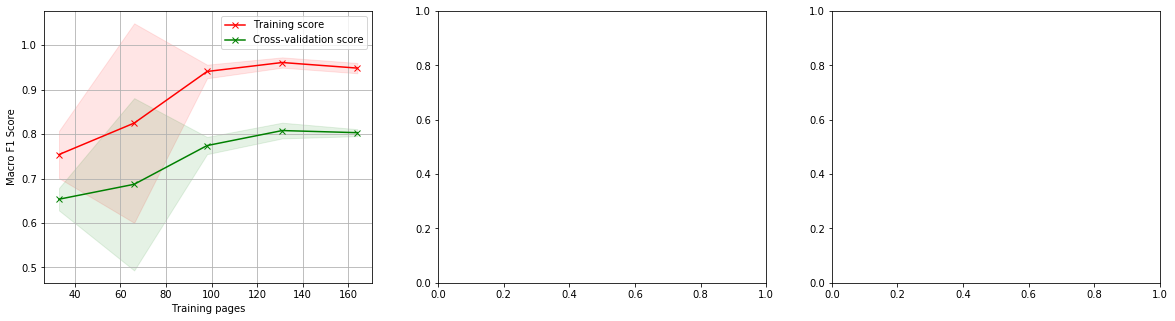

In [134]:
train_sizes = np.array([33, 66, 98, 131, 164])
_, axes = plt.subplots(1,3,figsize=(20, 5))
axes[0].set_xlabel("Training pages")
axes[0].set_ylabel("Macro F1 Score")

# Plot learning curve
axes[0].grid()
axes[0].fill_between(train_sizes, lc_train_means - lc_train_std,
                     lc_train_means + lc_train_std, alpha=0.1,
                     color="r")
axes[0].fill_between(train_sizes, lc_val_means - lc_val_std,
                     lc_val_means + lc_val_std, alpha=0.1,
                     color="g")
axes[0].plot(train_sizes, lc_train_means, 'x-', color="r",
             label="Training score")
axes[0].plot(train_sizes, lc_val_means, 'x-', color="g",
             label="Cross-validation score")
axes[0].legend(loc="best")

### Tag Vector / Tag Path

In [210]:
TAG_EXP_RECORDS = []
for iteration in range(5):
    print("Iteration start ",iteration)
    model, loss_fn = get_custom_emb_model(use_crf=True, embedding_size = 32, hidden_size = 300)
    model, avg_epoch_result = train_on_epoch(25, model, optimizer, train_dataset, val_dataset)
    score = evaluate_model(model, target='en')
    TAG_EXP_RECORDS.append(record)

Iteration start  0

Start of epoch 0


/home/sam/DL/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/sam/DL/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Validation loss: 21.7094
Validation F1: 0.5139
Time taken: 107.30s

Start of epoch 1
Validation loss: 24.5659
Validation F1: 0.5443
Time taken: 91.65s

Start of epoch 2
Validation loss: 25.9292
Validation F1: 0.6002
Time taken: 89.58s

Start of epoch 3
Validation loss: 22.7252
Validation F1: 0.7080
Time taken: 88.86s

Start of epoch 4
Validation loss: 25.0529
Validation F1: 0.7682
Time taken: 87.73s

Start of epoch 5
Validation loss: 34.0869
Validation F1: 0.7825
Time taken: 90.32s

Start of epoch 6
Validation loss: 23.1782
Validation F1: 0.7866
Time taken: 87.20s

Start of epoch 7
Validation loss: 19.4633
Validation F1: 0.7447
Time taken: 88.18s

Start of epoch 8
Validation loss: 26.3143
Validation F1: 0.8024
Time taken: 86.85s

Start of epoch 9
Validation loss: 21.3820
Validation F1: 0.8029
Time taken: 88.61s

Start of epoch 10
Validation loss: 19.4315
Validation F1: 0.7982
Time taken: 88.18s

Start of epoch 11
Validation loss: 31.8734
Validation F1: 0.8338
Time taken: 88.72s

Start 

IntProgress(value=0, description='(Init)', max=49)

/home/sam/DL/lib/python3.6/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


Start predicting test data ...
Start evaluating test data ...
                 PAGE       NEXT   micro avg   macro avg  weighted avg
precision    0.823077   0.614035    0.759358    0.718556      0.773239
recall       0.930435   0.972222    0.940397    0.951329      0.940397
f1-score     0.873469   0.752688    0.840237    0.813079      0.844674
support    115.000000  36.000000  151.000000  151.000000    151.000000
Testing language:  de


/home/sam/DL/lib/python3.6/site-packages/sklearn/utils/validation.py:71: FutureWarning: Pass labels=['PAGE', 'NEXT'] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


pages: 20  domains: 7
Transform key ['text-exact'] to word_vector ... 


IntProgress(value=0, description='(Init)', max=20)

/home/sam/DL/lib/python3.6/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


Start predicting test data ...
Start evaluating test data ...
                 PAGE       NEXT   micro avg   macro avg  weighted avg
precision    0.895522   0.829268    0.880000    0.862395      0.881082
recall       0.983607   1.000000    0.987179    0.991803      0.987179
f1-score     0.937500   0.906667    0.930514    0.922083      0.930780
support    122.000000  34.000000  156.000000  156.000000    156.000000
Testing language:  ru


/home/sam/DL/lib/python3.6/site-packages/sklearn/utils/validation.py:71: FutureWarning: Pass labels=['PAGE', 'NEXT'] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


pages: 21  domains: 14
Transform key ['text-exact'] to word_vector ... 


IntProgress(value=0, description='(Init)', max=21)

/home/sam/DL/lib/python3.6/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


Start predicting test data ...
Start evaluating test data ...
                PAGE       NEXT  micro avg  macro avg  weighted avg
precision   0.783784   0.769231   0.780000   0.776507      0.779524
recall      1.000000   0.833333   0.951220   0.916667      0.951220
f1-score    0.878788   0.800000   0.857143   0.839394      0.855728
support    29.000000  12.000000  41.000000  41.000000     41.000000
Testing language:  zh


/home/sam/DL/lib/python3.6/site-packages/sklearn/utils/validation.py:71: FutureWarning: Pass labels=['PAGE', 'NEXT'] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


pages: 44  domains: 19
Transform key ['text-exact'] to word_vector ... 


IntProgress(value=0, description='(Init)', max=44)

/home/sam/DL/lib/python3.6/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


Start predicting test data ...
Start evaluating test data ...
                 PAGE        NEXT   micro avg   macro avg  weighted avg
precision    0.601375    0.489796    0.585294    0.545585      0.558402
recall       0.961538    0.210526    0.672297    0.586032      0.672297
f1-score     0.739958    0.294479    0.625786    0.517218      0.568388
support    182.000000  114.000000  296.000000  296.000000    296.000000
Testing language:  ja


/home/sam/DL/lib/python3.6/site-packages/sklearn/utils/validation.py:71: FutureWarning: Pass labels=['PAGE', 'NEXT'] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


pages: 23  domains: 9
Transform key ['text-exact'] to word_vector ... 


IntProgress(value=0, description='(Init)', max=23)

/home/sam/DL/lib/python3.6/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


Start predicting test data ...
Start evaluating test data ...
                PAGE       NEXT  micro avg  macro avg  weighted avg
precision   0.543478   0.722222   0.593750   0.632850      0.589705
recall      0.581395   0.866667   0.655172   0.724031      0.655172
f1-score    0.561798   0.787879   0.622951   0.674838      0.620267
support    43.000000  15.000000  58.000000  58.000000     58.000000
Testing language:  ko


/home/sam/DL/lib/python3.6/site-packages/sklearn/utils/validation.py:71: FutureWarning: Pass labels=['PAGE', 'NEXT'] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


pages: 24  domains: 13
Transform key ['text-exact'] to word_vector ... 


IntProgress(value=0, description='(Init)', max=24)

/home/sam/DL/lib/python3.6/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


Start predicting test data ...
Start evaluating test data ...
                PAGE      NEXT  micro avg  macro avg  weighted avg
precision   0.580645  0.166667   0.555556   0.373656      0.548801
recall      0.900000  0.200000   0.846154   0.550000      0.846154
f1-score    0.705882  0.181818   0.670732   0.443850      0.665570
support    60.000000  5.000000  65.000000  65.000000     65.000000
Iter: 0, macro f1: 0.7017437854174214
Iteration start  1


/home/sam/DL/lib/python3.6/site-packages/sklearn/utils/validation.py:71: FutureWarning: Pass labels=['PAGE', 'NEXT'] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)



Start of epoch 0


/home/sam/DL/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/sam/DL/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Validation loss: 27.8063
Validation F1: 0.5036
Time taken: 89.31s

Start of epoch 1
Validation loss: 30.0984
Validation F1: 0.6556
Time taken: 87.78s

Start of epoch 2
Validation loss: 29.3025
Validation F1: 0.7754
Time taken: 88.17s

Start of epoch 3
Validation loss: 25.3018
Validation F1: 0.5741
Time taken: 88.15s

Start of epoch 4
Validation loss: 32.1029
Validation F1: 0.7919
Time taken: 88.05s

Start of epoch 5
Validation loss: 32.4056
Validation F1: 0.7766
Time taken: 88.28s

Start of epoch 6
Validation loss: 27.3387
Validation F1: 0.7633
Time taken: 87.32s

Start of epoch 7
Validation loss: 33.9373
Validation F1: 0.7951
Time taken: 88.06s

Start of epoch 8
Validation loss: 34.3276
Validation F1: 0.7772
Time taken: 88.51s

Start of epoch 9
Validation loss: 34.4132
Validation F1: 0.7772
Time taken: 87.46s

Start of epoch 10
Validation loss: 41.4329
Validation F1: 0.7847
Time taken: 88.26s

Start of epoch 11
Validation loss: 27.8068
Validation F1: 0.7985
Time taken: 87.54s

Start o

IntProgress(value=0, description='(Init)', max=49)

/home/sam/DL/lib/python3.6/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


Start predicting test data ...
Start evaluating test data ...
                 PAGE       NEXT   micro avg   macro avg  weighted avg
precision    0.828125   0.680851    0.788571    0.754488      0.793013
recall       0.921739   0.888889    0.913907    0.905314      0.913907
f1-score     0.872428   0.771084    0.846626    0.821756      0.848267
support    115.000000  36.000000  151.000000  151.000000    151.000000
Testing language:  de


/home/sam/DL/lib/python3.6/site-packages/sklearn/utils/validation.py:71: FutureWarning: Pass labels=['PAGE', 'NEXT'] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


pages: 20  domains: 7
Transform key ['text-exact'] to word_vector ... 


IntProgress(value=0, description='(Init)', max=20)

/home/sam/DL/lib/python3.6/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


Start predicting test data ...
Start evaluating test data ...
                 PAGE      NEXT   micro avg   macro avg  weighted avg
precision    0.914729   0.73913    0.868571    0.826930      0.876457
recall       0.967213   1.00000    0.974359    0.983607      0.974359
f1-score     0.940239   0.85000    0.918429    0.895120      0.920572
support    122.000000  34.00000  156.000000  156.000000    156.000000
Testing language:  ru


/home/sam/DL/lib/python3.6/site-packages/sklearn/utils/validation.py:71: FutureWarning: Pass labels=['PAGE', 'NEXT'] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


pages: 21  domains: 14
Transform key ['text-exact'] to word_vector ... 


IntProgress(value=0, description='(Init)', max=21)

/home/sam/DL/lib/python3.6/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


Start predicting test data ...
Start evaluating test data ...
                PAGE  NEXT  micro avg  macro avg  weighted avg
precision   0.777778   1.0   0.833333   0.888889      0.842818
recall      0.965517   1.0   0.975610   0.982759      0.975610
f1-score    0.861538   1.0   0.898876   0.930769      0.902064
support    29.000000  12.0  41.000000  41.000000     41.000000
Testing language:  zh


/home/sam/DL/lib/python3.6/site-packages/sklearn/utils/validation.py:71: FutureWarning: Pass labels=['PAGE', 'NEXT'] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


pages: 44  domains: 19
Transform key ['text-exact'] to word_vector ... 


IntProgress(value=0, description='(Init)', max=44)

/home/sam/DL/lib/python3.6/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


Start predicting test data ...
Start evaluating test data ...
                 PAGE        NEXT   micro avg   macro avg  weighted avg
precision    0.614545    0.590909    0.611285    0.602727      0.605442
recall       0.928571    0.228070    0.658784    0.578321      0.658784
f1-score     0.739606    0.329114    0.634146    0.534360      0.581511
support    182.000000  114.000000  296.000000  296.000000    296.000000
Testing language:  ja


/home/sam/DL/lib/python3.6/site-packages/sklearn/utils/validation.py:71: FutureWarning: Pass labels=['PAGE', 'NEXT'] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


pages: 23  domains: 9
Transform key ['text-exact'] to word_vector ... 


IntProgress(value=0, description='(Init)', max=23)

/home/sam/DL/lib/python3.6/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


Start predicting test data ...
Start evaluating test data ...
                PAGE       NEXT  micro avg  macro avg  weighted avg
precision   0.862069   1.000000   0.902439   0.931034      0.897741
recall      0.581395   0.800000   0.637931   0.690698      0.637931
f1-score    0.694444   0.888889   0.747475   0.791667      0.744732
support    43.000000  15.000000  58.000000  58.000000     58.000000
Testing language:  ko


/home/sam/DL/lib/python3.6/site-packages/sklearn/utils/validation.py:71: FutureWarning: Pass labels=['PAGE', 'NEXT'] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


pages: 24  domains: 13
Transform key ['text-exact'] to word_vector ... 


IntProgress(value=0, description='(Init)', max=24)

/home/sam/DL/lib/python3.6/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


Start predicting test data ...
Start evaluating test data ...
                PAGE      NEXT  micro avg  macro avg  weighted avg
precision   0.366337  0.285714   0.361111   0.326025      0.360135
recall      0.616667  0.400000   0.600000   0.508333      0.600000
f1-score    0.459627  0.333333   0.450867   0.396480      0.449912
support    60.000000  5.000000  65.000000  65.000000     65.000000
Iter: 1, macro f1: 0.7283586560896803
Iteration start  2


/home/sam/DL/lib/python3.6/site-packages/sklearn/utils/validation.py:71: FutureWarning: Pass labels=['PAGE', 'NEXT'] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)



Start of epoch 0


/home/sam/DL/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/sam/DL/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Validation loss: 18.9873
Validation F1: 0.5250
Time taken: 87.95s

Start of epoch 1
Validation loss: 22.7381
Validation F1: 0.7374
Time taken: 88.22s

Start of epoch 2
Validation loss: 20.9911
Validation F1: 0.7880
Time taken: 88.78s

Start of epoch 3
Validation loss: 18.4211
Validation F1: 0.7963
Time taken: 86.96s

Start of epoch 4
Validation loss: 20.2250
Validation F1: 0.8037
Time taken: 88.21s

Start of epoch 5
Validation loss: 19.6735
Validation F1: 0.8127
Time taken: 86.65s

Start of epoch 6
Validation loss: 21.5966
Validation F1: 0.8044
Time taken: 87.49s

Start of epoch 7
Validation loss: 23.2392
Validation F1: 0.8039
Time taken: 86.86s

Start of epoch 8
Validation loss: 25.6304
Validation F1: 0.8037
Time taken: 87.73s

Start of epoch 9
Validation loss: 24.1781
Validation F1: 0.8044
Time taken: 87.48s

Start of epoch 10
Validation loss: 27.1534
Validation F1: 0.8044
Time taken: 86.59s

Start of epoch 11
Validation loss: 24.9970
Validation F1: 0.8377
Time taken: 87.77s

Start o

IntProgress(value=0, description='(Init)', max=49)

/home/sam/DL/lib/python3.6/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


Start predicting test data ...
Start evaluating test data ...
                 PAGE       NEXT   micro avg   macro avg  weighted avg
precision    0.872881   0.666667    0.810651    0.769774      0.823718
recall       0.895652   0.944444    0.907285    0.920048      0.907285
f1-score     0.884120   0.781609    0.856250    0.832865      0.859680
support    115.000000  36.000000  151.000000  151.000000    151.000000
Testing language:  de


/home/sam/DL/lib/python3.6/site-packages/sklearn/utils/validation.py:71: FutureWarning: Pass labels=['PAGE', 'NEXT'] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


pages: 20  domains: 7
Transform key ['text-exact'] to word_vector ... 


IntProgress(value=0, description='(Init)', max=20)

/home/sam/DL/lib/python3.6/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


Start predicting test data ...
Start evaluating test data ...
                 PAGE       NEXT   micro avg   macro avg  weighted avg
precision    0.918033   0.871795    0.906832    0.894914      0.907955
recall       0.918033   1.000000    0.935897    0.959016      0.935897
f1-score     0.918033   0.931507    0.921136    0.924770      0.920969
support    122.000000  34.000000  156.000000  156.000000    156.000000
Testing language:  ru


/home/sam/DL/lib/python3.6/site-packages/sklearn/utils/validation.py:71: FutureWarning: Pass labels=['PAGE', 'NEXT'] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


pages: 21  domains: 14
Transform key ['text-exact'] to word_vector ... 


IntProgress(value=0, description='(Init)', max=21)

/home/sam/DL/lib/python3.6/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


Start predicting test data ...
Start evaluating test data ...
                PAGE       NEXT  micro avg  macro avg  weighted avg
precision   0.812500   0.909091   0.837209   0.860795      0.840771
recall      0.896552   0.833333   0.878049   0.864943      0.878049
f1-score    0.852459   0.869565   0.857143   0.861012      0.857466
support    29.000000  12.000000  41.000000  41.000000     41.000000
Testing language:  zh


/home/sam/DL/lib/python3.6/site-packages/sklearn/utils/validation.py:71: FutureWarning: Pass labels=['PAGE', 'NEXT'] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


pages: 44  domains: 19
Transform key ['text-exact'] to word_vector ... 


IntProgress(value=0, description='(Init)', max=44)

/home/sam/DL/lib/python3.6/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


Start predicting test data ...
Start evaluating test data ...
                 PAGE        NEXT   micro avg   macro avg  weighted avg
precision    0.686992    0.500000    0.660839    0.593496      0.614975
recall       0.928571    0.175439    0.638514    0.552005      0.638514
f1-score     0.789720    0.259740    0.649485    0.524730      0.585606
support    182.000000  114.000000  296.000000  296.000000    296.000000
Testing language:  ja


/home/sam/DL/lib/python3.6/site-packages/sklearn/utils/validation.py:71: FutureWarning: Pass labels=['PAGE', 'NEXT'] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


pages: 23  domains: 9
Transform key ['text-exact'] to word_vector ... 


IntProgress(value=0, description='(Init)', max=23)

/home/sam/DL/lib/python3.6/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


Start predicting test data ...
Start evaluating test data ...
                PAGE       NEXT  micro avg  macro avg  weighted avg
precision   0.560976   0.705882   0.603448   0.633429      0.598451
recall      0.534884   0.800000   0.603448   0.667442      0.603448
f1-score    0.547619   0.750000   0.603448   0.648810      0.599959
support    43.000000  15.000000  58.000000  58.000000     58.000000
Testing language:  ko


/home/sam/DL/lib/python3.6/site-packages/sklearn/utils/validation.py:71: FutureWarning: Pass labels=['PAGE', 'NEXT'] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


pages: 24  domains: 13
Transform key ['text-exact'] to word_vector ... 


IntProgress(value=0, description='(Init)', max=24)

/home/sam/DL/lib/python3.6/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


Start predicting test data ...
Start evaluating test data ...
                PAGE      NEXT  micro avg  macro avg  weighted avg
precision   0.505747  0.666667   0.511111   0.586207      0.518126
recall      0.733333  0.400000   0.707692   0.566667      0.707692
f1-score    0.598639  0.500000   0.593548   0.549320      0.591052
support    60.000000  5.000000  65.000000  65.000000     65.000000
Iter: 2, macro f1: 0.7235843021975854


/home/sam/DL/lib/python3.6/site-packages/sklearn/utils/validation.py:71: FutureWarning: Pass labels=['PAGE', 'NEXT'] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


In [209]:
reports = evaluate_model(model, target = 'ko')

Testing language:  ko
pages: 24  domains: 13
Transform key ['text-exact'] to word_vector ... 


IntProgress(value=0, description='(Init)', max=24)

/home/sam/DL/lib/python3.6/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


Start predicting test data ...
Start evaluating test data ...
           PAGE  NEXT  micro avg  macro avg  weighted avg
precision   0.0   0.0        0.0        0.0           0.0
recall      0.0   0.0        0.0        0.0           0.0
f1-score    0.0   0.0        0.0        0.0           0.0
support    60.0   5.0       65.0       65.0          65.0


/home/sam/DL/lib/python3.6/site-packages/sklearn/utils/validation.py:71: FutureWarning: Pass labels=['PAGE', 'NEXT'] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)
/home/sam/DL/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [211]:
TAG_EXP_RECORDS

[{'iter': 0, 'macro_avg': 0.7017437854174214},
 {'iter': 1, 'macro_avg': 0.7283586560896803},
 {'iter': 2, 'macro_avg': 0.7235843021975854}]

### Training curve

In [124]:
best_score = 0
best_model_weights = None
best_history = None
BEST_MODEL_RECORDS = []
epoch_datas = []
for iteration in range(15):
    print("Iteration start ",iteration)
    model, loss_fn = get_custom_emb_model(embedding_size=32,hidden_size=300)
    model, avg_epoch_result = train_on_epoch(25, model, optimizer, train_dataset, val_dataset) #Use f1-score to choose best model
    epoch_datas.append(avg_epoch_result)
#     reports = evaluate_model(model)
#     macro_avg = calculate_macro_avg(reports)
#     if macro_avg > best_score:
#         best_score = macro_avg
#         best_model_weights = model.get_weights()
#         
#     print(f"Iter: {iteration}, macro f1: {macro_avg}")
#     record = {"iter": iteration, "macro_avg": macro_avg}
#     BEST_MODEL_RECORDS.append(record)

Iteration start  0

Start of epoch 0


/home/sam/DL/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/sam/DL/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Validation loss: 17.7222
Validation F1: 0.5930
Time taken: 202.16s

Start of epoch 1
Validation loss: 16.5921
Validation F1: 0.7722
Time taken: 191.88s

Start of epoch 2
Validation loss: 15.2430
Validation F1: 0.7816
Time taken: 170.88s

Start of epoch 3
Validation loss: 12.1584
Validation F1: 0.7973
Time taken: 169.25s

Start of epoch 4
Validation loss: 15.9523
Validation F1: 0.7720
Time taken: 121.35s

Start of epoch 5
Validation loss: 19.9557
Validation F1: 0.7913
Time taken: 132.35s

Start of epoch 6
Validation loss: 14.0755
Validation F1: 0.8053
Time taken: 194.56s

Start of epoch 7
Validation loss: 19.0250
Validation F1: 0.7981
Time taken: 161.52s

Start of epoch 8
Validation loss: 13.6113
Validation F1: 0.8049
Time taken: 175.68s

Start of epoch 9
Validation loss: 18.2709
Validation F1: 0.8014
Time taken: 196.43s

Start of epoch 10
Validation loss: 20.7103
Validation F1: 0.7978
Time taken: 185.70s

Start of epoch 11
Validation loss: 17.7850
Validation F1: 0.7923
Time taken: 206.

Validation loss: 20.9564
Validation F1: 0.8001
Time taken: 216.35s

Start of epoch 18
Validation loss: 16.8506
Validation F1: 0.8345
Time taken: 214.36s

Start of epoch 19
Validation loss: 11.2146
Validation F1: 0.8359
Time taken: 236.83s

Start of epoch 20
Validation loss: 8.4514
Validation F1: 0.7772
Time taken: 213.60s

Start of epoch 21
Validation loss: 23.6873
Validation F1: 0.7996
Time taken: 203.35s

Start of epoch 22
Validation loss: 9.8796
Validation F1: 0.7736
Time taken: 210.23s

Start of epoch 23
Validation loss: 20.1520
Validation F1: 0.8001
Time taken: 237.26s

Start of epoch 24
Validation loss: 20.0838
Validation F1: 0.8209
Time taken: 222.35s
Best loss: 8.451393127441406, Best F1: 0.8359302194684307
Training finish, load best weights. f1-score
Iteration start  4

Start of epoch 0
Validation loss: 21.7266
Validation F1: 0.4819
Time taken: 216.42s

Start of epoch 1
Validation loss: 20.5605
Validation F1: 0.5333
Time taken: 216.25s

Start of epoch 2
Validation loss: 21.339

Validation loss: 22.1771
Validation F1: 0.8066
Time taken: 199.05s

Start of epoch 9
Validation loss: 22.9213
Validation F1: 0.8380
Time taken: 213.26s

Start of epoch 10
Validation loss: 21.8268
Validation F1: 0.8078
Time taken: 160.79s

Start of epoch 11
Validation loss: 18.8050
Validation F1: 0.8336
Time taken: 188.94s

Start of epoch 12
Validation loss: 22.0033
Validation F1: 0.8420
Time taken: 212.61s

Start of epoch 13
Validation loss: 16.1520
Validation F1: 0.7866
Time taken: 173.28s

Start of epoch 14
Validation loss: 22.3847
Validation F1: 0.8049
Time taken: 161.07s

Start of epoch 15
Validation loss: 33.2768
Validation F1: 0.8250
Time taken: 138.74s

Start of epoch 16
Validation loss: 21.6470
Validation F1: 0.8087
Time taken: 105.18s

Start of epoch 17
Validation loss: 21.3436
Validation F1: 0.8337
Time taken: 136.76s

Start of epoch 18
Validation loss: 24.0168
Validation F1: 0.8087
Time taken: 137.23s

Start of epoch 19
Validation loss: 18.3703
Validation F1: 0.8087
Time tak


Start of epoch 0
Validation loss: 23.9859
Validation F1: 0.4708
Time taken: 155.01s

Start of epoch 1
Validation loss: 22.2838
Validation F1: 0.6352
Time taken: 133.99s

Start of epoch 2
Validation loss: 22.4918
Validation F1: 0.7069
Time taken: 145.05s

Start of epoch 3
Validation loss: 24.7132
Validation F1: 0.7568
Time taken: 151.97s

Start of epoch 4
Validation loss: 27.0871
Validation F1: 0.7904
Time taken: 152.61s

Start of epoch 5
Validation loss: 24.6184
Validation F1: 0.7868
Time taken: 125.94s

Start of epoch 6
Validation loss: 22.3959
Validation F1: 0.8002
Time taken: 120.28s

Start of epoch 7
Validation loss: 24.2766
Validation F1: 0.7826
Time taken: 154.24s

Start of epoch 8
Validation loss: 32.3484
Validation F1: 0.7772
Time taken: 155.74s

Start of epoch 9
Validation loss: 28.6107
Validation F1: 0.8007
Time taken: 129.16s

Start of epoch 10
Validation loss: 26.9379
Validation F1: 0.8088
Time taken: 155.52s

Start of epoch 11
Validation loss: 25.9874
Validation F1: 0.804

Validation loss: 31.7371
Validation F1: 0.7803
Time taken: 87.65s

Start of epoch 18
Validation loss: 35.3313
Validation F1: 0.7962
Time taken: 108.94s

Start of epoch 19
Validation loss: 23.4372
Validation F1: 0.7860
Time taken: 108.47s

Start of epoch 20
Validation loss: 19.7545
Validation F1: 0.8373
Time taken: 107.74s

Start of epoch 21
Validation loss: 40.5490
Validation F1: 0.7907
Time taken: 109.89s

Start of epoch 22
Validation loss: 47.0985
Validation F1: 0.7782
Time taken: 112.25s

Start of epoch 23
Validation loss: 42.8355
Validation F1: 0.8043
Time taken: 103.55s

Start of epoch 24
Validation loss: 37.6302
Validation F1: 0.8011
Time taken: 94.90s
Best loss: 15.046183586120605, Best F1: 0.8372504523152451
Training finish, load best weights. f1-score


In [255]:
pd.DataFrame(epoch_datas)

,epoch_losses,epoch_f1s
0,"[17.722212, 16.592083, 15.243045, 12.158374, 1...","[0.5929959145079206, 0.772170581065428, 0.7816..."
1,"[23.015968, 21.971441, 18.917515, 24.22556, 19...","[0.48023922166190564, 0.6850508873037267, 0.75..."
2,"[32.89872, 33.80329, 37.255016, 25.426779, 31....","[0.5190888918900612, 0.7305137643404984, 0.691..."
3,"[46.33201, 30.331207, 20.341503, 17.070593, 15...","[0.2999306518723994, 0.2999306518723994, 0.508..."
4,"[21.726618, 20.560541, 21.339804, 22.269094, 2...","[0.4818525535001834, 0.5333036146629015, 0.587..."
5,"[19.355988, 22.484194, 14.887907, 20.062296, 1...","[0.5296613864717953, 0.7696218632746671, 0.732..."
6,"[22.41304, 23.149826, 19.577854, 15.478767, 27...","[0.6873872058440902, 0.7024935775689938, 0.779..."
7,"[28.67123, 18.32191, 21.669058, 17.720291, 19....","[0.2999306518723994, 0.6394227403467535, 0.793..."
8,"[35.12985, 21.723433, 22.652517, 26.258575, 21...","[0.4881621298272674, 0.710172567372973, 0.6060..."
9,"[27.519873, 23.696928, 25.754333, 27.742687, 2...","[0.4768812708807445, 0.7827292243596491, 0.754..."


In [128]:
loss_array = [datas['epoch_losses'] for datas in epoch_datas]
f1_array = [datas['epoch_f1s'] for datas in epoch_datas]

In [148]:
train_sizes = np.linspace(1,len(loss_array[0]),len(loss_array[0]))

In [249]:
train_sizes

array([ 1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12., 13.,
       14., 15., 16., 17., 18., 19., 20., 21., 22., 23., 24., 25.])

In [134]:
train_losses_mean = np.mean(loss_array, axis=0)
train_losses_std = np.std(loss_array, axis=0)
train_f1_mean = np.mean(f1_array, axis=0)
train_f1_std = np.std(f1_array, axis=0)

In [138]:
train_f1_std

array([0.09715663, 0.12214419, 0.08411272, 0.06762164, 0.03024756,
       0.03430639, 0.01762338, 0.02518961, 0.03077373, 0.03651316,
       0.01526592, 0.02395058, 0.01765581, 0.0250245 , 0.05916652,
       0.02348575, 0.03722205, 0.02141095, 0.02358453, 0.02342008,
       0.02349227, 0.01978131, 0.02975215, 0.02322765, 0.01912842])

In [1]:
import matplotlib.pyplot as plt

In [147]:
np.linspace(.1, 1.0, 5)

array([0.1  , 0.325, 0.55 , 0.775, 1.   ])

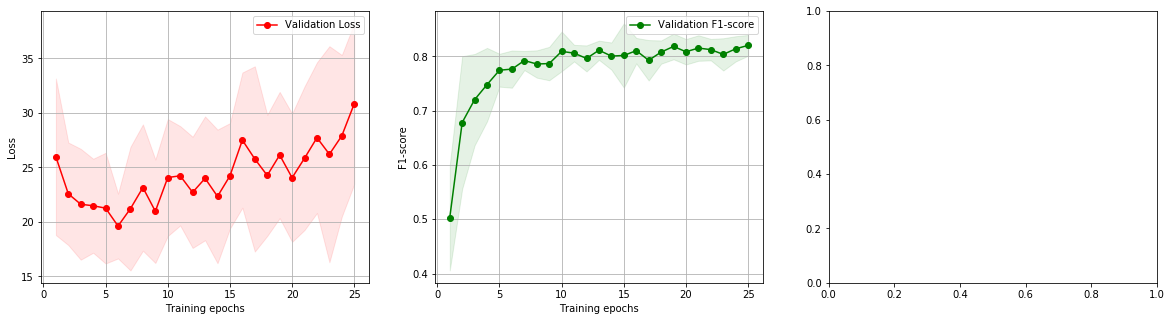

In [159]:
_, axes = plt.subplots(1,3,figsize=(20, 5))
axes[0].set_xlabel("Training epochs")
axes[0].set_ylabel("Loss")

# Plot learning curve
axes[0].grid()
axes[0].fill_between(train_sizes, train_losses_mean - train_losses_std,
                     train_losses_mean + train_losses_std, alpha=0.1,
                     color="r")
axes[0].plot(train_sizes, train_losses_mean, 'o-', color="r",
             label="Validation Loss")
axes[0].legend(loc="best")
##########################################################################
axes[1].set_xlabel("Training epochs")
axes[1].set_ylabel("F1-score")

# Plot learning curve
axes[1].grid()
axes[1].fill_between(train_sizes, train_f1_mean - train_f1_std,
                     train_f1_mean + train_f1_std, alpha=0.1,
                     color="g")
axes[1].plot(train_sizes, train_f1_mean, 'o-', color="g",
             label="Validation F1-score")
axes[1].legend(loc="best")

### Save best model

In [79]:
BEST_MODEL_RECORDS

[{'iter': 0, 'macro_avg': 0.6585991713693428},
 {'iter': 1, 'macro_avg': 0.7517082081030869},
 {'iter': 2, 'macro_avg': 0.7305036753424899},
 {'iter': 3, 'macro_avg': 0.6902004741461556},
 {'iter': 4, 'macro_avg': 0.7440229999359618}]

In [117]:
model.set_weights(best_model_weights)

In [116]:
checkpoint_path = "training_best/cp-best.ckpt"

In [118]:
model.save_weights(checkpoint_path)

### Ablation Tag Path

In [213]:
PTAG_ABLA_EXP_RECORDS = []
for iteration in range(3):
    print("Iteration start ",iteration)
    model, loss_fn = get_ablation_ptag_model(use_crf=True)
    model, avg_epoch_result = train_on_epoch(25, model, optimizer, train_dataset, val_dataset)
    reports = evaluate_model(model)
    macro_avg = calculate_macro_avg(reports)
    print(f"Iter: {iteration}, macro f1: {macro_avg}")
    record = {"iter": iteration, "macro_avg": macro_avg}
    PTAG_ABLA_EXP_RECORDS.append(record)

Iteration start  0

Start of epoch 0


/home/sam/DL/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/sam/DL/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Validation loss: 19.0381
Validation F1: 0.4948
Time taken: 122.25s

Start of epoch 1
Validation loss: 17.1538
Validation F1: 0.7591
Time taken: 109.32s

Start of epoch 2
Validation loss: 16.8831
Validation F1: 0.7741
Time taken: 122.70s

Start of epoch 3
Validation loss: 15.7777
Validation F1: 0.7486
Time taken: 134.00s

Start of epoch 4
Validation loss: 21.1206
Validation F1: 0.7758
Time taken: 125.16s

Start of epoch 5
Validation loss: 17.4032
Validation F1: 0.8043
Time taken: 126.25s

Start of epoch 6
Validation loss: 15.0006
Validation F1: 0.8167
Time taken: 107.66s

Start of epoch 7
Validation loss: 11.1660
Validation F1: 0.7870
Time taken: 107.58s

Start of epoch 8
Validation loss: 21.2416
Validation F1: 0.8036
Time taken: 103.14s

Start of epoch 9
Validation loss: 17.5988
Validation F1: 0.7897
Time taken: 120.25s

Start of epoch 10
Validation loss: 17.6910
Validation F1: 0.7898
Time taken: 124.74s

Start of epoch 11
Validation loss: 12.7231
Validation F1: 0.7166
Time taken: 120.

IntProgress(value=0, description='(Init)', max=49)

/home/sam/DL/lib/python3.6/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


Start predicting test data ...
Start evaluating test data ...
                 PAGE       NEXT   micro avg   macro avg  weighted avg
precision    0.812030   0.617021    0.761111    0.714526      0.765538
recall       0.939130   0.805556    0.907285    0.872343      0.907285
f1-score     0.870968   0.698795    0.827795    0.784881      0.829920
support    115.000000  36.000000  151.000000  151.000000    151.000000
Testing language:  de


/home/sam/DL/lib/python3.6/site-packages/sklearn/utils/validation.py:71: FutureWarning: Pass labels=['PAGE', 'NEXT'] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


pages: 20  domains: 7
Transform key ['text-exact'] to word_vector ... 


IntProgress(value=0, description='(Init)', max=20)

/home/sam/DL/lib/python3.6/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


Start predicting test data ...
Start evaluating test data ...
                 PAGE       NEXT   micro avg   macro avg  weighted avg
precision    0.880597   0.820513    0.867052    0.850555      0.867502
recall       0.967213   0.941176    0.961538    0.954195      0.961538
f1-score     0.921875   0.876712    0.911854    0.899294      0.912032
support    122.000000  34.000000  156.000000  156.000000    156.000000
Testing language:  ru


/home/sam/DL/lib/python3.6/site-packages/sklearn/utils/validation.py:71: FutureWarning: Pass labels=['PAGE', 'NEXT'] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


pages: 21  domains: 14
Transform key ['text-exact'] to word_vector ... 


IntProgress(value=0, description='(Init)', max=21)

/home/sam/DL/lib/python3.6/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


Start predicting test data ...
Start evaluating test data ...
                PAGE       NEXT  micro avg  macro avg  weighted avg
precision   0.783784   1.000000   0.822222   0.891892      0.847067
recall      1.000000   0.666667   0.902439   0.833333      0.902439
f1-score    0.878788   0.800000   0.860465   0.839394      0.855728
support    29.000000  12.000000  41.000000  41.000000     41.000000
Testing language:  zh


/home/sam/DL/lib/python3.6/site-packages/sklearn/utils/validation.py:71: FutureWarning: Pass labels=['PAGE', 'NEXT'] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


pages: 44  domains: 19
Transform key ['text-exact'] to word_vector ... 


IntProgress(value=0, description='(Init)', max=44)

/home/sam/DL/lib/python3.6/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


Start predicting test data ...
Start evaluating test data ...
                 PAGE        NEXT   micro avg   macro avg  weighted avg
precision    0.587662    0.766667    0.603550    0.677165      0.656603
recall       0.994505    0.201754    0.689189    0.598130      0.689189
f1-score     0.738776    0.319444    0.643533    0.529110      0.577276
support    182.000000  114.000000  296.000000  296.000000    296.000000
Testing language:  ja


/home/sam/DL/lib/python3.6/site-packages/sklearn/utils/validation.py:71: FutureWarning: Pass labels=['PAGE', 'NEXT'] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


pages: 23  domains: 9
Transform key ['text-exact'] to word_vector ... 


IntProgress(value=0, description='(Init)', max=23)

/home/sam/DL/lib/python3.6/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


Start predicting test data ...
Start evaluating test data ...
                PAGE       NEXT  micro avg  macro avg  weighted avg
precision   0.894737   0.818182   0.866667   0.856459      0.874938
recall      0.395349   0.600000   0.448276   0.497674      0.448276
f1-score    0.548387   0.692308   0.590909   0.620347      0.585608
support    43.000000  15.000000  58.000000  58.000000     58.000000
Testing language:  ko


/home/sam/DL/lib/python3.6/site-packages/sklearn/utils/validation.py:71: FutureWarning: Pass labels=['PAGE', 'NEXT'] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


pages: 24  domains: 13
Transform key ['text-exact'] to word_vector ... 


IntProgress(value=0, description='(Init)', max=24)

/home/sam/DL/lib/python3.6/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


Start predicting test data ...
Start evaluating test data ...
                PAGE      NEXT  micro avg  macro avg  weighted avg
precision   0.542056  0.250000   0.531532   0.396028      0.519590
recall      0.966667  0.200000   0.907692   0.583333      0.907692
f1-score    0.694611  0.222222   0.670455   0.458417      0.658273
support    60.000000  5.000000  65.000000  65.000000     65.000000
Iter: 0, macro f1: 0.6885738228840937
Iteration start  1


/home/sam/DL/lib/python3.6/site-packages/sklearn/utils/validation.py:71: FutureWarning: Pass labels=['PAGE', 'NEXT'] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)



Start of epoch 0


/home/sam/DL/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/sam/DL/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Validation loss: 21.8700
Validation F1: 0.5196
Time taken: 162.33s

Start of epoch 1
Validation loss: 20.4138
Validation F1: 0.6032
Time taken: 163.24s

Start of epoch 2
Validation loss: 18.6113
Validation F1: 0.7043
Time taken: 152.02s

Start of epoch 3
Validation loss: 16.9449
Validation F1: 0.7346
Time taken: 126.38s

Start of epoch 4
Validation loss: 15.9991
Validation F1: 0.7536
Time taken: 123.41s

Start of epoch 5
Validation loss: 19.5573
Validation F1: 0.7782
Time taken: 145.51s

Start of epoch 6
Validation loss: 27.8132
Validation F1: 0.4914
Time taken: 151.00s

Start of epoch 7
Validation loss: 25.5668
Validation F1: 0.5150
Time taken: 152.74s

Start of epoch 8
Validation loss: 27.1825
Validation F1: 0.7413
Time taken: 160.63s

Start of epoch 9
Validation loss: 24.2267
Validation F1: 0.7875
Time taken: 160.20s

Start of epoch 10
Validation loss: 24.7405
Validation F1: 0.7866
Time taken: 162.93s

Start of epoch 11
Validation loss: 25.5611
Validation F1: 0.7866
Time taken: 149.

IntProgress(value=0, description='(Init)', max=49)

/home/sam/DL/lib/python3.6/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


Start predicting test data ...
Start evaluating test data ...
                 PAGE       NEXT   micro avg   macro avg  weighted avg
precision    0.810606   0.685714    0.784431    0.748160      0.780831
recall       0.930435   0.666667    0.867550    0.798551      0.867550
f1-score     0.866397   0.676056    0.823899    0.771227      0.821018
support    115.000000  36.000000  151.000000  151.000000    151.000000
Testing language:  de


/home/sam/DL/lib/python3.6/site-packages/sklearn/utils/validation.py:71: FutureWarning: Pass labels=['PAGE', 'NEXT'] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


pages: 20  domains: 7
Transform key ['text-exact'] to word_vector ... 


IntProgress(value=0, description='(Init)', max=20)

/home/sam/DL/lib/python3.6/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


Start predicting test data ...
Start evaluating test data ...
                 PAGE       NEXT   micro avg   macro avg  weighted avg
precision    0.912000   0.967742    0.923077    0.939871      0.924149
recall       0.934426   0.882353    0.923077    0.908390      0.923077
f1-score     0.923077   0.923077    0.923077    0.923077      0.923077
support    122.000000  34.000000  156.000000  156.000000    156.000000
Testing language:  ru


/home/sam/DL/lib/python3.6/site-packages/sklearn/utils/validation.py:71: FutureWarning: Pass labels=['PAGE', 'NEXT'] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


pages: 21  domains: 14
Transform key ['text-exact'] to word_vector ... 


IntProgress(value=0, description='(Init)', max=21)

/home/sam/DL/lib/python3.6/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


Start predicting test data ...
Start evaluating test data ...
                PAGE   NEXT  micro avg  macro avg  weighted avg
precision   0.783784   1.00   0.800000   0.891892      0.847067
recall      1.000000   0.25   0.780488   0.625000      0.780488
f1-score    0.878788   0.40   0.790123   0.639394      0.738655
support    29.000000  12.00  41.000000  41.000000     41.000000
Testing language:  zh


/home/sam/DL/lib/python3.6/site-packages/sklearn/utils/validation.py:71: FutureWarning: Pass labels=['PAGE', 'NEXT'] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


pages: 44  domains: 19
Transform key ['text-exact'] to word_vector ... 


IntProgress(value=0, description='(Init)', max=44)

/home/sam/DL/lib/python3.6/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


Start predicting test data ...
Start evaluating test data ...
                 PAGE        NEXT   micro avg   macro avg  weighted avg
precision    0.661710    0.826087    0.674658    0.743898      0.725017
recall       0.978022    0.166667    0.665541    0.572344      0.665541
f1-score     0.789357    0.277372    0.670068    0.533365      0.592174
support    182.000000  114.000000  296.000000  296.000000    296.000000
Testing language:  ja


/home/sam/DL/lib/python3.6/site-packages/sklearn/utils/validation.py:71: FutureWarning: Pass labels=['PAGE', 'NEXT'] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


pages: 23  domains: 9
Transform key ['text-exact'] to word_vector ... 


IntProgress(value=0, description='(Init)', max=23)

/home/sam/DL/lib/python3.6/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


Start predicting test data ...
Start evaluating test data ...
                PAGE       NEXT  micro avg  macro avg  weighted avg
precision   0.675676   1.000000   0.720930   0.837838      0.759553
recall      0.581395   0.400000   0.534483   0.490698      0.534483
f1-score    0.625000   0.571429   0.613861   0.598214      0.611145
support    43.000000  15.000000  58.000000  58.000000     58.000000
Testing language:  ko


/home/sam/DL/lib/python3.6/site-packages/sklearn/utils/validation.py:71: FutureWarning: Pass labels=['PAGE', 'NEXT'] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


pages: 24  domains: 13
Transform key ['text-exact'] to word_vector ... 


IntProgress(value=0, description='(Init)', max=24)

/home/sam/DL/lib/python3.6/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


Start predicting test data ...
Start evaluating test data ...
                PAGE  NEXT  micro avg  macro avg  weighted avg
precision   0.662921   0.0   0.662921   0.331461      0.611927
recall      0.983333   0.0   0.907692   0.491667      0.907692
f1-score    0.791946   0.0   0.766234   0.395973      0.731027
support    60.000000   5.0  65.000000  65.000000     65.000000
Iter: 1, macro f1: 0.6435415792924633
Iteration start  2


/home/sam/DL/lib/python3.6/site-packages/sklearn/utils/validation.py:71: FutureWarning: Pass labels=['PAGE', 'NEXT'] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)
/home/sam/DL/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



Start of epoch 0


/home/sam/DL/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/sam/DL/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Validation loss: 25.6581
Validation F1: 0.5413
Time taken: 115.97s

Start of epoch 1
Validation loss: 19.1736
Validation F1: 0.4212
Time taken: 115.66s

Start of epoch 2
Validation loss: 19.3678
Validation F1: 0.6716
Time taken: 113.06s

Start of epoch 3
Validation loss: 23.4598
Validation F1: 0.5098
Time taken: 104.08s

Start of epoch 4
Validation loss: 24.1514
Validation F1: 0.7614
Time taken: 99.12s

Start of epoch 5
Validation loss: 17.9248
Validation F1: 0.7917
Time taken: 94.13s

Start of epoch 6
Validation loss: 21.0982
Validation F1: 0.7733
Time taken: 93.77s

Start of epoch 7
Validation loss: 20.7326
Validation F1: 0.7806
Time taken: 91.54s

Start of epoch 8
Validation loss: 22.3499
Validation F1: 0.7663
Time taken: 91.85s

Start of epoch 9
Validation loss: 18.7927
Validation F1: 0.7727
Time taken: 90.39s

Start of epoch 10
Validation loss: 24.5582
Validation F1: 0.7688
Time taken: 92.24s

Start of epoch 11
Validation loss: 21.0508
Validation F1: 0.7680
Time taken: 90.56s

Sta

IntProgress(value=0, description='(Init)', max=49)

/home/sam/DL/lib/python3.6/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


Start predicting test data ...
Start evaluating test data ...
                 PAGE       NEXT   micro avg   macro avg  weighted avg
precision    0.760870   0.648148    0.729167    0.704509      0.733996
recall       0.913043   0.972222    0.927152    0.942633      0.927152
f1-score     0.830040   0.777778    0.816327    0.803909      0.817580
support    115.000000  36.000000  151.000000  151.000000    151.000000
Testing language:  de


/home/sam/DL/lib/python3.6/site-packages/sklearn/utils/validation.py:71: FutureWarning: Pass labels=['PAGE', 'NEXT'] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


pages: 20  domains: 7
Transform key ['text-exact'] to word_vector ... 


IntProgress(value=0, description='(Init)', max=20)

/home/sam/DL/lib/python3.6/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


Start predicting test data ...
Start evaluating test data ...
                 PAGE       NEXT   micro avg   macro avg  weighted avg
precision    0.772152   0.789474    0.775510    0.780813      0.775927
recall       1.000000   0.882353    0.974359    0.941176      0.974359
f1-score     0.871429   0.833333    0.863636    0.852381      0.863126
support    122.000000  34.000000  156.000000  156.000000    156.000000
Testing language:  ru


/home/sam/DL/lib/python3.6/site-packages/sklearn/utils/validation.py:71: FutureWarning: Pass labels=['PAGE', 'NEXT'] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


pages: 21  domains: 14
Transform key ['text-exact'] to word_vector ... 


IntProgress(value=0, description='(Init)', max=21)

/home/sam/DL/lib/python3.6/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


Start predicting test data ...
Start evaluating test data ...
                PAGE       NEXT  micro avg  macro avg  weighted avg
precision   0.777778   0.833333   0.791667   0.805556      0.794038
recall      0.965517   0.833333   0.926829   0.899425      0.926829
f1-score    0.861538   0.833333   0.853933   0.847436      0.853283
support    29.000000  12.000000  41.000000  41.000000     41.000000
Testing language:  zh


/home/sam/DL/lib/python3.6/site-packages/sklearn/utils/validation.py:71: FutureWarning: Pass labels=['PAGE', 'NEXT'] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


pages: 44  domains: 19
Transform key ['text-exact'] to word_vector ... 


IntProgress(value=0, description='(Init)', max=44)

/home/sam/DL/lib/python3.6/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


Start predicting test data ...
Start evaluating test data ...
                 PAGE        NEXT   micro avg   macro avg  weighted avg
precision    0.537764    0.418919    0.516049    0.478342      0.491993
recall       0.978022    0.271930    0.706081    0.624976      0.706081
f1-score     0.693957    0.329787    0.596291    0.511872      0.553702
support    182.000000  114.000000  296.000000  296.000000    296.000000
Testing language:  ja


/home/sam/DL/lib/python3.6/site-packages/sklearn/utils/validation.py:71: FutureWarning: Pass labels=['PAGE', 'NEXT'] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


pages: 23  domains: 9
Transform key ['text-exact'] to word_vector ... 


IntProgress(value=0, description='(Init)', max=23)

/home/sam/DL/lib/python3.6/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


Start predicting test data ...
Start evaluating test data ...
                PAGE       NEXT  micro avg  macro avg  weighted avg
precision   0.510204   0.647059   0.545455   0.578631      0.545598
recall      0.581395   0.733333   0.620690   0.657364      0.620690
f1-score    0.543478   0.687500   0.580645   0.615489      0.580725
support    43.000000  15.000000  58.000000  58.000000     58.000000
Testing language:  ko


/home/sam/DL/lib/python3.6/site-packages/sklearn/utils/validation.py:71: FutureWarning: Pass labels=['PAGE', 'NEXT'] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


pages: 24  domains: 13
Transform key ['text-exact'] to word_vector ... 


IntProgress(value=0, description='(Init)', max=24)

/home/sam/DL/lib/python3.6/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


Start predicting test data ...
Start evaluating test data ...
                PAGE      NEXT  micro avg  macro avg  weighted avg
precision   0.299492  0.294118   0.299065   0.296805      0.299079
recall      0.983333  1.000000   0.984615   0.991667      0.984615
f1-score    0.459144  0.454545   0.458781   0.456845      0.458790
support    60.000000  5.000000  65.000000  65.000000     65.000000
Iter: 2, macro f1: 0.6813219197035076


/home/sam/DL/lib/python3.6/site-packages/sklearn/utils/validation.py:71: FutureWarning: Pass labels=['PAGE', 'NEXT'] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


In [214]:
PTAG_ABLA_EXP_RECORDS

[{'iter': 0, 'macro_avg': 0.6885738228840937},
 {'iter': 1, 'macro_avg': 0.6435415792924633},
 {'iter': 2, 'macro_avg': 0.6813219197035076}]

### Heuristic label

In [166]:
HUE_EXP_RECORDS = []
for iteration in range(3):
    print("Iteration start ",iteration)
    model, loss_fn = get_ablation_model_hl(use_crf=True)
    model, avg_epoch_result = train_on_epoch(25, model, optimizer, train_dataset, val_dataset)
    reports = evaluate_model(model)
    macro_avg = calculate_macro_avg(reports)
    print(f"Iter: {iteration}, macro f1: {macro_avg}")
    record = {"iter": iteration, "macro_avg": macro_avg}
    HUE_EXP_RECORDS.append(record)

Iteration start  0

Start of epoch 0
Validation loss: 25.8569
Validation F1: 0.4722
Time taken: 77.60s

Start of epoch 1
Validation loss: 24.1039
Validation F1: 0.6784
Time taken: 75.68s

Start of epoch 2
Validation loss: 25.8279
Validation F1: 0.6993
Time taken: 76.77s

Start of epoch 3
Validation loss: 26.8565
Validation F1: 0.5213
Time taken: 76.56s

Start of epoch 4
Validation loss: 16.4709
Validation F1: 0.7902
Time taken: 78.01s

Start of epoch 5
Validation loss: 21.8938
Validation F1: 0.7945
Time taken: 76.71s

Start of epoch 6
Validation loss: 17.7519
Validation F1: 0.7236
Time taken: 77.74s

Start of epoch 7
Validation loss: 19.1178
Validation F1: 0.7978
Time taken: 76.82s

Start of epoch 8
Validation loss: 24.2398
Validation F1: 0.8313
Time taken: 76.34s

Start of epoch 9
Validation loss: 16.9351
Validation F1: 0.8399
Time taken: 76.28s

Start of epoch 10
Validation loss: 24.3342
Validation F1: 0.8304
Time taken: 77.09s

Start of epoch 11
Validation loss: 30.8482
Validation F

IntProgress(value=0, description='(Init)', max=49)

/home/sam/DL/lib/python3.6/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


Start predicting test data ...
Start evaluating test data ...
                 PAGE       NEXT   micro avg   macro avg  weighted avg
precision    0.813433   0.738095    0.795455    0.775764      0.795472
recall       0.947826   0.861111    0.927152    0.904469      0.927152
f1-score     0.875502   0.794872    0.856269    0.835187      0.856279
support    115.000000  36.000000  151.000000  151.000000    151.000000
Testing language:  de


/home/sam/DL/lib/python3.6/site-packages/sklearn/utils/validation.py:71: FutureWarning: Pass labels=['PAGE', 'NEXT'] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


pages: 20  domains: 7
Transform key ['text-exact'] to word_vector ... 


IntProgress(value=0, description='(Init)', max=20)

/home/sam/DL/lib/python3.6/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


Start predicting test data ...
Start evaluating test data ...
                 PAGE       NEXT   micro avg   macro avg  weighted avg
precision    0.920635   0.894737    0.914634    0.907686      0.914990
recall       0.950820   1.000000    0.961538    0.975410      0.961538
f1-score     0.935484   0.944444    0.937500    0.939964      0.937437
support    122.000000  34.000000  156.000000  156.000000    156.000000
Testing language:  ru


/home/sam/DL/lib/python3.6/site-packages/sklearn/utils/validation.py:71: FutureWarning: Pass labels=['PAGE', 'NEXT'] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


pages: 21  domains: 14
Transform key ['text-exact'] to word_vector ... 


IntProgress(value=0, description='(Init)', max=21)

/home/sam/DL/lib/python3.6/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


Start predicting test data ...
Start evaluating test data ...
                PAGE       NEXT  micro avg  macro avg  weighted avg
precision   0.783784   0.888889   0.804348   0.836336      0.814546
recall      1.000000   0.666667   0.902439   0.833333      0.902439
f1-score    0.878788   0.761905   0.850575   0.820346      0.844578
support    29.000000  12.000000  41.000000  41.000000     41.000000
Testing language:  zh


/home/sam/DL/lib/python3.6/site-packages/sklearn/utils/validation.py:71: FutureWarning: Pass labels=['PAGE', 'NEXT'] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


pages: 44  domains: 19
Transform key ['text-exact'] to word_vector ... 


IntProgress(value=0, description='(Init)', max=44)

/home/sam/DL/lib/python3.6/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


Start predicting test data ...
Start evaluating test data ...
                 PAGE        NEXT   micro avg   macro avg  weighted avg
precision    0.672932    0.575000    0.660131    0.623966      0.635215
recall       0.983516    0.201754    0.682432    0.592635      0.682432
f1-score     0.799107    0.298701    0.671096    0.548904      0.606383
support    182.000000  114.000000  296.000000  296.000000    296.000000
Testing language:  ja


/home/sam/DL/lib/python3.6/site-packages/sklearn/utils/validation.py:71: FutureWarning: Pass labels=['PAGE', 'NEXT'] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


pages: 23  domains: 9
Transform key ['text-exact'] to word_vector ... 


IntProgress(value=0, description='(Init)', max=23)

/home/sam/DL/lib/python3.6/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


Start predicting test data ...
Start evaluating test data ...
                PAGE       NEXT  micro avg  macro avg  weighted avg
precision   0.581395   0.866667   0.655172   0.724031      0.655172
recall      0.581395   0.866667   0.655172   0.724031      0.655172
f1-score    0.581395   0.866667   0.655172   0.724031      0.655172
support    43.000000  15.000000  58.000000  58.000000     58.000000
Testing language:  ko


/home/sam/DL/lib/python3.6/site-packages/sklearn/utils/validation.py:71: FutureWarning: Pass labels=['PAGE', 'NEXT'] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


pages: 24  domains: 13
Transform key ['text-exact'] to word_vector ... 


IntProgress(value=0, description='(Init)', max=24)

/home/sam/DL/lib/python3.6/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


Start predicting test data ...
Start evaluating test data ...
                PAGE      NEXT  micro avg  macro avg  weighted avg
precision   0.518182  0.500000   0.517241   0.509091      0.516783
recall      0.950000  0.600000   0.923077   0.775000      0.923077
f1-score    0.670588  0.545455   0.662983   0.608021      0.660963
support    60.000000  5.000000  65.000000  65.000000     65.000000
Iter: 0, macro f1: 0.7460756664016444
Iteration start  1


/home/sam/DL/lib/python3.6/site-packages/sklearn/utils/validation.py:71: FutureWarning: Pass labels=['PAGE', 'NEXT'] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)



Start of epoch 0


/home/sam/DL/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/sam/DL/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Validation loss: 22.7777
Validation F1: 0.5144
Time taken: 75.53s

Start of epoch 1
Validation loss: 26.5685
Validation F1: 0.5129
Time taken: 75.89s

Start of epoch 2
Validation loss: 20.5347
Validation F1: 0.7221
Time taken: 74.78s

Start of epoch 3
Validation loss: 16.5090
Validation F1: 0.7029
Time taken: 75.53s

Start of epoch 4
Validation loss: 20.4820
Validation F1: 0.7674
Time taken: 75.06s

Start of epoch 5
Validation loss: 29.5926
Validation F1: 0.7670
Time taken: 75.61s

Start of epoch 6
Validation loss: 19.1237
Validation F1: 0.7638
Time taken: 76.08s

Start of epoch 7
Validation loss: 25.9378
Validation F1: 0.7673
Time taken: 76.39s

Start of epoch 8
Validation loss: 24.5153
Validation F1: 0.7867
Time taken: 77.29s

Start of epoch 9
Validation loss: 25.4339
Validation F1: 0.7862
Time taken: 75.28s

Start of epoch 10
Validation loss: 22.0384
Validation F1: 0.7952
Time taken: 97.83s

Start of epoch 11
Validation loss: 28.5426
Validation F1: 0.8613
Time taken: 76.09s

Start o

IntProgress(value=0, description='(Init)', max=49)

/home/sam/DL/lib/python3.6/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


Start predicting test data ...
Start evaluating test data ...
                PAGE       NEXT   micro avg   macro avg  weighted avg
precision    0.80597   0.702128    0.779006    0.754049      0.781213
recall       0.93913   0.916667    0.933775    0.927899      0.933775
f1-score     0.86747   0.795181    0.849398    0.831325      0.850235
support    115.00000  36.000000  151.000000  151.000000    151.000000
Testing language:  de


/home/sam/DL/lib/python3.6/site-packages/sklearn/utils/validation.py:71: FutureWarning: Pass labels=['PAGE', 'NEXT'] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


pages: 20  domains: 7
Transform key ['text-exact'] to word_vector ... 


IntProgress(value=0, description='(Init)', max=20)

/home/sam/DL/lib/python3.6/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


Start predicting test data ...
Start evaluating test data ...
                 PAGE       NEXT   micro avg   macro avg  weighted avg
precision    0.884058   0.894737    0.886364    0.889397      0.886385
recall       1.000000   1.000000    1.000000    1.000000      1.000000
f1-score     0.938462   0.944444    0.939759    0.941453      0.939766
support    122.000000  34.000000  156.000000  156.000000    156.000000
Testing language:  ru


/home/sam/DL/lib/python3.6/site-packages/sklearn/utils/validation.py:71: FutureWarning: Pass labels=['PAGE', 'NEXT'] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


pages: 21  domains: 14
Transform key ['text-exact'] to word_vector ... 


IntProgress(value=0, description='(Init)', max=21)

/home/sam/DL/lib/python3.6/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


Start predicting test data ...
Start evaluating test data ...
                PAGE       NEXT  micro avg  macro avg  weighted avg
precision   0.783784   0.888889   0.804348   0.836336      0.814546
recall      1.000000   0.666667   0.902439   0.833333      0.902439
f1-score    0.878788   0.761905   0.850575   0.820346      0.844578
support    29.000000  12.000000  41.000000  41.000000     41.000000
Testing language:  zh


/home/sam/DL/lib/python3.6/site-packages/sklearn/utils/validation.py:71: FutureWarning: Pass labels=['PAGE', 'NEXT'] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


pages: 44  domains: 19
Transform key ['text-exact'] to word_vector ... 


IntProgress(value=0, description='(Init)', max=44)

/home/sam/DL/lib/python3.6/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


Start predicting test data ...
Start evaluating test data ...
                 PAGE        NEXT   micro avg   macro avg  weighted avg
precision    0.560000    0.575000    0.561644    0.567500      0.565777
recall       1.000000    0.201754    0.692568    0.600877      0.692568
f1-score     0.717949    0.298701    0.620272    0.508325      0.556482
support    182.000000  114.000000  296.000000  296.000000    296.000000
Testing language:  ja


/home/sam/DL/lib/python3.6/site-packages/sklearn/utils/validation.py:71: FutureWarning: Pass labels=['PAGE', 'NEXT'] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


pages: 23  domains: 9
Transform key ['text-exact'] to word_vector ... 


IntProgress(value=0, description='(Init)', max=23)

/home/sam/DL/lib/python3.6/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


Start predicting test data ...
Start evaluating test data ...
                PAGE       NEXT  micro avg  macro avg  weighted avg
precision   0.574468   0.684211   0.606061   0.629339      0.602850
recall      0.627907   0.866667   0.689655   0.747287      0.689655
f1-score    0.600000   0.764706   0.645161   0.682353      0.642596
support    43.000000  15.000000  58.000000  58.000000     58.000000
Testing language:  ko


/home/sam/DL/lib/python3.6/site-packages/sklearn/utils/validation.py:71: FutureWarning: Pass labels=['PAGE', 'NEXT'] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


pages: 24  domains: 13
Transform key ['text-exact'] to word_vector ... 


IntProgress(value=0, description='(Init)', max=24)

/home/sam/DL/lib/python3.6/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


Start predicting test data ...
Start evaluating test data ...
                PAGE      NEXT  micro avg  macro avg  weighted avg
precision   0.627660  0.500000   0.622449   0.563830      0.617840
recall      0.983333  0.400000   0.938462   0.691667      0.938462
f1-score    0.766234  0.444444   0.748466   0.605339      0.741481
support    60.000000  5.000000  65.000000  65.000000     65.000000
Iter: 1, macro f1: 0.7315236113074525
Iteration start  2


/home/sam/DL/lib/python3.6/site-packages/sklearn/utils/validation.py:71: FutureWarning: Pass labels=['PAGE', 'NEXT'] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)



Start of epoch 0


/home/sam/DL/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/sam/DL/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Validation loss: 16.2272
Validation F1: 0.4866
Time taken: 76.89s

Start of epoch 1
Validation loss: 16.4632
Validation F1: 0.6963
Time taken: 76.38s

Start of epoch 2
Validation loss: 18.6148
Validation F1: 0.6136
Time taken: 75.15s

Start of epoch 3
Validation loss: 16.8318
Validation F1: 0.7932
Time taken: 76.20s

Start of epoch 4
Validation loss: 16.7315
Validation F1: 0.7466
Time taken: 76.39s

Start of epoch 5
Validation loss: 16.5568
Validation F1: 0.7955
Time taken: 75.96s

Start of epoch 6
Validation loss: 16.3202
Validation F1: 0.7578
Time taken: 76.15s

Start of epoch 7
Validation loss: 21.3977
Validation F1: 0.8321
Time taken: 76.21s

Start of epoch 8
Validation loss: 16.5113
Validation F1: 0.7976
Time taken: 77.39s

Start of epoch 9
Validation loss: 17.9712
Validation F1: 0.7905
Time taken: 76.50s

Start of epoch 10
Validation loss: 15.0218
Validation F1: 0.7564
Time taken: 83.88s

Start of epoch 11
Validation loss: 18.6430
Validation F1: 0.8146
Time taken: 91.63s

Start o

IntProgress(value=0, description='(Init)', max=49)

/home/sam/DL/lib/python3.6/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


Start predicting test data ...
Start evaluating test data ...
                 PAGE       NEXT   micro avg   macro avg  weighted avg
precision    0.849206   0.695652    0.808140    0.772429      0.812597
recall       0.930435   0.888889    0.920530    0.909662      0.920530
f1-score     0.887967   0.780488    0.860681    0.834227      0.862343
support    115.000000  36.000000  151.000000  151.000000    151.000000
Testing language:  de


/home/sam/DL/lib/python3.6/site-packages/sklearn/utils/validation.py:71: FutureWarning: Pass labels=['PAGE', 'NEXT'] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


pages: 20  domains: 7
Transform key ['text-exact'] to word_vector ... 


IntProgress(value=0, description='(Init)', max=20)

/home/sam/DL/lib/python3.6/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


Start predicting test data ...
Start evaluating test data ...
                 PAGE       NEXT   micro avg   macro avg  weighted avg
precision    0.949153   0.909091    0.940397    0.929122      0.940421
recall       0.918033   0.882353    0.910256    0.900193      0.910256
f1-score     0.933333   0.895522    0.925081    0.914428      0.925092
support    122.000000  34.000000  156.000000  156.000000    156.000000
Testing language:  ru


/home/sam/DL/lib/python3.6/site-packages/sklearn/utils/validation.py:71: FutureWarning: Pass labels=['PAGE', 'NEXT'] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


pages: 21  domains: 14
Transform key ['text-exact'] to word_vector ... 


IntProgress(value=0, description='(Init)', max=21)

/home/sam/DL/lib/python3.6/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


Start predicting test data ...
Start evaluating test data ...
                PAGE       NEXT  micro avg  macro avg  weighted avg
precision   0.764706   1.000000   0.818182   0.882353      0.833572
recall      0.896552   0.833333   0.878049   0.864943      0.878049
f1-score    0.825397   0.909091   0.847059   0.867244      0.849893
support    29.000000  12.000000  41.000000  41.000000     41.000000
Testing language:  zh


/home/sam/DL/lib/python3.6/site-packages/sklearn/utils/validation.py:71: FutureWarning: Pass labels=['PAGE', 'NEXT'] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


pages: 44  domains: 19
Transform key ['text-exact'] to word_vector ... 


IntProgress(value=0, description='(Init)', max=44)

/home/sam/DL/lib/python3.6/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


Start predicting test data ...
Start evaluating test data ...
                 PAGE        NEXT   micro avg   macro avg  weighted avg
precision    0.766949    0.684211    0.755474    0.725580      0.735084
recall       0.994505    0.228070    0.699324    0.611288      0.699324
f1-score     0.866029    0.342105    0.726316    0.604067      0.664247
support    182.000000  114.000000  296.000000  296.000000    296.000000
Testing language:  ja


/home/sam/DL/lib/python3.6/site-packages/sklearn/utils/validation.py:71: FutureWarning: Pass labels=['PAGE', 'NEXT'] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


pages: 23  domains: 9
Transform key ['text-exact'] to word_vector ... 


IntProgress(value=0, description='(Init)', max=23)

/home/sam/DL/lib/python3.6/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


Start predicting test data ...
Start evaluating test data ...
                PAGE       NEXT  micro avg  macro avg  weighted avg
precision   0.577778   0.928571   0.661017   0.753175      0.668500
recall      0.604651   0.866667   0.672414   0.735659      0.672414
f1-score    0.590909   0.896552   0.666667   0.743730      0.669955
support    43.000000  15.000000  58.000000  58.000000     58.000000
Testing language:  ko


/home/sam/DL/lib/python3.6/site-packages/sklearn/utils/validation.py:71: FutureWarning: Pass labels=['PAGE', 'NEXT'] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


pages: 24  domains: 13
Transform key ['text-exact'] to word_vector ... 


IntProgress(value=0, description='(Init)', max=24)

/home/sam/DL/lib/python3.6/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


Start predicting test data ...
Start evaluating test data ...
                PAGE      NEXT  micro avg  macro avg  weighted avg
precision   0.508621  0.444444   0.504000   0.476533      0.503684
recall      0.983333  0.800000   0.969231   0.891667      0.969231
f1-score    0.670455  0.571429   0.663158   0.620942      0.662837
support    60.000000  5.000000  65.000000  65.000000     65.000000
Iter: 2, macro f1: 0.764106330746673


/home/sam/DL/lib/python3.6/site-packages/sklearn/utils/validation.py:71: FutureWarning: Pass labels=['PAGE', 'NEXT'] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


In [167]:
HUE_EXP_RECORDS

[{'iter': 0, 'macro_avg': 0.7460756664016444},
 {'iter': 1, 'macro_avg': 0.7315236113074525},
 {'iter': 2, 'macro_avg': 0.764106330746673}]

### EMB Exp

In [205]:
EMB_EXP_RECORDS = []

In [206]:
for EMB_SIZE in [16,32,64,128]:
    for iteration in range(5):
        print("Iteration start ",iteration)
        model, loss_fn = get_custom_emb_model(use_crf=True, embedding_size = EMB_SIZE, hidden_size = 300)
        model, avg_epoch_result = train_on_epoch(25, model, optimizer, train_dataset, val_dataset)
        print("best: ",best)
        reports = evaluate_model(model)
        macro_avg = calculate_macro_avg(reports)
        print(f"Iter: {iteration}, macro f1: {macro_avg}")
        record = {"EMB_SIZE": EMB_SIZE, "iter": iteration, "macro_avg": macro_avg}
        EMB_EXP_RECORDS.append(record)

Iteration start  0

Start of epoch 0


/home/sam/DL/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/sam/DL/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Validation loss: 34.3138
Validation F1: 0.6014
Time taken: 113.39s

Start of epoch 1
Validation loss: 17.0073
Validation F1: 0.7074
Time taken: 113.20s

Start of epoch 2
Validation loss: 18.7226
Validation F1: 0.7819
Time taken: 112.43s

Start of epoch 3
Validation loss: 14.6766
Validation F1: 0.7792
Time taken: 112.22s

Start of epoch 4
Validation loss: 12.0428
Validation F1: 0.8029
Time taken: 112.59s

Start of epoch 5
Validation loss: 11.4528
Validation F1: 0.8085
Time taken: 112.39s

Start of epoch 6
Validation loss: 16.1938
Validation F1: 0.8333
Time taken: 113.17s

Start of epoch 7
Validation loss: 11.6281
Validation F1: 0.8235
Time taken: 112.25s

Start of epoch 8
Validation loss: 12.3682
Validation F1: 0.8156
Time taken: 113.87s

Start of epoch 9
Validation loss: 19.5932
Validation F1: 0.8152
Time taken: 113.02s

Start of epoch 10
Validation loss: 15.3122
Validation F1: 0.8273
Time taken: 112.14s

Start of epoch 11
Validation loss: 13.6606
Validation F1: 0.8073
Time taken: 113.

IntProgress(value=0, description='(Init)', max=49)

/home/sam/DL/lib/python3.6/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


Start predicting test data ...
Start evaluating test data ...
                 PAGE       NEXT   micro avg   macro avg  weighted avg
precision    0.836879   0.609756    0.785714    0.723318      0.794385
recall       0.936508   0.862069    0.922581    0.899288      0.922581
f1-score     0.883895   0.714286    0.848665    0.799090      0.852162
support    126.000000  29.000000  155.000000  155.000000    155.000000
Testing language:  de


/home/sam/DL/lib/python3.6/site-packages/sklearn/utils/validation.py:71: FutureWarning: Pass labels=['PAGE', 'NEXT'] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


pages: 20  domains: 7
Transform key ['text-exact'] to word_vector ... 


IntProgress(value=0, description='(Init)', max=20)

/home/sam/DL/lib/python3.6/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


Start predicting test data ...
Start evaluating test data ...
                 PAGE       NEXT   micro avg   macro avg  weighted avg
precision    0.814371   0.833333    0.816754    0.823852      0.816962
recall       0.978417   0.909091    0.968944    0.943754      0.968944
f1-score     0.888889   0.869565    0.886364    0.879227      0.886248
support    139.000000  22.000000  161.000000  161.000000    161.000000
Testing language:  ru


/home/sam/DL/lib/python3.6/site-packages/sklearn/utils/validation.py:71: FutureWarning: Pass labels=['PAGE', 'NEXT'] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


pages: 21  domains: 14
Transform key ['text-exact'] to word_vector ... 


IntProgress(value=0, description='(Init)', max=21)

/home/sam/DL/lib/python3.6/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


Start predicting test data ...
Start evaluating test data ...
                PAGE      NEXT  micro avg  macro avg  weighted avg
precision   0.789474  0.875000   0.804348   0.832237      0.803080
recall      0.810811  1.000000   0.840909   0.905405      0.840909
f1-score    0.800000  0.933333   0.822222   0.866667      0.821212
support    37.000000  7.000000  44.000000  44.000000     44.000000
Testing language:  zh


/home/sam/DL/lib/python3.6/site-packages/sklearn/utils/validation.py:71: FutureWarning: Pass labels=['PAGE', 'NEXT'] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


pages: 44  domains: 19
Transform key ['text-exact'] to word_vector ... 


IntProgress(value=0, description='(Init)', max=44)

/home/sam/DL/lib/python3.6/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


Start predicting test data ...
Start evaluating test data ...
                 PAGE       NEXT   micro avg   macro avg  weighted avg
precision    0.574468   0.709677    0.586111    0.642073      0.585249
recall       0.682310   0.916667    0.700997    0.799489      0.700997
f1-score     0.623762   0.800000    0.638427    0.711881      0.637815
support    277.000000  24.000000  301.000000  301.000000    301.000000
Testing language:  ja


/home/sam/DL/lib/python3.6/site-packages/sklearn/utils/validation.py:71: FutureWarning: Pass labels=['PAGE', 'NEXT'] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


pages: 23  domains: 9
Transform key ['text-exact'] to word_vector ... 


IntProgress(value=0, description='(Init)', max=23)

/home/sam/DL/lib/python3.6/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


Start predicting test data ...
Start evaluating test data ...
                PAGE       NEXT  micro avg  macro avg  weighted avg
precision   0.551724   0.500000   0.539474   0.525862      0.542241
recall      0.653061   0.818182   0.683333   0.735622      0.683333
f1-score    0.598131   0.620690   0.602941   0.609410      0.602267
support    49.000000  11.000000  60.000000  60.000000     60.000000
Testing language:  ko


/home/sam/DL/lib/python3.6/site-packages/sklearn/utils/validation.py:71: FutureWarning: Pass labels=['PAGE', 'NEXT'] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


pages: 24  domains: 13
Transform key ['text-exact'] to word_vector ... 


IntProgress(value=0, description='(Init)', max=24)

/home/sam/DL/lib/python3.6/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


Start predicting test data ...
Start evaluating test data ...
                PAGE  NEXT  micro avg  macro avg  weighted avg
precision   0.487603   0.2   0.476190   0.343802      0.465480
recall      0.983333   0.2   0.923077   0.591667      0.923077
f1-score    0.651934   0.2   0.628272   0.425967      0.617170
support    60.000000   5.0  65.000000  65.000000     65.000000
Iter: 0, macro f1: 0.7153737382645313
Iteration start  1


/home/sam/DL/lib/python3.6/site-packages/sklearn/utils/validation.py:71: FutureWarning: Pass labels=['PAGE', 'NEXT'] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)



Start of epoch 0


/home/sam/DL/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/sam/DL/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Validation loss: 41.9915
Validation F1: 0.5461
Time taken: 112.56s

Start of epoch 1
Validation loss: 20.5056
Validation F1: 0.7211
Time taken: 113.43s

Start of epoch 2
Validation loss: 21.2944
Validation F1: 0.7529
Time taken: 112.96s

Start of epoch 3
Validation loss: 20.9387
Validation F1: 0.7927
Time taken: 112.63s

Start of epoch 4
Validation loss: 16.9190
Validation F1: 0.7474
Time taken: 112.48s

Start of epoch 5
Validation loss: 21.3432
Validation F1: 0.8020
Time taken: 112.65s

Start of epoch 6
Validation loss: 23.9618
Validation F1: 0.8185
Time taken: 113.95s

Start of epoch 7
Validation loss: 17.9354
Validation F1: 0.7963
Time taken: 111.52s

Start of epoch 8
Validation loss: 17.4340
Validation F1: 0.7797
Time taken: 113.17s

Start of epoch 9
Validation loss: 24.6745
Validation F1: 0.8323
Time taken: 112.27s

Start of epoch 10
Validation loss: 26.5147
Validation F1: 0.8313
Time taken: 113.43s

Start of epoch 11
Validation loss: 17.1107
Validation F1: 0.7838
Time taken: 113.

IntProgress(value=0, description='(Init)', max=49)

/home/sam/DL/lib/python3.6/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


Start predicting test data ...
Start evaluating test data ...
                 PAGE       NEXT   micro avg   macro avg  weighted avg
precision    0.859259   0.787879    0.845238    0.823569      0.845904
recall       0.920635   0.896552    0.916129    0.908593      0.916129
f1-score     0.888889   0.838710    0.879257    0.863799      0.879501
support    126.000000  29.000000  155.000000  155.000000    155.000000
Testing language:  de


/home/sam/DL/lib/python3.6/site-packages/sklearn/utils/validation.py:71: FutureWarning: Pass labels=['PAGE', 'NEXT'] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


pages: 20  domains: 7
Transform key ['text-exact'] to word_vector ... 


IntProgress(value=0, description='(Init)', max=20)

/home/sam/DL/lib/python3.6/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


Start predicting test data ...
Start evaluating test data ...
                 PAGE       NEXT   micro avg   macro avg  weighted avg
precision    0.880000   0.952381    0.888889    0.916190      0.889891
recall       0.949640   0.909091    0.944099    0.929366      0.944099
f1-score     0.913495   0.930233    0.915663    0.921864      0.915782
support    139.000000  22.000000  161.000000  161.000000    161.000000
Testing language:  ru


/home/sam/DL/lib/python3.6/site-packages/sklearn/utils/validation.py:71: FutureWarning: Pass labels=['PAGE', 'NEXT'] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


pages: 21  domains: 14
Transform key ['text-exact'] to word_vector ... 


IntProgress(value=0, description='(Init)', max=21)

/home/sam/DL/lib/python3.6/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


Start predicting test data ...
Start evaluating test data ...
                PAGE      NEXT  micro avg  macro avg  weighted avg
precision   0.777778  0.875000   0.795455   0.826389      0.793245
recall      0.756757  1.000000   0.795455   0.878378      0.795455
f1-score    0.767123  0.933333   0.795455   0.850228      0.793566
support    37.000000  7.000000  44.000000  44.000000     44.000000
Testing language:  zh


/home/sam/DL/lib/python3.6/site-packages/sklearn/utils/validation.py:71: FutureWarning: Pass labels=['PAGE', 'NEXT'] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


pages: 44  domains: 19
Transform key ['text-exact'] to word_vector ... 


IntProgress(value=0, description='(Init)', max=44)

/home/sam/DL/lib/python3.6/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


Start predicting test data ...
Start evaluating test data ...
                 PAGE       NEXT   micro avg   macro avg  weighted avg
precision    0.669118   0.826087    0.681356    0.747602      0.681633
recall       0.657040   0.791667    0.667774    0.724353      0.667774
f1-score     0.663024   0.808511    0.674497    0.735767      0.674624
support    277.000000  24.000000  301.000000  301.000000    301.000000
Testing language:  ja


/home/sam/DL/lib/python3.6/site-packages/sklearn/utils/validation.py:71: FutureWarning: Pass labels=['PAGE', 'NEXT'] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


pages: 23  domains: 9
Transform key ['text-exact'] to word_vector ... 


IntProgress(value=0, description='(Init)', max=23)

/home/sam/DL/lib/python3.6/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


Start predicting test data ...
Start evaluating test data ...
                PAGE       NEXT  micro avg  macro avg  weighted avg
precision   0.620000   0.692308   0.634921   0.656154      0.633256
recall      0.632653   0.818182   0.666667   0.725417      0.666667
f1-score    0.626263   0.750000   0.650407   0.688131      0.648948
support    49.000000  11.000000  60.000000  60.000000     60.000000
Testing language:  ko


/home/sam/DL/lib/python3.6/site-packages/sklearn/utils/validation.py:71: FutureWarning: Pass labels=['PAGE', 'NEXT'] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


pages: 24  domains: 13
Transform key ['text-exact'] to word_vector ... 


IntProgress(value=0, description='(Init)', max=24)

/home/sam/DL/lib/python3.6/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


Start predicting test data ...
Start evaluating test data ...
                PAGE  NEXT  micro avg  macro avg  weighted avg
precision   0.634409   0.0   0.627660   0.317204      0.585608
recall      0.983333   0.0   0.907692   0.491667      0.907692
f1-score    0.771242   0.0   0.742138   0.385621      0.711916
support    60.000000   5.0  65.000000  65.000000     65.000000
Iter: 1, macro f1: 0.7409017774319923
Iteration start  2


/home/sam/DL/lib/python3.6/site-packages/sklearn/utils/validation.py:71: FutureWarning: Pass labels=['PAGE', 'NEXT'] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)



Start of epoch 0


/home/sam/DL/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/sam/DL/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Validation loss: 14.9393
Validation F1: 0.5321
Time taken: 114.71s

Start of epoch 1
Validation loss: 19.7432
Validation F1: 0.7639
Time taken: 113.28s

Start of epoch 2
Validation loss: 15.2431
Validation F1: 0.7819
Time taken: 113.64s

Start of epoch 3
Validation loss: 11.9551
Validation F1: 0.7779
Time taken: 113.06s

Start of epoch 4
Validation loss: 12.8399
Validation F1: 0.7832
Time taken: 113.82s

Start of epoch 5
Validation loss: 12.7426
Validation F1: 0.7832
Time taken: 113.86s

Start of epoch 6
Validation loss: 10.2619
Validation F1: 0.7731
Time taken: 112.49s

Start of epoch 7
Validation loss: 11.7758
Validation F1: 0.8098
Time taken: 113.10s

Start of epoch 8
Validation loss: 10.8920
Validation F1: 0.7988
Time taken: 113.74s

Start of epoch 9
Validation loss: 15.2823
Validation F1: 0.8108
Time taken: 111.85s

Start of epoch 10
Validation loss: 15.3471
Validation F1: 0.8119
Time taken: 113.17s

Start of epoch 11
Validation loss: 12.3255
Validation F1: 0.8120
Time taken: 112.

IntProgress(value=0, description='(Init)', max=49)

/home/sam/DL/lib/python3.6/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


Start predicting test data ...
Start evaluating test data ...
                 PAGE       NEXT   micro avg   macro avg  weighted avg
precision    0.866667   0.735294    0.840237    0.800980      0.842087
recall       0.928571   0.862069    0.916129    0.895320      0.916129
f1-score     0.896552   0.793651    0.876543    0.845101      0.877299
support    126.000000  29.000000  155.000000  155.000000    155.000000
Testing language:  de


/home/sam/DL/lib/python3.6/site-packages/sklearn/utils/validation.py:71: FutureWarning: Pass labels=['PAGE', 'NEXT'] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


pages: 20  domains: 7
Transform key ['text-exact'] to word_vector ... 


IntProgress(value=0, description='(Init)', max=20)

/home/sam/DL/lib/python3.6/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


Start predicting test data ...
Start evaluating test data ...
                 PAGE       NEXT   micro avg   macro avg  weighted avg
precision    0.868056   0.809524    0.860606    0.838790      0.860057
recall       0.899281   0.772727    0.881988    0.836004      0.881988
f1-score     0.883392   0.790698    0.871166    0.837045      0.870726
support    139.000000  22.000000  161.000000  161.000000    161.000000
Testing language:  ru


/home/sam/DL/lib/python3.6/site-packages/sklearn/utils/validation.py:71: FutureWarning: Pass labels=['PAGE', 'NEXT'] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


pages: 21  domains: 14
Transform key ['text-exact'] to word_vector ... 


IntProgress(value=0, description='(Init)', max=21)

/home/sam/DL/lib/python3.6/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


Start predicting test data ...
Start evaluating test data ...
                PAGE  NEXT  micro avg  macro avg  weighted avg
precision   0.800000   1.0   0.829787   0.900000      0.831818
recall      0.864865   1.0   0.886364   0.932432      0.886364
f1-score    0.831169   1.0   0.857143   0.915584      0.858028
support    37.000000   7.0  44.000000  44.000000     44.000000
Testing language:  zh


/home/sam/DL/lib/python3.6/site-packages/sklearn/utils/validation.py:71: FutureWarning: Pass labels=['PAGE', 'NEXT'] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


pages: 44  domains: 19
Transform key ['text-exact'] to word_vector ... 


IntProgress(value=0, description='(Init)', max=44)

/home/sam/DL/lib/python3.6/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


Start predicting test data ...
Start evaluating test data ...
                 PAGE       NEXT   micro avg   macro avg  weighted avg
precision    0.687023   0.809524    0.696113    0.748273      0.696790
recall       0.649819   0.708333    0.654485    0.679076      0.654485
f1-score     0.667904   0.755556    0.674658    0.711730      0.674892
support    277.000000  24.000000  301.000000  301.000000    301.000000
Testing language:  ja


/home/sam/DL/lib/python3.6/site-packages/sklearn/utils/validation.py:71: FutureWarning: Pass labels=['PAGE', 'NEXT'] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


pages: 23  domains: 9
Transform key ['text-exact'] to word_vector ... 


IntProgress(value=0, description='(Init)', max=23)

/home/sam/DL/lib/python3.6/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


Start predicting test data ...
Start evaluating test data ...
                PAGE       NEXT  micro avg  macro avg  weighted avg
precision   0.565217   0.700000   0.589286   0.632609      0.589928
recall      0.530612   0.636364   0.550000   0.583488      0.550000
f1-score    0.547368   0.666667   0.568966   0.607018      0.569240
support    49.000000  11.000000  60.000000  60.000000     60.000000
Testing language:  ko


/home/sam/DL/lib/python3.6/site-packages/sklearn/utils/validation.py:71: FutureWarning: Pass labels=['PAGE', 'NEXT'] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


pages: 24  domains: 13
Transform key ['text-exact'] to word_vector ... 


IntProgress(value=0, description='(Init)', max=24)

/home/sam/DL/lib/python3.6/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


Start predicting test data ...
Start evaluating test data ...
                PAGE      NEXT  micro avg  macro avg  weighted avg
precision   0.655556  0.666667   0.655914   0.661111      0.656410
recall      0.983333  0.400000   0.938462   0.691667      0.938462
f1-score    0.786667  0.500000   0.772152   0.643333      0.764615
support    60.000000  5.000000  65.000000  65.000000     65.000000
Iter: 2, macro f1: 0.7599685070427061
Iteration start  3


/home/sam/DL/lib/python3.6/site-packages/sklearn/utils/validation.py:71: FutureWarning: Pass labels=['PAGE', 'NEXT'] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)



Start of epoch 0


/home/sam/DL/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/sam/DL/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Validation loss: 29.5819
Validation F1: 0.4365
Time taken: 114.42s

Start of epoch 1
Validation loss: 22.9864
Validation F1: 0.6623
Time taken: 113.80s

Start of epoch 2
Validation loss: 25.3617
Validation F1: 0.6513
Time taken: 113.68s

Start of epoch 3
Validation loss: 29.0803
Validation F1: 0.7101
Time taken: 113.83s

Start of epoch 4
Validation loss: 21.2814
Validation F1: 0.6756
Time taken: 114.05s

Start of epoch 5
Validation loss: 21.7969
Validation F1: 0.6862
Time taken: 114.26s

Start of epoch 6
Validation loss: 20.4200
Validation F1: 0.8022
Time taken: 113.04s

Start of epoch 7
Validation loss: 24.2798
Validation F1: 0.8072
Time taken: 113.19s

Start of epoch 8
Validation loss: 24.1208
Validation F1: 0.7980
Time taken: 112.88s

Start of epoch 9
Validation loss: 21.0371
Validation F1: 0.7974
Time taken: 113.90s

Start of epoch 10
Validation loss: 22.0700
Validation F1: 0.8066
Time taken: 112.83s

Start of epoch 11
Validation loss: 38.6688
Validation F1: 0.8533
Time taken: 113.

IntProgress(value=0, description='(Init)', max=49)

/home/sam/DL/lib/python3.6/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


Start predicting test data ...
Start evaluating test data ...
                 PAGE       NEXT   micro avg   macro avg  weighted avg
precision    0.728395   0.658537    0.714286    0.693466      0.715325
recall       0.936508   0.931034    0.935484    0.933771      0.935484
f1-score     0.819444   0.771429    0.810056    0.795437      0.810461
support    126.000000  29.000000  155.000000  155.000000    155.000000
Testing language:  de


/home/sam/DL/lib/python3.6/site-packages/sklearn/utils/validation.py:71: FutureWarning: Pass labels=['PAGE', 'NEXT'] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


pages: 20  domains: 7
Transform key ['text-exact'] to word_vector ... 


IntProgress(value=0, description='(Init)', max=20)

/home/sam/DL/lib/python3.6/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


Start predicting test data ...
Start evaluating test data ...
                 PAGE       NEXT   micro avg   macro avg  weighted avg
precision    0.790419   0.647059    0.766169    0.718739      0.770830
recall       0.949640   1.000000    0.956522    0.974820      0.956522
f1-score     0.862745   0.785714    0.850829    0.824230      0.852219
support    139.000000  22.000000  161.000000  161.000000    161.000000
Testing language:  ru


/home/sam/DL/lib/python3.6/site-packages/sklearn/utils/validation.py:71: FutureWarning: Pass labels=['PAGE', 'NEXT'] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


pages: 21  domains: 14
Transform key ['text-exact'] to word_vector ... 


IntProgress(value=0, description='(Init)', max=21)

/home/sam/DL/lib/python3.6/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


Start predicting test data ...
Start evaluating test data ...
                PAGE  NEXT  micro avg  macro avg  weighted avg
precision   0.789474   1.0   0.822222   0.894737      0.822967
recall      0.810811   1.0   0.840909   0.905405      0.840909
f1-score    0.800000   1.0   0.831461   0.900000      0.831818
support    37.000000   7.0  44.000000  44.000000     44.000000
Testing language:  zh


/home/sam/DL/lib/python3.6/site-packages/sklearn/utils/validation.py:71: FutureWarning: Pass labels=['PAGE', 'NEXT'] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


pages: 44  domains: 19
Transform key ['text-exact'] to word_vector ... 


IntProgress(value=0, description='(Init)', max=44)

/home/sam/DL/lib/python3.6/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


Start predicting test data ...
Start evaluating test data ...
                 PAGE       NEXT   micro avg   macro avg  weighted avg
precision    0.538905   0.512821    0.536269    0.525863      0.536825
recall       0.675090   0.833333    0.687708    0.754212      0.687708
f1-score     0.599359   0.634921    0.602620    0.617140      0.602194
support    277.000000  24.000000  301.000000  301.000000    301.000000
Testing language:  ja


/home/sam/DL/lib/python3.6/site-packages/sklearn/utils/validation.py:71: FutureWarning: Pass labels=['PAGE', 'NEXT'] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


pages: 23  domains: 9
Transform key ['text-exact'] to word_vector ... 


IntProgress(value=0, description='(Init)', max=23)

/home/sam/DL/lib/python3.6/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


Start predicting test data ...
Start evaluating test data ...
                PAGE       NEXT  micro avg  macro avg  weighted avg
precision   0.424658   0.538462   0.441860   0.481560      0.445522
recall      0.632653   0.636364   0.633333   0.634508      0.633333
f1-score    0.508197   0.583333   0.520548   0.545765      0.521972
support    49.000000  11.000000  60.000000  60.000000     60.000000
Testing language:  ko


/home/sam/DL/lib/python3.6/site-packages/sklearn/utils/validation.py:71: FutureWarning: Pass labels=['PAGE', 'NEXT'] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


pages: 24  domains: 13
Transform key ['text-exact'] to word_vector ... 


IntProgress(value=0, description='(Init)', max=24)

/home/sam/DL/lib/python3.6/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


Start predicting test data ...
Start evaluating test data ...
                PAGE  NEXT  micro avg  macro avg  weighted avg
precision   0.299492   0.6   0.306931   0.449746      0.322608
recall      0.983333   0.6   0.953846   0.791667      0.953846
f1-score    0.459144   0.6   0.464419   0.529572      0.469979
support    60.000000   5.0  65.000000  65.000000     65.000000
Iter: 3, macro f1: 0.7020238360352109
Iteration start  4


/home/sam/DL/lib/python3.6/site-packages/sklearn/utils/validation.py:71: FutureWarning: Pass labels=['PAGE', 'NEXT'] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)



Start of epoch 0


/home/sam/DL/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/sam/DL/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Validation loss: 31.3142
Validation F1: 0.5207
Time taken: 113.03s

Start of epoch 1
Validation loss: 24.7984
Validation F1: 0.5132
Time taken: 113.62s

Start of epoch 2
Validation loss: 26.2881
Validation F1: 0.6492
Time taken: 112.03s

Start of epoch 3
Validation loss: 25.5738
Validation F1: 0.7640
Time taken: 112.03s

Start of epoch 4
Validation loss: 22.3657
Validation F1: 0.7188
Time taken: 113.30s

Start of epoch 5
Validation loss: 26.2512
Validation F1: 0.7653
Time taken: 110.71s

Start of epoch 6
Validation loss: 35.2315
Validation F1: 0.7711
Time taken: 113.10s

Start of epoch 7
Validation loss: 29.1387
Validation F1: 0.7310
Time taken: 111.74s

Start of epoch 8
Validation loss: 31.3211
Validation F1: 0.7700
Time taken: 111.61s

Start of epoch 9
Validation loss: 28.6521
Validation F1: 0.7800
Time taken: 113.25s

Start of epoch 10
Validation loss: 29.5296
Validation F1: 0.7762
Time taken: 112.76s

Start of epoch 11
Validation loss: 29.4873
Validation F1: 0.7650
Time taken: 112.

IntProgress(value=0, description='(Init)', max=49)

/home/sam/DL/lib/python3.6/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


Start predicting test data ...
Start evaluating test data ...
                 PAGE       NEXT   micro avg   macro avg  weighted avg
precision    0.923729   0.655172    0.870748    0.789451      0.873483
recall       0.865079   0.655172    0.825806    0.760126      0.825806
f1-score     0.893443   0.655172    0.847682    0.774308      0.848863
support    126.000000  29.000000  155.000000  155.000000    155.000000
Testing language:  de


/home/sam/DL/lib/python3.6/site-packages/sklearn/utils/validation.py:71: FutureWarning: Pass labels=['PAGE', 'NEXT'] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


pages: 20  domains: 7
Transform key ['text-exact'] to word_vector ... 


IntProgress(value=0, description='(Init)', max=20)

/home/sam/DL/lib/python3.6/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


Start predicting test data ...
Start evaluating test data ...
                 PAGE       NEXT   micro avg   macro avg  weighted avg
precision    0.900000   0.625000    0.867647    0.762500      0.862422
recall       0.776978   0.454545    0.732919    0.615762      0.732919
f1-score     0.833977   0.526316    0.794613    0.680146      0.791936
support    139.000000  22.000000  161.000000  161.000000    161.000000
Testing language:  ru


/home/sam/DL/lib/python3.6/site-packages/sklearn/utils/validation.py:71: FutureWarning: Pass labels=['PAGE', 'NEXT'] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


pages: 21  domains: 14
Transform key ['text-exact'] to word_vector ... 


IntProgress(value=0, description='(Init)', max=21)

/home/sam/DL/lib/python3.6/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


Start predicting test data ...
Start evaluating test data ...
                PAGE      NEXT  micro avg  macro avg  weighted avg
precision   0.764706  1.000000   0.800000   0.882353      0.802139
recall      0.702703  0.857143   0.727273   0.779923      0.727273
f1-score    0.732394  0.923077   0.761905   0.827736      0.762730
support    37.000000  7.000000  44.000000  44.000000     44.000000
Testing language:  zh


/home/sam/DL/lib/python3.6/site-packages/sklearn/utils/validation.py:71: FutureWarning: Pass labels=['PAGE', 'NEXT'] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


pages: 44  domains: 19
Transform key ['text-exact'] to word_vector ... 


IntProgress(value=0, description='(Init)', max=44)

/home/sam/DL/lib/python3.6/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


Start predicting test data ...
Start evaluating test data ...
                 PAGE       NEXT   micro avg   macro avg  weighted avg
precision    0.792079   0.666667    0.780269    0.729373      0.782080
recall       0.577617   0.583333    0.578073    0.580475      0.578073
f1-score     0.668058   0.622222    0.664122    0.645140      0.664404
support    277.000000  24.000000  301.000000  301.000000    301.000000
Testing language:  ja


/home/sam/DL/lib/python3.6/site-packages/sklearn/utils/validation.py:71: FutureWarning: Pass labels=['PAGE', 'NEXT'] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


pages: 23  domains: 9
Transform key ['text-exact'] to word_vector ... 


IntProgress(value=0, description='(Init)', max=23)

/home/sam/DL/lib/python3.6/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


Start predicting test data ...
Start evaluating test data ...
                PAGE       NEXT  micro avg  macro avg  weighted avg
precision   0.894737   0.600000   0.793103   0.747368      0.840702
recall      0.346939   0.545455   0.383333   0.446197      0.383333
f1-score    0.500000   0.571429   0.516854   0.535714      0.513095
support    49.000000  11.000000  60.000000  60.000000     60.000000
Testing language:  ko


/home/sam/DL/lib/python3.6/site-packages/sklearn/utils/validation.py:71: FutureWarning: Pass labels=['PAGE', 'NEXT'] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


pages: 24  domains: 13
Transform key ['text-exact'] to word_vector ... 


IntProgress(value=0, description='(Init)', max=24)

/home/sam/DL/lib/python3.6/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


Start predicting test data ...
Start evaluating test data ...
                PAGE  NEXT  micro avg  macro avg  weighted avg
precision   0.736842   0.0   0.736842   0.368421      0.680162
recall      0.700000   0.0   0.646154   0.350000      0.646154
f1-score    0.717949   0.0   0.688525   0.358974      0.662722
support    60.000000   5.0  65.000000  65.000000     65.000000
Iter: 4, macro f1: 0.6370030763485734
Iteration start  0


/home/sam/DL/lib/python3.6/site-packages/sklearn/utils/validation.py:71: FutureWarning: Pass labels=['PAGE', 'NEXT'] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)
/home/sam/DL/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



Start of epoch 0


/home/sam/DL/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/sam/DL/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Validation loss: 26.7288
Validation F1: 0.6274
Time taken: 113.75s

Start of epoch 1
Validation loss: 23.3427
Validation F1: 0.7573
Time taken: 114.70s

Start of epoch 2
Validation loss: 21.6555
Validation F1: 0.6455
Time taken: 114.36s

Start of epoch 3
Validation loss: 22.1457
Validation F1: 0.7715
Time taken: 114.23s

Start of epoch 4
Validation loss: 24.0583
Validation F1: 0.7029
Time taken: 113.46s

Start of epoch 5
Validation loss: 26.8977
Validation F1: 0.7937
Time taken: 114.20s

Start of epoch 6
Validation loss: 31.9586
Validation F1: 0.7916
Time taken: 114.61s

Start of epoch 7
Validation loss: 30.3154
Validation F1: 0.8020
Time taken: 114.53s

Start of epoch 8
Validation loss: 26.3419
Validation F1: 0.6480
Time taken: 113.32s

Start of epoch 9
Validation loss: 29.5300
Validation F1: 0.8004
Time taken: 113.85s

Start of epoch 10
Validation loss: 31.1912
Validation F1: 0.8180
Time taken: 114.47s

Start of epoch 11
Validation loss: 25.6079
Validation F1: 0.7986
Time taken: 115.

IntProgress(value=0, description='(Init)', max=49)

/home/sam/DL/lib/python3.6/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


Start predicting test data ...
Start evaluating test data ...
                 PAGE       NEXT   micro avg   macro avg  weighted avg
precision    0.739130   0.710526    0.733668    0.724828      0.733779
recall       0.944444   0.931034    0.941935    0.937739      0.941935
f1-score     0.829268   0.805970    0.824859    0.817619      0.824909
support    126.000000  29.000000  155.000000  155.000000    155.000000
Testing language:  de


/home/sam/DL/lib/python3.6/site-packages/sklearn/utils/validation.py:71: FutureWarning: Pass labels=['PAGE', 'NEXT'] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


pages: 20  domains: 7
Transform key ['text-exact'] to word_vector ... 


IntProgress(value=0, description='(Init)', max=20)

/home/sam/DL/lib/python3.6/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


Start predicting test data ...
Start evaluating test data ...
                 PAGE       NEXT   micro avg   macro avg  weighted avg
precision    0.786127   0.645161    0.764706    0.715644      0.766865
recall       0.978417   0.909091    0.968944    0.943754      0.968944
f1-score     0.871795   0.754717    0.854795    0.813256      0.855797
support    139.000000  22.000000  161.000000  161.000000    161.000000
Testing language:  ru


/home/sam/DL/lib/python3.6/site-packages/sklearn/utils/validation.py:71: FutureWarning: Pass labels=['PAGE', 'NEXT'] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


pages: 21  domains: 14
Transform key ['text-exact'] to word_vector ... 


IntProgress(value=0, description='(Init)', max=21)

/home/sam/DL/lib/python3.6/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


Start predicting test data ...
Start evaluating test data ...
                PAGE      NEXT  micro avg  macro avg  weighted avg
precision   0.800000  0.700000   0.780000   0.750000      0.784091
recall      0.864865  1.000000   0.886364   0.932432      0.886364
f1-score    0.831169  0.823529   0.829787   0.827349      0.829953
support    37.000000  7.000000  44.000000  44.000000     44.000000
Testing language:  zh


/home/sam/DL/lib/python3.6/site-packages/sklearn/utils/validation.py:71: FutureWarning: Pass labels=['PAGE', 'NEXT'] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


pages: 44  domains: 19
Transform key ['text-exact'] to word_vector ... 


IntProgress(value=0, description='(Init)', max=44)

/home/sam/DL/lib/python3.6/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


Start predicting test data ...
Start evaluating test data ...
                 PAGE       NEXT   micro avg   macro avg  weighted avg
precision    0.546243   0.628571    0.553806    0.587407      0.552807
recall       0.682310   0.916667    0.700997    0.799489      0.700997
f1-score     0.606742   0.745763    0.618768    0.676252      0.617826
support    277.000000  24.000000  301.000000  301.000000    301.000000
Testing language:  ja


/home/sam/DL/lib/python3.6/site-packages/sklearn/utils/validation.py:71: FutureWarning: Pass labels=['PAGE', 'NEXT'] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


pages: 23  domains: 9
Transform key ['text-exact'] to word_vector ... 


IntProgress(value=0, description='(Init)', max=23)

/home/sam/DL/lib/python3.6/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


Start predicting test data ...
Start evaluating test data ...
                PAGE       NEXT  micro avg  macro avg  weighted avg
precision   0.534483   0.750000   0.571429   0.642241      0.573994
recall      0.632653   0.818182   0.666667   0.725417      0.666667
f1-score    0.579439   0.782609   0.615385   0.681024      0.616687
support    49.000000  11.000000  60.000000  60.000000     60.000000
Testing language:  ko


/home/sam/DL/lib/python3.6/site-packages/sklearn/utils/validation.py:71: FutureWarning: Pass labels=['PAGE', 'NEXT'] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


pages: 24  domains: 13
Transform key ['text-exact'] to word_vector ... 


IntProgress(value=0, description='(Init)', max=24)

/home/sam/DL/lib/python3.6/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


Start predicting test data ...
Start evaluating test data ...
                PAGE      NEXT  micro avg  macro avg  weighted avg
precision   0.359756  0.625000   0.372093   0.492378      0.380159
recall      0.983333  1.000000   0.984615   0.991667      0.984615
f1-score    0.526786  0.769231   0.540084   0.648008      0.545435
support    60.000000  5.000000  65.000000  65.000000     65.000000
Iter: 0, macro f1: 0.7439181045166969
Iteration start  1


/home/sam/DL/lib/python3.6/site-packages/sklearn/utils/validation.py:71: FutureWarning: Pass labels=['PAGE', 'NEXT'] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)



Start of epoch 0


/home/sam/DL/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/sam/DL/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Validation loss: 25.2637
Validation F1: 0.4727
Time taken: 115.85s

Start of epoch 1
Validation loss: 22.2530
Validation F1: 0.5108
Time taken: 113.47s

Start of epoch 2
Validation loss: 23.9783
Validation F1: 0.5476
Time taken: 114.67s

Start of epoch 3
Validation loss: 22.5076
Validation F1: 0.7043
Time taken: 115.78s

Start of epoch 4
Validation loss: 19.0004
Validation F1: 0.7016
Time taken: 115.11s

Start of epoch 5
Validation loss: 17.8667
Validation F1: 0.7111
Time taken: 115.17s

Start of epoch 6
Validation loss: 24.6874
Validation F1: 0.7899
Time taken: 115.59s

Start of epoch 7
Validation loss: 19.6736
Validation F1: 0.5933
Time taken: 113.98s

Start of epoch 8
Validation loss: 24.9012
Validation F1: 0.7839
Time taken: 113.98s

Start of epoch 9
Validation loss: 27.8749
Validation F1: 0.7789
Time taken: 113.76s

Start of epoch 10
Validation loss: 28.2012
Validation F1: 0.7840
Time taken: 115.46s

Start of epoch 11
Validation loss: 31.3107
Validation F1: 0.7877
Time taken: 113.

IntProgress(value=0, description='(Init)', max=49)

/home/sam/DL/lib/python3.6/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


Start predicting test data ...
Start evaluating test data ...
                 PAGE       NEXT   micro avg   macro avg  weighted avg
precision    0.723270   0.619048    0.701493    0.671159      0.703771
recall       0.912698   0.896552    0.909677    0.904625      0.909677
f1-score     0.807018   0.732394    0.792135    0.769706      0.793056
support    126.000000  29.000000  155.000000  155.000000    155.000000
Testing language:  de


/home/sam/DL/lib/python3.6/site-packages/sklearn/utils/validation.py:71: FutureWarning: Pass labels=['PAGE', 'NEXT'] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


pages: 20  domains: 7
Transform key ['text-exact'] to word_vector ... 


IntProgress(value=0, description='(Init)', max=20)

/home/sam/DL/lib/python3.6/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


Start predicting test data ...
Start evaluating test data ...
                 PAGE       NEXT   micro avg   macro avg  weighted avg
precision    0.786127   0.666667    0.768473    0.726397      0.769803
recall       0.978417   0.909091    0.968944    0.943754      0.968944
f1-score     0.871795   0.769231    0.857143    0.820513      0.857780
support    139.000000  22.000000  161.000000  161.000000    161.000000
Testing language:  ru


/home/sam/DL/lib/python3.6/site-packages/sklearn/utils/validation.py:71: FutureWarning: Pass labels=['PAGE', 'NEXT'] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


pages: 21  domains: 14
Transform key ['text-exact'] to word_vector ... 


IntProgress(value=0, description='(Init)', max=21)

/home/sam/DL/lib/python3.6/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


Start predicting test data ...
Start evaluating test data ...
                PAGE  NEXT  micro avg  macro avg  weighted avg
precision   0.789474   1.0   0.822222   0.894737      0.822967
recall      0.810811   1.0   0.840909   0.905405      0.840909
f1-score    0.800000   1.0   0.831461   0.900000      0.831818
support    37.000000   7.0  44.000000  44.000000     44.000000
Testing language:  zh


/home/sam/DL/lib/python3.6/site-packages/sklearn/utils/validation.py:71: FutureWarning: Pass labels=['PAGE', 'NEXT'] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


pages: 44  domains: 19
Transform key ['text-exact'] to word_vector ... 


IntProgress(value=0, description='(Init)', max=44)

/home/sam/DL/lib/python3.6/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


Start predicting test data ...
Start evaluating test data ...
                 PAGE       NEXT   micro avg   macro avg  weighted avg
precision    0.541547   0.636364    0.549738    0.588955      0.549107
recall       0.682310   0.875000    0.697674    0.778655      0.697674
f1-score     0.603834   0.736842    0.614934    0.670338      0.614439
support    277.000000  24.000000  301.000000  301.000000    301.000000
Testing language:  ja


/home/sam/DL/lib/python3.6/site-packages/sklearn/utils/validation.py:71: FutureWarning: Pass labels=['PAGE', 'NEXT'] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


pages: 23  domains: 9
Transform key ['text-exact'] to word_vector ... 


IntProgress(value=0, description='(Init)', max=23)

/home/sam/DL/lib/python3.6/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


Start predicting test data ...
Start evaluating test data ...
                PAGE       NEXT  micro avg  macro avg  weighted avg
precision   0.460674   0.529412   0.471698   0.495043      0.473276
recall      0.836735   0.818182   0.833333   0.827458      0.833333
f1-score    0.594203   0.642857   0.602410   0.618530      0.603123
support    49.000000  11.000000  60.000000  60.000000     60.000000
Testing language:  ko


/home/sam/DL/lib/python3.6/site-packages/sklearn/utils/validation.py:71: FutureWarning: Pass labels=['PAGE', 'NEXT'] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


pages: 24  domains: 13
Transform key ['text-exact'] to word_vector ... 


IntProgress(value=0, description='(Init)', max=24)

/home/sam/DL/lib/python3.6/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


Start predicting test data ...
Start evaluating test data ...
                PAGE      NEXT  micro avg  macro avg  weighted avg
precision   0.293532  0.714286   0.307692   0.503909      0.325898
recall      0.983333  1.000000   0.984615   0.991667      0.984615
f1-score    0.452107  0.833333   0.468864   0.642720      0.481432
support    60.000000  5.000000  65.000000  65.000000     65.000000
Iter: 1, macro f1: 0.7369678480495846
Iteration start  2


/home/sam/DL/lib/python3.6/site-packages/sklearn/utils/validation.py:71: FutureWarning: Pass labels=['PAGE', 'NEXT'] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)



Start of epoch 0


/home/sam/DL/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/sam/DL/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Validation loss: 40.5615
Validation F1: 0.5202
Time taken: 114.44s

Start of epoch 1
Validation loss: 31.4783
Validation F1: 0.7512
Time taken: 113.79s

Start of epoch 2
Validation loss: 26.1592
Validation F1: 0.7781
Time taken: 114.98s

Start of epoch 3
Validation loss: 18.4628
Validation F1: 0.6309
Time taken: 115.07s

Start of epoch 4
Validation loss: 24.2429
Validation F1: 0.7929
Time taken: 116.30s

Start of epoch 5
Validation loss: 23.4614
Validation F1: 0.7894
Time taken: 114.24s

Start of epoch 6
Validation loss: 29.2888
Validation F1: 0.8032
Time taken: 113.21s

Start of epoch 7
Validation loss: 28.7024
Validation F1: 0.7718
Time taken: 115.53s

Start of epoch 8
Validation loss: 25.6989
Validation F1: 0.8081
Time taken: 114.50s

Start of epoch 9
Validation loss: 34.4690
Validation F1: 0.8017
Time taken: 114.28s

Start of epoch 10
Validation loss: 20.1268
Validation F1: 0.7848
Time taken: 114.14s

Start of epoch 11
Validation loss: 43.0259
Validation F1: 0.8429
Time taken: 114.

IntProgress(value=0, description='(Init)', max=49)

/home/sam/DL/lib/python3.6/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


Start predicting test data ...
Start evaluating test data ...
                 PAGE       NEXT   micro avg   macro avg  weighted avg
precision    0.605128   0.666667    0.615385    0.635897      0.616642
recall       0.936508   0.896552    0.929032    0.916530      0.929032
f1-score     0.735202   0.764706    0.740360    0.749954      0.740722
support    126.000000  29.000000  155.000000  155.000000    155.000000
Testing language:  de


/home/sam/DL/lib/python3.6/site-packages/sklearn/utils/validation.py:71: FutureWarning: Pass labels=['PAGE', 'NEXT'] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


pages: 20  domains: 7
Transform key ['text-exact'] to word_vector ... 


IntProgress(value=0, description='(Init)', max=20)

/home/sam/DL/lib/python3.6/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


Start predicting test data ...
Start evaluating test data ...
                 PAGE       NEXT   micro avg   macro avg  weighted avg
precision    0.781609   0.740741    0.776119    0.761175      0.776025
recall       0.978417   0.909091    0.968944    0.943754      0.968944
f1-score     0.869010   0.816327    0.861878    0.842668      0.861811
support    139.000000  22.000000  161.000000  161.000000    161.000000
Testing language:  ru


/home/sam/DL/lib/python3.6/site-packages/sklearn/utils/validation.py:71: FutureWarning: Pass labels=['PAGE', 'NEXT'] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


pages: 21  domains: 14
Transform key ['text-exact'] to word_vector ... 


IntProgress(value=0, description='(Init)', max=21)

/home/sam/DL/lib/python3.6/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


Start predicting test data ...
Start evaluating test data ...
                PAGE  NEXT  micro avg  macro avg  weighted avg
precision   0.809524   1.0   0.836735   0.904762      0.839827
recall      0.918919   1.0   0.931818   0.959459      0.931818
f1-score    0.860759   1.0   0.881720   0.930380      0.882911
support    37.000000   7.0  44.000000  44.000000     44.000000
Testing language:  zh


/home/sam/DL/lib/python3.6/site-packages/sklearn/utils/validation.py:71: FutureWarning: Pass labels=['PAGE', 'NEXT'] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


pages: 44  domains: 19
Transform key ['text-exact'] to word_vector ... 


IntProgress(value=0, description='(Init)', max=44)

/home/sam/DL/lib/python3.6/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


Start predicting test data ...
Start evaluating test data ...
                 PAGE       NEXT   micro avg   macro avg  weighted avg
precision    0.552326   0.740741    0.566038    0.646533      0.567349
recall       0.685921   0.833333    0.697674    0.759627      0.697674
f1-score     0.611916   0.784314    0.625000    0.698115      0.625662
support    277.000000  24.000000  301.000000  301.000000    301.000000
Testing language:  ja


/home/sam/DL/lib/python3.6/site-packages/sklearn/utils/validation.py:71: FutureWarning: Pass labels=['PAGE', 'NEXT'] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


pages: 23  domains: 9
Transform key ['text-exact'] to word_vector ... 


IntProgress(value=0, description='(Init)', max=23)

/home/sam/DL/lib/python3.6/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


Start predicting test data ...
Start evaluating test data ...
                PAGE       NEXT  micro avg  macro avg  weighted avg
precision   0.461538   0.900000   0.500000   0.680769      0.541923
recall      0.979592   0.818182   0.950000   0.898887      0.950000
f1-score    0.627451   0.857143   0.655172   0.742297      0.669561
support    49.000000  11.000000  60.000000  60.000000     60.000000
Testing language:  ko


/home/sam/DL/lib/python3.6/site-packages/sklearn/utils/validation.py:71: FutureWarning: Pass labels=['PAGE', 'NEXT'] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


pages: 24  domains: 13
Transform key ['text-exact'] to word_vector ... 


IntProgress(value=0, description='(Init)', max=24)

/home/sam/DL/lib/python3.6/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


Start predicting test data ...
Start evaluating test data ...
                PAGE      NEXT  micro avg  macro avg  weighted avg
precision   0.380645  0.714286   0.395062   0.547465      0.406310
recall      0.983333  1.000000   0.984615   0.991667      0.984615
f1-score    0.548837  0.833333   0.563877   0.691085      0.570722
support    60.000000  5.000000  65.000000  65.000000     65.000000
Iter: 2, macro f1: 0.7757498627719578
Iteration start  3


/home/sam/DL/lib/python3.6/site-packages/sklearn/utils/validation.py:71: FutureWarning: Pass labels=['PAGE', 'NEXT'] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)



Start of epoch 0


/home/sam/DL/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/sam/DL/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Validation loss: 39.2490
Validation F1: 0.4978
Time taken: 115.72s

Start of epoch 1
Validation loss: 22.9457
Validation F1: 0.7280
Time taken: 113.76s

Start of epoch 2
Validation loss: 25.9167
Validation F1: 0.7097
Time taken: 114.07s

Start of epoch 3
Validation loss: 23.7553
Validation F1: 0.7609
Time taken: 113.91s

Start of epoch 4
Validation loss: 18.4354
Validation F1: 0.7204
Time taken: 112.81s

Start of epoch 5
Validation loss: 24.4447
Validation F1: 0.7868
Time taken: 113.16s

Start of epoch 6
Validation loss: 20.2207
Validation F1: 0.8075
Time taken: 114.71s

Start of epoch 7
Validation loss: 24.7840
Validation F1: 0.7947
Time taken: 113.58s

Start of epoch 8
Validation loss: 29.7713
Validation F1: 0.8087
Time taken: 113.86s

Start of epoch 9
Validation loss: 30.3370
Validation F1: 0.8436
Time taken: 114.12s

Start of epoch 10
Validation loss: 31.5228
Validation F1: 0.8183
Time taken: 114.52s

Start of epoch 11
Validation loss: 24.1601
Validation F1: 0.8286
Time taken: 114.

IntProgress(value=0, description='(Init)', max=49)

/home/sam/DL/lib/python3.6/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


Start predicting test data ...
Start evaluating test data ...
                 PAGE       NEXT   micro avg   macro avg  weighted avg
precision    0.838028   0.666667    0.798913    0.752347      0.805967
recall       0.944444   0.965517    0.948387    0.954981      0.948387
f1-score     0.888060   0.788732    0.867257    0.838396      0.869476
support    126.000000  29.000000  155.000000  155.000000    155.000000
Testing language:  de


/home/sam/DL/lib/python3.6/site-packages/sklearn/utils/validation.py:71: FutureWarning: Pass labels=['PAGE', 'NEXT'] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


pages: 20  domains: 7
Transform key ['text-exact'] to word_vector ... 


IntProgress(value=0, description='(Init)', max=20)

/home/sam/DL/lib/python3.6/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


Start predicting test data ...
Start evaluating test data ...
                 PAGE       NEXT   micro avg   macro avg  weighted avg
precision    0.857143   0.758621    0.841530    0.807882      0.843680
recall       0.949640   1.000000    0.956522    0.974820      0.956522
f1-score     0.901024   0.862745    0.895349    0.881884      0.895793
support    139.000000  22.000000  161.000000  161.000000    161.000000
Testing language:  ru


/home/sam/DL/lib/python3.6/site-packages/sklearn/utils/validation.py:71: FutureWarning: Pass labels=['PAGE', 'NEXT'] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


pages: 21  domains: 14
Transform key ['text-exact'] to word_vector ... 


IntProgress(value=0, description='(Init)', max=21)

/home/sam/DL/lib/python3.6/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


Start predicting test data ...
Start evaluating test data ...
                PAGE      NEXT  micro avg  macro avg  weighted avg
precision   0.783784  0.777778   0.782609   0.780781      0.782828
recall      0.783784  1.000000   0.818182   0.891892      0.818182
f1-score    0.783784  0.875000   0.800000   0.829392      0.798295
support    37.000000  7.000000  44.000000  44.000000     44.000000
Testing language:  zh


/home/sam/DL/lib/python3.6/site-packages/sklearn/utils/validation.py:71: FutureWarning: Pass labels=['PAGE', 'NEXT'] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


pages: 44  domains: 19
Transform key ['text-exact'] to word_vector ... 


IntProgress(value=0, description='(Init)', max=44)

/home/sam/DL/lib/python3.6/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


Start predicting test data ...
Start evaluating test data ...
                 PAGE       NEXT   micro avg   macro avg  weighted avg
precision    0.595395   0.733333    0.607784    0.664364      0.606393
recall       0.653430   0.916667    0.674419    0.785048      0.674419
f1-score     0.623064   0.814815    0.639370    0.718939      0.638353
support    277.000000  24.000000  301.000000  301.000000    301.000000
Testing language:  ja


/home/sam/DL/lib/python3.6/site-packages/sklearn/utils/validation.py:71: FutureWarning: Pass labels=['PAGE', 'NEXT'] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


pages: 23  domains: 9
Transform key ['text-exact'] to word_vector ... 


IntProgress(value=0, description='(Init)', max=23)

/home/sam/DL/lib/python3.6/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


Start predicting test data ...
Start evaluating test data ...
                PAGE       NEXT  micro avg  macro avg  weighted avg
precision   0.596154   0.562500   0.588235   0.579327      0.589984
recall      0.632653   0.818182   0.666667   0.725417      0.666667
f1-score    0.613861   0.666667   0.625000   0.640264      0.623542
support    49.000000  11.000000  60.000000  60.000000     60.000000
Testing language:  ko


/home/sam/DL/lib/python3.6/site-packages/sklearn/utils/validation.py:71: FutureWarning: Pass labels=['PAGE', 'NEXT'] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


pages: 24  domains: 13
Transform key ['text-exact'] to word_vector ... 


IntProgress(value=0, description='(Init)', max=24)

/home/sam/DL/lib/python3.6/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


Start predicting test data ...
Start evaluating test data ...
                PAGE      NEXT  micro avg  macro avg  weighted avg
precision   0.531532  0.714286   0.542373   0.622909      0.545590
recall      0.983333  1.000000   0.984615   0.991667      0.984615
f1-score    0.690058  0.833333   0.699454   0.761696      0.701080
support    60.000000  5.000000  65.000000  65.000000     65.000000
Iter: 3, macro f1: 0.7784286026880797
Iteration start  4


/home/sam/DL/lib/python3.6/site-packages/sklearn/utils/validation.py:71: FutureWarning: Pass labels=['PAGE', 'NEXT'] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)



Start of epoch 0


/home/sam/DL/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/sam/DL/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Validation loss: 25.1736
Validation F1: 0.5139
Time taken: 114.79s

Start of epoch 1
Validation loss: 24.5491
Validation F1: 0.7208
Time taken: 114.32s

Start of epoch 2
Validation loss: 27.5773
Validation F1: 0.7881
Time taken: 115.12s

Start of epoch 3
Validation loss: 18.3055
Validation F1: 0.7752
Time taken: 114.01s

Start of epoch 4
Validation loss: 21.9938
Validation F1: 0.7515
Time taken: 113.41s

Start of epoch 5
Validation loss: 25.3897
Validation F1: 0.8187
Time taken: 113.47s

Start of epoch 6
Validation loss: 22.3974
Validation F1: 0.8214
Time taken: 114.56s

Start of epoch 7
Validation loss: 24.1752
Validation F1: 0.8272
Time taken: 114.01s

Start of epoch 8
Validation loss: 25.3139
Validation F1: 0.8236
Time taken: 113.43s

Start of epoch 9
Validation loss: 30.0759
Validation F1: 0.8267
Time taken: 114.64s

Start of epoch 10
Validation loss: 19.4436
Validation F1: 0.6416
Time taken: 113.36s

Start of epoch 11
Validation loss: 28.6086
Validation F1: 0.8291
Time taken: 113.

IntProgress(value=0, description='(Init)', max=49)

/home/sam/DL/lib/python3.6/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


Start predicting test data ...
Start evaluating test data ...
                 PAGE       NEXT   micro avg   macro avg  weighted avg
precision    0.867647   0.800000    0.853801    0.833824      0.854991
recall       0.936508   0.965517    0.941935    0.951013      0.941935
f1-score     0.900763   0.875000    0.895706    0.887882      0.895943
support    126.000000  29.000000  155.000000  155.000000    155.000000
Testing language:  de


/home/sam/DL/lib/python3.6/site-packages/sklearn/utils/validation.py:71: FutureWarning: Pass labels=['PAGE', 'NEXT'] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


pages: 20  domains: 7
Transform key ['text-exact'] to word_vector ... 


IntProgress(value=0, description='(Init)', max=20)

/home/sam/DL/lib/python3.6/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


Start predicting test data ...
Start evaluating test data ...
                 PAGE       NEXT   micro avg   macro avg  weighted avg
precision    0.928058   0.916667    0.926380    0.922362      0.926501
recall       0.928058   1.000000    0.937888    0.964029      0.937888
f1-score     0.928058   0.956522    0.932099    0.942290      0.931947
support    139.000000  22.000000  161.000000  161.000000    161.000000
Testing language:  ru


/home/sam/DL/lib/python3.6/site-packages/sklearn/utils/validation.py:71: FutureWarning: Pass labels=['PAGE', 'NEXT'] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


pages: 21  domains: 14
Transform key ['text-exact'] to word_vector ... 


IntProgress(value=0, description='(Init)', max=21)

/home/sam/DL/lib/python3.6/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


Start predicting test data ...
Start evaluating test data ...
                PAGE  NEXT  micro avg  macro avg  weighted avg
precision   0.789474   1.0   0.822222   0.894737      0.822967
recall      0.810811   1.0   0.840909   0.905405      0.840909
f1-score    0.800000   1.0   0.831461   0.900000      0.831818
support    37.000000   7.0  44.000000  44.000000     44.000000
Testing language:  zh


/home/sam/DL/lib/python3.6/site-packages/sklearn/utils/validation.py:71: FutureWarning: Pass labels=['PAGE', 'NEXT'] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


pages: 44  domains: 19
Transform key ['text-exact'] to word_vector ... 


IntProgress(value=0, description='(Init)', max=44)

/home/sam/DL/lib/python3.6/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


Start predicting test data ...
Start evaluating test data ...
                 PAGE       NEXT   micro avg   macro avg  weighted avg
precision    0.708171   0.692308    0.706714    0.700239      0.706906
recall       0.657040   0.750000    0.664452    0.703520      0.664452
f1-score     0.681648   0.720000    0.684932    0.700824      0.684706
support    277.000000  24.000000  301.000000  301.000000    301.000000
Testing language:  ja


/home/sam/DL/lib/python3.6/site-packages/sklearn/utils/validation.py:71: FutureWarning: Pass labels=['PAGE', 'NEXT'] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


pages: 23  domains: 9
Transform key ['text-exact'] to word_vector ... 


IntProgress(value=0, description='(Init)', max=23)

/home/sam/DL/lib/python3.6/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


Start predicting test data ...
Start evaluating test data ...
                PAGE       NEXT  micro avg  macro avg  weighted avg
precision   0.966667   1.000000   0.974359   0.983333      0.972778
recall      0.591837   0.818182   0.633333   0.705009      0.633333
f1-score    0.734177   0.900000   0.767677   0.817089      0.764578
support    49.000000  11.000000  60.000000  60.000000     60.000000
Testing language:  ko


/home/sam/DL/lib/python3.6/site-packages/sklearn/utils/validation.py:71: FutureWarning: Pass labels=['PAGE', 'NEXT'] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


pages: 24  domains: 13
Transform key ['text-exact'] to word_vector ... 


IntProgress(value=0, description='(Init)', max=24)

/home/sam/DL/lib/python3.6/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


Start predicting test data ...
Start evaluating test data ...
                PAGE      NEXT  micro avg  macro avg  weighted avg
precision   0.475410  0.500000   0.475806   0.487705      0.477301
recall      0.966667  0.200000   0.907692   0.583333      0.907692
f1-score    0.637363  0.285714   0.624339   0.461538      0.610313
support    60.000000  5.000000  65.000000  65.000000     65.000000
Iter: 4, macro f1: 0.7849370608506332
Iteration start  0


/home/sam/DL/lib/python3.6/site-packages/sklearn/utils/validation.py:71: FutureWarning: Pass labels=['PAGE', 'NEXT'] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)



Start of epoch 0


/home/sam/DL/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/sam/DL/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Validation loss: 22.1362
Validation F1: 0.5400
Time taken: 121.54s

Start of epoch 1
Validation loss: 23.2266
Validation F1: 0.5723
Time taken: 118.39s

Start of epoch 2
Validation loss: 17.4124
Validation F1: 0.7918
Time taken: 118.54s

Start of epoch 3
Validation loss: 26.4393
Validation F1: 0.7881
Time taken: 118.35s

Start of epoch 4
Validation loss: 23.7853
Validation F1: 0.7458
Time taken: 117.52s

Start of epoch 5
Validation loss: 20.7101
Validation F1: 0.8071
Time taken: 118.40s

Start of epoch 6
Validation loss: 19.3399
Validation F1: 0.8087
Time taken: 118.58s

Start of epoch 7
Validation loss: 23.8293
Validation F1: 0.8020
Time taken: 119.31s

Start of epoch 8
Validation loss: 27.1576
Validation F1: 0.8018
Time taken: 119.18s

Start of epoch 9
Validation loss: 27.6456
Validation F1: 0.8020
Time taken: 118.49s

Start of epoch 10
Validation loss: 21.9836
Validation F1: 0.7787
Time taken: 118.55s

Start of epoch 11
Validation loss: 25.8987
Validation F1: 0.8055
Time taken: 118.

IntProgress(value=0, description='(Init)', max=49)

/home/sam/DL/lib/python3.6/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


Start predicting test data ...
Start evaluating test data ...
                 PAGE       NEXT   micro avg   macro avg  weighted avg
precision    0.871212   0.666667    0.824561    0.768939      0.832942
recall       0.912698   0.896552    0.909677    0.904625      0.909677
f1-score     0.891473   0.764706    0.865031    0.828089      0.867755
support    126.000000  29.000000  155.000000  155.000000    155.000000
Testing language:  de


/home/sam/DL/lib/python3.6/site-packages/sklearn/utils/validation.py:71: FutureWarning: Pass labels=['PAGE', 'NEXT'] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


pages: 20  domains: 7
Transform key ['text-exact'] to word_vector ... 


IntProgress(value=0, description='(Init)', max=20)

/home/sam/DL/lib/python3.6/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


Start predicting test data ...
Start evaluating test data ...
                 PAGE      NEXT   micro avg   macro avg  weighted avg
precision    0.935252   0.88000    0.926829    0.907626      0.927702
recall       0.935252   1.00000    0.944099    0.967626      0.944099
f1-score     0.935252   0.93617    0.935385    0.935711      0.935377
support    139.000000  22.00000  161.000000  161.000000    161.000000
Testing language:  ru


/home/sam/DL/lib/python3.6/site-packages/sklearn/utils/validation.py:71: FutureWarning: Pass labels=['PAGE', 'NEXT'] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


pages: 21  domains: 14
Transform key ['text-exact'] to word_vector ... 


IntProgress(value=0, description='(Init)', max=21)

/home/sam/DL/lib/python3.6/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


Start predicting test data ...
Start evaluating test data ...
                PAGE  NEXT  micro avg  macro avg  weighted avg
precision   0.800000   1.0   0.829787   0.900000      0.831818
recall      0.864865   1.0   0.886364   0.932432      0.886364
f1-score    0.831169   1.0   0.857143   0.915584      0.858028
support    37.000000   7.0  44.000000  44.000000     44.000000
Testing language:  zh


/home/sam/DL/lib/python3.6/site-packages/sklearn/utils/validation.py:71: FutureWarning: Pass labels=['PAGE', 'NEXT'] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


pages: 44  domains: 19
Transform key ['text-exact'] to word_vector ... 


IntProgress(value=0, description='(Init)', max=44)

/home/sam/DL/lib/python3.6/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


Start predicting test data ...
Start evaluating test data ...
                 PAGE       NEXT   micro avg   macro avg  weighted avg
precision    0.652482   0.863636    0.667763    0.758059      0.669318
recall       0.664260   0.791667    0.674419    0.727963      0.674419
f1-score     0.658318   0.826087    0.671074    0.742203      0.671695
support    277.000000  24.000000  301.000000  301.000000    301.000000
Testing language:  ja


/home/sam/DL/lib/python3.6/site-packages/sklearn/utils/validation.py:71: FutureWarning: Pass labels=['PAGE', 'NEXT'] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


pages: 23  domains: 9
Transform key ['text-exact'] to word_vector ... 


IntProgress(value=0, description='(Init)', max=23)

/home/sam/DL/lib/python3.6/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


Start predicting test data ...
Start evaluating test data ...
                PAGE       NEXT  micro avg  macro avg  weighted avg
precision   0.638298   0.750000   0.654545   0.694149      0.658777
recall      0.612245   0.545455   0.600000   0.578850      0.600000
f1-score    0.625000   0.631579   0.626087   0.628289      0.626206
support    49.000000  11.000000  60.000000  60.000000     60.000000
Testing language:  ko


/home/sam/DL/lib/python3.6/site-packages/sklearn/utils/validation.py:71: FutureWarning: Pass labels=['PAGE', 'NEXT'] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


pages: 24  domains: 13
Transform key ['text-exact'] to word_vector ... 


IntProgress(value=0, description='(Init)', max=24)

/home/sam/DL/lib/python3.6/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


Start predicting test data ...
Start evaluating test data ...
                PAGE      NEXT  micro avg  macro avg  weighted avg
precision   0.406897  0.714286   0.421053   0.560591      0.430542
recall      0.983333  1.000000   0.984615   0.991667      0.984615
f1-score    0.575610  0.833333   0.589862   0.704472      0.595435
support    60.000000  5.000000  65.000000  65.000000     65.000000
Iter: 0, macro f1: 0.7923914176789396
Iteration start  1


/home/sam/DL/lib/python3.6/site-packages/sklearn/utils/validation.py:71: FutureWarning: Pass labels=['PAGE', 'NEXT'] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)



Start of epoch 0


/home/sam/DL/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/sam/DL/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Validation loss: 33.0223
Validation F1: 0.5146
Time taken: 119.85s

Start of epoch 1
Validation loss: 26.2940
Validation F1: 0.7182
Time taken: 120.32s

Start of epoch 2
Validation loss: 25.9291
Validation F1: 0.5861
Time taken: 119.19s

Start of epoch 3
Validation loss: 26.1180
Validation F1: 0.6253
Time taken: 119.23s

Start of epoch 4
Validation loss: 38.2995
Validation F1: 0.7732
Time taken: 117.95s

Start of epoch 5
Validation loss: 30.1225
Validation F1: 0.7955
Time taken: 119.14s

Start of epoch 6
Validation loss: 39.4241
Validation F1: 0.7866
Time taken: 118.42s

Start of epoch 7
Validation loss: 27.8530
Validation F1: 0.6718
Time taken: 118.71s

Start of epoch 8
Validation loss: 34.8608
Validation F1: 0.8012
Time taken: 118.23s

Start of epoch 9
Validation loss: 36.3484
Validation F1: 0.7929
Time taken: 119.58s

Start of epoch 10
Validation loss: 29.3465
Validation F1: 0.7268
Time taken: 117.83s

Start of epoch 11
Validation loss: 29.6025
Validation F1: 0.7478
Time taken: 118.

IntProgress(value=0, description='(Init)', max=49)

/home/sam/DL/lib/python3.6/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


Start predicting test data ...
Start evaluating test data ...
                 PAGE       NEXT   micro avg   macro avg  weighted avg
precision    0.847826   0.687500    0.817647    0.767663      0.817830
recall       0.928571   0.758621    0.896774    0.843596      0.896774
f1-score     0.886364   0.721311    0.855385    0.803838      0.855483
support    126.000000  29.000000  155.000000  155.000000    155.000000
Testing language:  de


/home/sam/DL/lib/python3.6/site-packages/sklearn/utils/validation.py:71: FutureWarning: Pass labels=['PAGE', 'NEXT'] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


pages: 20  domains: 7
Transform key ['text-exact'] to word_vector ... 


IntProgress(value=0, description='(Init)', max=20)

/home/sam/DL/lib/python3.6/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


Start predicting test data ...
Start evaluating test data ...
                 PAGE       NEXT   micro avg   macro avg  weighted avg
precision    0.898551   0.916667    0.901235    0.907609      0.901026
recall       0.892086   1.000000    0.906832    0.946043      0.906832
f1-score     0.895307   0.956522    0.904025    0.925914      0.903672
support    139.000000  22.000000  161.000000  161.000000    161.000000
Testing language:  ru


/home/sam/DL/lib/python3.6/site-packages/sklearn/utils/validation.py:71: FutureWarning: Pass labels=['PAGE', 'NEXT'] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


pages: 21  domains: 14
Transform key ['text-exact'] to word_vector ... 


IntProgress(value=0, description='(Init)', max=21)

/home/sam/DL/lib/python3.6/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


Start predicting test data ...
Start evaluating test data ...
                PAGE      NEXT  micro avg  macro avg  weighted avg
precision   0.800000  1.000000   0.820513   0.900000      0.831818
recall      0.756757  0.571429   0.727273   0.664093      0.727273
f1-score    0.777778  0.727273   0.771084   0.752525      0.769743
support    37.000000  7.000000  44.000000  44.000000     44.000000
Testing language:  zh


/home/sam/DL/lib/python3.6/site-packages/sklearn/utils/validation.py:71: FutureWarning: Pass labels=['PAGE', 'NEXT'] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


pages: 44  domains: 19
Transform key ['text-exact'] to word_vector ... 


IntProgress(value=0, description='(Init)', max=44)

/home/sam/DL/lib/python3.6/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


Start predicting test data ...
Start evaluating test data ...
                 PAGE       NEXT   micro avg   macro avg  weighted avg
precision    0.635088   1.000000    0.656766    0.817544      0.664184
recall       0.653430   0.750000    0.661130    0.701715      0.661130
f1-score     0.644128   0.857143    0.658940    0.750635      0.661113
support    277.000000  24.000000  301.000000  301.000000    301.000000
Testing language:  ja


/home/sam/DL/lib/python3.6/site-packages/sklearn/utils/validation.py:71: FutureWarning: Pass labels=['PAGE', 'NEXT'] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


pages: 23  domains: 9
Transform key ['text-exact'] to word_vector ... 


IntProgress(value=0, description='(Init)', max=23)

/home/sam/DL/lib/python3.6/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


Start predicting test data ...
Start evaluating test data ...
                PAGE       NEXT  micro avg  macro avg  weighted avg
precision   0.612245   0.857143   0.642857   0.734694      0.657143
recall      0.612245   0.545455   0.600000   0.578850      0.600000
f1-score    0.612245   0.666667   0.620690   0.639456      0.622222
support    49.000000  11.000000  60.000000  60.000000     60.000000
Testing language:  ko


/home/sam/DL/lib/python3.6/site-packages/sklearn/utils/validation.py:71: FutureWarning: Pass labels=['PAGE', 'NEXT'] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


pages: 24  domains: 13
Transform key ['text-exact'] to word_vector ... 


IntProgress(value=0, description='(Init)', max=24)

/home/sam/DL/lib/python3.6/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


Start predicting test data ...
Start evaluating test data ...
                PAGE      NEXT  micro avg  macro avg  weighted avg
precision   0.630435  1.000000   0.638298   0.815217      0.658863
recall      0.966667  0.400000   0.923077   0.683333      0.923077
f1-score    0.763158  0.571429   0.754717   0.667293      0.748409
support    60.000000  5.000000  65.000000  65.000000     65.000000
Iter: 1, macro f1: 0.7566102680811095
Iteration start  2


/home/sam/DL/lib/python3.6/site-packages/sklearn/utils/validation.py:71: FutureWarning: Pass labels=['PAGE', 'NEXT'] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)



Start of epoch 0


/home/sam/DL/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/sam/DL/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Validation loss: 27.3559
Validation F1: 0.5550
Time taken: 119.85s

Start of epoch 1
Validation loss: 29.3502
Validation F1: 0.7042
Time taken: 118.55s

Start of epoch 2
Validation loss: 27.3438
Validation F1: 0.7332
Time taken: 120.13s

Start of epoch 3
Validation loss: 17.7695
Validation F1: 0.8036
Time taken: 119.24s

Start of epoch 4
Validation loss: 18.3799
Validation F1: 0.7974
Time taken: 119.35s

Start of epoch 5
Validation loss: 33.2280
Validation F1: 0.8211
Time taken: 119.90s

Start of epoch 6
Validation loss: 19.5211
Validation F1: 0.7995
Time taken: 119.45s

Start of epoch 7
Validation loss: 25.8512
Validation F1: 0.8218
Time taken: 119.93s

Start of epoch 8
Validation loss: 25.2443
Validation F1: 0.8187
Time taken: 119.08s

Start of epoch 9
Validation loss: 21.6962
Validation F1: 0.8301
Time taken: 118.16s

Start of epoch 10
Validation loss: 30.5872
Validation F1: 0.8596
Time taken: 119.28s

Start of epoch 11
Validation loss: 22.7537
Validation F1: 0.8279
Time taken: 119.

IntProgress(value=0, description='(Init)', max=49)

/home/sam/DL/lib/python3.6/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


Start predicting test data ...
Start evaluating test data ...
                 PAGE       NEXT   micro avg   macro avg  weighted avg
precision    0.835714   0.702703    0.807910    0.769208      0.810828
recall       0.928571   0.896552    0.922581    0.912562      0.922581
f1-score     0.879699   0.787879    0.861446    0.833789      0.862520
support    126.000000  29.000000  155.000000  155.000000    155.000000
Testing language:  de


/home/sam/DL/lib/python3.6/site-packages/sklearn/utils/validation.py:71: FutureWarning: Pass labels=['PAGE', 'NEXT'] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


pages: 20  domains: 7
Transform key ['text-exact'] to word_vector ... 


IntProgress(value=0, description='(Init)', max=20)

/home/sam/DL/lib/python3.6/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


Start predicting test data ...
Start evaluating test data ...
                 PAGE       NEXT   micro avg   macro avg  weighted avg
precision    0.895833   0.846154    0.888235    0.870994      0.889045
recall       0.928058   1.000000    0.937888    0.964029      0.937888
f1-score     0.911661   0.916667    0.912387    0.914164      0.912345
support    139.000000  22.000000  161.000000  161.000000    161.000000
Testing language:  ru


/home/sam/DL/lib/python3.6/site-packages/sklearn/utils/validation.py:71: FutureWarning: Pass labels=['PAGE', 'NEXT'] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


pages: 21  domains: 14
Transform key ['text-exact'] to word_vector ... 


IntProgress(value=0, description='(Init)', max=21)

/home/sam/DL/lib/python3.6/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


Start predicting test data ...
Start evaluating test data ...
                PAGE  NEXT  micro avg  macro avg  weighted avg
precision   0.789474   1.0   0.822222   0.894737      0.822967
recall      0.810811   1.0   0.840909   0.905405      0.840909
f1-score    0.800000   1.0   0.831461   0.900000      0.831818
support    37.000000   7.0  44.000000  44.000000     44.000000
Testing language:  zh


/home/sam/DL/lib/python3.6/site-packages/sklearn/utils/validation.py:71: FutureWarning: Pass labels=['PAGE', 'NEXT'] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


pages: 44  domains: 19
Transform key ['text-exact'] to word_vector ... 


IntProgress(value=0, description='(Init)', max=44)

/home/sam/DL/lib/python3.6/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


Start predicting test data ...
Start evaluating test data ...
                 PAGE       NEXT   micro avg   macro avg  weighted avg
precision    0.643836   0.714286    0.650000    0.679061      0.649453
recall       0.678700   0.833333    0.691030    0.756017      0.691030
f1-score     0.660808   0.769231    0.669887    0.715020      0.669453
support    277.000000  24.000000  301.000000  301.000000    301.000000
Testing language:  ja


/home/sam/DL/lib/python3.6/site-packages/sklearn/utils/validation.py:71: FutureWarning: Pass labels=['PAGE', 'NEXT'] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


pages: 23  domains: 9
Transform key ['text-exact'] to word_vector ... 


IntProgress(value=0, description='(Init)', max=23)

/home/sam/DL/lib/python3.6/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


Start predicting test data ...
Start evaluating test data ...
                PAGE       NEXT  micro avg  macro avg  weighted avg
precision   0.620000   0.818182   0.655738   0.719091      0.656333
recall      0.632653   0.818182   0.666667   0.725417      0.666667
f1-score    0.626263   0.818182   0.661157   0.722222      0.661448
support    49.000000  11.000000  60.000000  60.000000     60.000000
Testing language:  ko


/home/sam/DL/lib/python3.6/site-packages/sklearn/utils/validation.py:71: FutureWarning: Pass labels=['PAGE', 'NEXT'] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


pages: 24  domains: 13
Transform key ['text-exact'] to word_vector ... 


IntProgress(value=0, description='(Init)', max=24)

/home/sam/DL/lib/python3.6/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


Start predicting test data ...
Start evaluating test data ...
                PAGE      NEXT  micro avg  macro avg  weighted avg
precision   0.460938  0.500000   0.461538   0.480469      0.463942
recall      0.983333  0.200000   0.923077   0.591667      0.923077
f1-score    0.627660  0.285714   0.615385   0.456687      0.601356
support    60.000000  5.000000  65.000000  65.000000     65.000000
Iter: 2, macro f1: 0.7569802491467393
Iteration start  3


/home/sam/DL/lib/python3.6/site-packages/sklearn/utils/validation.py:71: FutureWarning: Pass labels=['PAGE', 'NEXT'] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)



Start of epoch 0


/home/sam/DL/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/sam/DL/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Validation loss: 21.8697
Validation F1: 0.5980
Time taken: 119.30s

Start of epoch 1
Validation loss: 17.2667
Validation F1: 0.7465
Time taken: 118.33s

Start of epoch 2
Validation loss: 21.0842
Validation F1: 0.7496
Time taken: 119.12s

Start of epoch 3
Validation loss: 18.0521
Validation F1: 0.7852
Time taken: 117.31s

Start of epoch 4
Validation loss: 21.9350
Validation F1: 0.7921
Time taken: 117.44s

Start of epoch 5
Validation loss: 20.4252
Validation F1: 0.7320
Time taken: 118.26s

Start of epoch 6
Validation loss: 20.4231
Validation F1: 0.7445
Time taken: 118.47s

Start of epoch 7
Validation loss: 27.4925
Validation F1: 0.7929
Time taken: 119.04s

Start of epoch 8
Validation loss: 25.2712
Validation F1: 0.7853
Time taken: 119.01s

Start of epoch 9
Validation loss: 25.8221
Validation F1: 0.8019
Time taken: 118.06s

Start of epoch 10
Validation loss: 28.1315
Validation F1: 0.8180
Time taken: 118.11s

Start of epoch 11
Validation loss: 24.5622
Validation F1: 0.8019
Time taken: 118.

IntProgress(value=0, description='(Init)', max=49)

/home/sam/DL/lib/python3.6/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


Start predicting test data ...
Start evaluating test data ...
                 PAGE       NEXT   micro avg   macro avg  weighted avg
precision    0.781457   0.657895    0.756614    0.719676      0.758339
recall       0.936508   0.862069    0.922581    0.899288      0.922581
f1-score     0.851986   0.746269    0.831395    0.799127      0.832206
support    126.000000  29.000000  155.000000  155.000000    155.000000
Testing language:  de


/home/sam/DL/lib/python3.6/site-packages/sklearn/utils/validation.py:71: FutureWarning: Pass labels=['PAGE', 'NEXT'] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


pages: 20  domains: 7
Transform key ['text-exact'] to word_vector ... 


IntProgress(value=0, description='(Init)', max=20)

/home/sam/DL/lib/python3.6/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


Start predicting test data ...
Start evaluating test data ...
                 PAGE       NEXT   micro avg   macro avg  weighted avg
precision    0.809816   0.846154    0.814815    0.827985      0.814781
recall       0.949640   1.000000    0.956522    0.974820      0.956522
f1-score     0.874172   0.916667    0.880000    0.895419      0.879979
support    139.000000  22.000000  161.000000  161.000000    161.000000
Testing language:  ru


/home/sam/DL/lib/python3.6/site-packages/sklearn/utils/validation.py:71: FutureWarning: Pass labels=['PAGE', 'NEXT'] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


pages: 21  domains: 14
Transform key ['text-exact'] to word_vector ... 


IntProgress(value=0, description='(Init)', max=21)

/home/sam/DL/lib/python3.6/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


Start predicting test data ...
Start evaluating test data ...
                PAGE  NEXT  micro avg  macro avg  weighted avg
precision   0.777778   1.0   0.813953   0.888889      0.813131
recall      0.756757   1.0   0.795455   0.878378      0.795455
f1-score    0.767123   1.0   0.804598   0.883562      0.804172
support    37.000000   7.0  44.000000  44.000000     44.000000
Testing language:  zh


/home/sam/DL/lib/python3.6/site-packages/sklearn/utils/validation.py:71: FutureWarning: Pass labels=['PAGE', 'NEXT'] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


pages: 44  domains: 19
Transform key ['text-exact'] to word_vector ... 


IntProgress(value=0, description='(Init)', max=44)

/home/sam/DL/lib/python3.6/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


Start predicting test data ...
Start evaluating test data ...
                 PAGE       NEXT   micro avg   macro avg  weighted avg
precision    0.570988   0.818182    0.586705    0.694585      0.590697
recall       0.667870   0.750000    0.674419    0.708935      0.674419
f1-score     0.615641   0.782609    0.627512    0.699125      0.628954
support    277.000000  24.000000  301.000000  301.000000    301.000000
Testing language:  ja


/home/sam/DL/lib/python3.6/site-packages/sklearn/utils/validation.py:71: FutureWarning: Pass labels=['PAGE', 'NEXT'] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


pages: 23  domains: 9
Transform key ['text-exact'] to word_vector ... 


IntProgress(value=0, description='(Init)', max=23)

/home/sam/DL/lib/python3.6/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


Start predicting test data ...
Start evaluating test data ...
                PAGE       NEXT  micro avg  macro avg  weighted avg
precision   0.553571   0.583333   0.558824   0.568452      0.559028
recall      0.632653   0.636364   0.633333   0.634508      0.633333
f1-score    0.590476   0.608696   0.593750   0.599586      0.593816
support    49.000000  11.000000  60.000000  60.000000     60.000000
Testing language:  ko


/home/sam/DL/lib/python3.6/site-packages/sklearn/utils/validation.py:71: FutureWarning: Pass labels=['PAGE', 'NEXT'] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


pages: 24  domains: 13
Transform key ['text-exact'] to word_vector ... 


IntProgress(value=0, description='(Init)', max=24)

/home/sam/DL/lib/python3.6/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


Start predicting test data ...
Start evaluating test data ...
                PAGE  NEXT  micro avg  macro avg  weighted avg
precision   0.398649   0.0   0.395973   0.199324      0.367983
recall      0.983333   0.0   0.907692   0.491667      0.907692
f1-score    0.567308   0.0   0.551402   0.283654      0.523669
support    60.000000   5.0  65.000000  65.000000     65.000000
Iter: 3, macro f1: 0.6934120988052667
Iteration start  4


/home/sam/DL/lib/python3.6/site-packages/sklearn/utils/validation.py:71: FutureWarning: Pass labels=['PAGE', 'NEXT'] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)



Start of epoch 0


/home/sam/DL/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/sam/DL/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Validation loss: 22.7360
Validation F1: 0.4767
Time taken: 118.93s

Start of epoch 1
Validation loss: 21.4097
Validation F1: 0.5872
Time taken: 119.14s

Start of epoch 2
Validation loss: 23.8503
Validation F1: 0.7002
Time taken: 119.30s

Start of epoch 3
Validation loss: 29.4360
Validation F1: 0.7337
Time taken: 118.64s

Start of epoch 4
Validation loss: 22.5848
Validation F1: 0.8007
Time taken: 119.17s

Start of epoch 5
Validation loss: 21.3888
Validation F1: 0.6971
Time taken: 120.15s

Start of epoch 6
Validation loss: 23.9089
Validation F1: 0.7542
Time taken: 119.37s

Start of epoch 7
Validation loss: 25.2769
Validation F1: 0.7999
Time taken: 118.48s

Start of epoch 8
Validation loss: 22.2139
Validation F1: 0.7793
Time taken: 119.48s

Start of epoch 9
Validation loss: 22.1062
Validation F1: 0.8085
Time taken: 119.48s

Start of epoch 10
Validation loss: 26.5681
Validation F1: 0.8047
Time taken: 120.28s

Start of epoch 11
Validation loss: 24.6098
Validation F1: 0.6192
Time taken: 119.

IntProgress(value=0, description='(Init)', max=49)

/home/sam/DL/lib/python3.6/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


Start predicting test data ...
Start evaluating test data ...
                 PAGE       NEXT   micro avg   macro avg  weighted avg
precision    0.887218   0.729730    0.852941    0.808474      0.857752
recall       0.936508   0.931034    0.935484    0.933771      0.935484
f1-score     0.911197   0.818182    0.892308    0.864689      0.893794
support    126.000000  29.000000  155.000000  155.000000    155.000000
Testing language:  de


/home/sam/DL/lib/python3.6/site-packages/sklearn/utils/validation.py:71: FutureWarning: Pass labels=['PAGE', 'NEXT'] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


pages: 20  domains: 7
Transform key ['text-exact'] to word_vector ... 


IntProgress(value=0, description='(Init)', max=20)

/home/sam/DL/lib/python3.6/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


Start predicting test data ...
Start evaluating test data ...
                 PAGE       NEXT   micro avg   macro avg  weighted avg
precision    0.897959   0.916667    0.900585    0.907313      0.900515
recall       0.949640   1.000000    0.956522    0.974820      0.956522
f1-score     0.923077   0.956522    0.927711    0.939799      0.927647
support    139.000000  22.000000  161.000000  161.000000    161.000000
Testing language:  ru


/home/sam/DL/lib/python3.6/site-packages/sklearn/utils/validation.py:71: FutureWarning: Pass labels=['PAGE', 'NEXT'] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


pages: 21  domains: 14
Transform key ['text-exact'] to word_vector ... 


IntProgress(value=0, description='(Init)', max=21)

/home/sam/DL/lib/python3.6/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


Start predicting test data ...
Start evaluating test data ...
                PAGE  NEXT  micro avg  macro avg  weighted avg
precision   0.783784   1.0   0.818182   0.891892      0.818182
recall      0.783784   1.0   0.818182   0.891892      0.818182
f1-score    0.783784   1.0   0.818182   0.891892      0.818182
support    37.000000   7.0  44.000000  44.000000     44.000000
Testing language:  zh


/home/sam/DL/lib/python3.6/site-packages/sklearn/utils/validation.py:71: FutureWarning: Pass labels=['PAGE', 'NEXT'] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


pages: 44  domains: 19
Transform key ['text-exact'] to word_vector ... 


IntProgress(value=0, description='(Init)', max=44)

/home/sam/DL/lib/python3.6/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


Start predicting test data ...
Start evaluating test data ...
                 PAGE       NEXT   micro avg   macro avg  weighted avg
precision    0.629758   0.708333    0.635783    0.669046      0.636023
recall       0.657040   0.708333    0.661130    0.682687      0.661130
f1-score     0.643110   0.708333    0.648208    0.675721      0.648310
support    277.000000  24.000000  301.000000  301.000000    301.000000
Testing language:  ja


/home/sam/DL/lib/python3.6/site-packages/sklearn/utils/validation.py:71: FutureWarning: Pass labels=['PAGE', 'NEXT'] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


pages: 23  domains: 9
Transform key ['text-exact'] to word_vector ... 


IntProgress(value=0, description='(Init)', max=23)

/home/sam/DL/lib/python3.6/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


Start predicting test data ...
Start evaluating test data ...
                PAGE       NEXT  micro avg  macro avg  weighted avg
precision   0.625000   0.636364   0.627119   0.630682      0.627083
recall      0.612245   0.636364   0.616667   0.624304      0.616667
f1-score    0.618557   0.636364   0.621849   0.627460      0.621821
support    49.000000  11.000000  60.000000  60.000000     60.000000
Testing language:  ko


/home/sam/DL/lib/python3.6/site-packages/sklearn/utils/validation.py:71: FutureWarning: Pass labels=['PAGE', 'NEXT'] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


pages: 24  domains: 13
Transform key ['text-exact'] to word_vector ... 


IntProgress(value=0, description='(Init)', max=24)

/home/sam/DL/lib/python3.6/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


Start predicting test data ...
Start evaluating test data ...
                PAGE      NEXT  micro avg  macro avg  weighted avg
precision   0.641304  0.500000   0.638298   0.570652      0.630435
recall      0.983333  0.200000   0.923077   0.591667      0.923077
f1-score    0.776316  0.285714   0.754717   0.531015      0.738577
support    60.000000  5.000000  65.000000  65.000000     65.000000
Iter: 4, macro f1: 0.7550962051601484
Iteration start  0


/home/sam/DL/lib/python3.6/site-packages/sklearn/utils/validation.py:71: FutureWarning: Pass labels=['PAGE', 'NEXT'] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)



Start of epoch 0


/home/sam/DL/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/sam/DL/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Validation loss: 19.6475
Validation F1: 0.5825
Time taken: 128.35s

Start of epoch 1
Validation loss: 13.6100
Validation F1: 0.4770
Time taken: 127.21s

Start of epoch 2
Validation loss: 14.4006
Validation F1: 0.7931
Time taken: 128.75s

Start of epoch 3
Validation loss: 16.3337
Validation F1: 0.8004
Time taken: 127.48s

Start of epoch 4
Validation loss: 19.0334
Validation F1: 0.7810
Time taken: 127.45s

Start of epoch 5
Validation loss: 14.1857
Validation F1: 0.7967
Time taken: 129.03s

Start of epoch 6
Validation loss: 12.6850
Validation F1: 0.8142
Time taken: 126.88s

Start of epoch 7
Validation loss: 12.0391
Validation F1: 0.8204
Time taken: 127.82s

Start of epoch 8
Validation loss: 17.4047
Validation F1: 0.8194
Time taken: 129.25s

Start of epoch 9
Validation loss: 23.7923
Validation F1: 0.8604
Time taken: 126.84s

Start of epoch 10
Validation loss: 22.4204
Validation F1: 0.8252
Time taken: 127.74s

Start of epoch 11
Validation loss: 24.1175
Validation F1: 0.8697
Time taken: 127.

IntProgress(value=0, description='(Init)', max=49)

/home/sam/DL/lib/python3.6/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


Start predicting test data ...
Start evaluating test data ...
                 PAGE       NEXT   micro avg   macro avg  weighted avg
precision    0.709091   0.444444    0.635965    0.576768      0.659576
recall       0.928571   0.965517    0.935484    0.947044      0.935484
f1-score     0.804124   0.608696    0.757180    0.706410      0.767560
support    126.000000  29.000000  155.000000  155.000000    155.000000
Testing language:  de


/home/sam/DL/lib/python3.6/site-packages/sklearn/utils/validation.py:71: FutureWarning: Pass labels=['PAGE', 'NEXT'] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


pages: 20  domains: 7
Transform key ['text-exact'] to word_vector ... 


IntProgress(value=0, description='(Init)', max=20)

/home/sam/DL/lib/python3.6/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


Start predicting test data ...
Start evaluating test data ...
                 PAGE       NEXT   micro avg   macro avg  weighted avg
precision    0.830189   0.687500    0.806283    0.758844      0.810691
recall       0.949640   1.000000    0.956522    0.974820      0.956522
f1-score     0.885906   0.814815    0.875000    0.850360      0.876192
support    139.000000  22.000000  161.000000  161.000000    161.000000
Testing language:  ru


/home/sam/DL/lib/python3.6/site-packages/sklearn/utils/validation.py:71: FutureWarning: Pass labels=['PAGE', 'NEXT'] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


pages: 21  domains: 14
Transform key ['text-exact'] to word_vector ... 


IntProgress(value=0, description='(Init)', max=21)

/home/sam/DL/lib/python3.6/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


Start predicting test data ...
Start evaluating test data ...
                PAGE      NEXT  micro avg  macro avg  weighted avg
precision   0.800000  1.000000   0.826087   0.900000      0.831818
recall      0.864865  0.857143   0.863636   0.861004      0.863636
f1-score    0.831169  0.923077   0.844444   0.877123      0.845791
support    37.000000  7.000000  44.000000  44.000000     44.000000
Testing language:  zh


/home/sam/DL/lib/python3.6/site-packages/sklearn/utils/validation.py:71: FutureWarning: Pass labels=['PAGE', 'NEXT'] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


pages: 44  domains: 19
Transform key ['text-exact'] to word_vector ... 


IntProgress(value=0, description='(Init)', max=44)

/home/sam/DL/lib/python3.6/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


Start predicting test data ...
Start evaluating test data ...
                 PAGE       NEXT   micro avg   macro avg  weighted avg
precision    0.658451   0.488889    0.635258    0.573670      0.644931
recall       0.675090   0.916667    0.694352    0.795878      0.694352
f1-score     0.666667   0.637681    0.663492    0.652174      0.664356
support    277.000000  24.000000  301.000000  301.000000    301.000000
Testing language:  ja


/home/sam/DL/lib/python3.6/site-packages/sklearn/utils/validation.py:71: FutureWarning: Pass labels=['PAGE', 'NEXT'] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


pages: 23  domains: 9
Transform key ['text-exact'] to word_vector ... 


IntProgress(value=0, description='(Init)', max=23)

/home/sam/DL/lib/python3.6/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


Start predicting test data ...
Start evaluating test data ...
                PAGE       NEXT  micro avg  macro avg  weighted avg
precision   0.612245   0.750000   0.631579   0.681122      0.637500
recall      0.612245   0.545455   0.600000   0.578850      0.600000
f1-score    0.612245   0.631579   0.615385   0.621912      0.615789
support    49.000000  11.000000  60.000000  60.000000     60.000000
Testing language:  ko


/home/sam/DL/lib/python3.6/site-packages/sklearn/utils/validation.py:71: FutureWarning: Pass labels=['PAGE', 'NEXT'] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


pages: 24  domains: 13
Transform key ['text-exact'] to word_vector ... 


IntProgress(value=0, description='(Init)', max=24)

/home/sam/DL/lib/python3.6/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


Start predicting test data ...
Start evaluating test data ...
                PAGE  NEXT  micro avg  macro avg  weighted avg
precision   0.487603   0.8   0.500000   0.643802      0.511634
recall      0.983333   0.8   0.969231   0.891667      0.969231
f1-score    0.651934   0.8   0.659686   0.725967      0.663323
support    60.000000   5.0  65.000000  65.000000     65.000000
Iter: 0, macro f1: 0.7389909454929304
Iteration start  1


/home/sam/DL/lib/python3.6/site-packages/sklearn/utils/validation.py:71: FutureWarning: Pass labels=['PAGE', 'NEXT'] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)



Start of epoch 0


/home/sam/DL/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/sam/DL/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Validation loss: 21.1488
Validation F1: 0.5512
Time taken: 127.76s

Start of epoch 1
Validation loss: 15.2366
Validation F1: 0.7241
Time taken: 128.13s

Start of epoch 2
Validation loss: 25.1824
Validation F1: 0.7890
Time taken: 126.88s

Start of epoch 3
Validation loss: 21.9397
Validation F1: 0.7883
Time taken: 127.38s

Start of epoch 4
Validation loss: 24.5449
Validation F1: 0.7891
Time taken: 128.43s

Start of epoch 5
Validation loss: 16.1608
Validation F1: 0.7904
Time taken: 127.86s

Start of epoch 6
Validation loss: 25.4631
Validation F1: 0.8224
Time taken: 127.13s

Start of epoch 7
Validation loss: 20.8528
Validation F1: 0.8094
Time taken: 127.70s

Start of epoch 8
Validation loss: 34.6835
Validation F1: 0.8688
Time taken: 127.89s

Start of epoch 9
Validation loss: 23.4675
Validation F1: 0.8315
Time taken: 127.80s

Start of epoch 10
Validation loss: 13.2638
Validation F1: 0.8110
Time taken: 127.72s

Start of epoch 11
Validation loss: 28.6159
Validation F1: 0.8688
Time taken: 127.

IntProgress(value=0, description='(Init)', max=49)

/home/sam/DL/lib/python3.6/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


Start predicting test data ...
Start evaluating test data ...
                 PAGE       NEXT   micro avg   macro avg  weighted avg
precision    0.839416   0.615385    0.789773    0.727400      0.797500
recall       0.912698   0.827586    0.896774    0.870142      0.896774
f1-score     0.874525   0.705882    0.839879    0.790204      0.842972
support    126.000000  29.000000  155.000000  155.000000    155.000000
Testing language:  de


/home/sam/DL/lib/python3.6/site-packages/sklearn/utils/validation.py:71: FutureWarning: Pass labels=['PAGE', 'NEXT'] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


pages: 20  domains: 7
Transform key ['text-exact'] to word_vector ... 


IntProgress(value=0, description='(Init)', max=20)

/home/sam/DL/lib/python3.6/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


Start predicting test data ...
Start evaluating test data ...
                 PAGE      NEXT   micro avg   macro avg  weighted avg
precision    0.820513   0.88000    0.828729    0.850256      0.828642
recall       0.920863   1.00000    0.931677    0.960432      0.931677
f1-score     0.867797   0.93617    0.877193    0.901983      0.877140
support    139.000000  22.00000  161.000000  161.000000    161.000000
Testing language:  ru


/home/sam/DL/lib/python3.6/site-packages/sklearn/utils/validation.py:71: FutureWarning: Pass labels=['PAGE', 'NEXT'] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


pages: 21  domains: 14
Transform key ['text-exact'] to word_vector ... 


IntProgress(value=0, description='(Init)', max=21)

/home/sam/DL/lib/python3.6/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


Start predicting test data ...
Start evaluating test data ...
                PAGE      NEXT  micro avg  macro avg  weighted avg
precision   0.800000  0.777778   0.795918   0.788889      0.796465
recall      0.864865  1.000000   0.886364   0.932432      0.886364
f1-score    0.831169  0.875000   0.838710   0.853084      0.838142
support    37.000000  7.000000  44.000000  44.000000     44.000000
Testing language:  zh


/home/sam/DL/lib/python3.6/site-packages/sklearn/utils/validation.py:71: FutureWarning: Pass labels=['PAGE', 'NEXT'] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


pages: 44  domains: 19
Transform key ['text-exact'] to word_vector ... 


IntProgress(value=0, description='(Init)', max=44)

/home/sam/DL/lib/python3.6/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


Start predicting test data ...
Start evaluating test data ...
                 PAGE       NEXT   micro avg   macro avg  weighted avg
precision    0.740891   0.761905    0.742537    0.751398      0.742566
recall       0.660650   0.666667    0.661130    0.663658      0.661130
f1-score     0.698473   0.711111    0.699473    0.704792      0.699481
support    277.000000  24.000000  301.000000  301.000000    301.000000
Testing language:  ja


/home/sam/DL/lib/python3.6/site-packages/sklearn/utils/validation.py:71: FutureWarning: Pass labels=['PAGE', 'NEXT'] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


pages: 23  domains: 9
Transform key ['text-exact'] to word_vector ... 


IntProgress(value=0, description='(Init)', max=23)

/home/sam/DL/lib/python3.6/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


Start predicting test data ...
Start evaluating test data ...
                PAGE       NEXT  micro avg  macro avg  weighted avg
precision   1.000000   0.857143   0.969697   0.928571      0.973810
recall      0.530612   0.545455   0.533333   0.538033      0.533333
f1-score    0.693333   0.666667   0.688172   0.680000      0.688444
support    49.000000  11.000000  60.000000  60.000000     60.000000
Testing language:  ko


/home/sam/DL/lib/python3.6/site-packages/sklearn/utils/validation.py:71: FutureWarning: Pass labels=['PAGE', 'NEXT'] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


pages: 24  domains: 13
Transform key ['text-exact'] to word_vector ... 


IntProgress(value=0, description='(Init)', max=24)

/home/sam/DL/lib/python3.6/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


Start predicting test data ...
Start evaluating test data ...
                PAGE      NEXT  micro avg  macro avg  weighted avg
precision   0.475806  0.500000   0.476190   0.487903      0.477667
recall      0.983333  0.200000   0.923077   0.591667      0.923077
f1-score    0.641304  0.285714   0.628272   0.463509      0.613951
support    60.000000  5.000000  65.000000  65.000000     65.000000
Iter: 1, macro f1: 0.7322621457473821
Iteration start  2


/home/sam/DL/lib/python3.6/site-packages/sklearn/utils/validation.py:71: FutureWarning: Pass labels=['PAGE', 'NEXT'] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)



Start of epoch 0


/home/sam/DL/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/sam/DL/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Validation loss: 19.3576
Validation F1: 0.5336
Time taken: 128.80s

Start of epoch 1
Validation loss: 15.7898
Validation F1: 0.6610
Time taken: 128.34s

Start of epoch 2
Validation loss: 25.7105
Validation F1: 0.7627
Time taken: 128.44s

Start of epoch 3
Validation loss: 56.2397
Validation F1: 0.6248
Time taken: 128.94s

Start of epoch 4
Validation loss: 22.5409
Validation F1: 0.7599
Time taken: 129.67s

Start of epoch 5
Validation loss: 18.8194
Validation F1: 0.7677
Time taken: 128.72s

Start of epoch 6
Validation loss: 25.3477
Validation F1: 0.7582
Time taken: 128.24s

Start of epoch 7
Validation loss: 21.0017
Validation F1: 0.5666
Time taken: 128.49s

Start of epoch 8
Validation loss: 17.7518
Validation F1: 0.7548
Time taken: 128.40s

Start of epoch 9
Validation loss: 20.9238
Validation F1: 0.7885
Time taken: 129.36s

Start of epoch 10
Validation loss: 26.1878
Validation F1: 0.7784
Time taken: 128.98s

Start of epoch 11
Validation loss: 24.8025
Validation F1: 0.8039
Time taken: 128.

IntProgress(value=0, description='(Init)', max=49)

/home/sam/DL/lib/python3.6/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


Start predicting test data ...
Start evaluating test data ...
                 PAGE       NEXT   micro avg   macro avg  weighted avg
precision    0.841727   0.638889    0.800000    0.740308      0.803776
recall       0.928571   0.793103    0.903226    0.860837      0.903226
f1-score     0.883019   0.707692    0.848485    0.795356      0.850216
support    126.000000  29.000000  155.000000  155.000000    155.000000
Testing language:  de


/home/sam/DL/lib/python3.6/site-packages/sklearn/utils/validation.py:71: FutureWarning: Pass labels=['PAGE', 'NEXT'] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


pages: 20  domains: 7
Transform key ['text-exact'] to word_vector ... 


IntProgress(value=0, description='(Init)', max=20)

/home/sam/DL/lib/python3.6/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


Start predicting test data ...
Start evaluating test data ...
                 PAGE       NEXT   micro avg   macro avg  weighted avg
precision    0.810458   0.678571    0.790055    0.744514      0.792436
recall       0.892086   0.863636    0.888199    0.877861      0.888199
f1-score     0.849315   0.760000    0.836257    0.804658      0.837111
support    139.000000  22.000000  161.000000  161.000000    161.000000
Testing language:  ru


/home/sam/DL/lib/python3.6/site-packages/sklearn/utils/validation.py:71: FutureWarning: Pass labels=['PAGE', 'NEXT'] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


pages: 21  domains: 14
Transform key ['text-exact'] to word_vector ... 


IntProgress(value=0, description='(Init)', max=21)

/home/sam/DL/lib/python3.6/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


Start predicting test data ...
Start evaluating test data ...
                PAGE  NEXT  micro avg  macro avg  weighted avg
precision   0.789474   1.0   0.822222   0.894737      0.822967
recall      0.810811   1.0   0.840909   0.905405      0.840909
f1-score    0.800000   1.0   0.831461   0.900000      0.831818
support    37.000000   7.0  44.000000  44.000000     44.000000
Testing language:  zh


/home/sam/DL/lib/python3.6/site-packages/sklearn/utils/validation.py:71: FutureWarning: Pass labels=['PAGE', 'NEXT'] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


pages: 44  domains: 19
Transform key ['text-exact'] to word_vector ... 


IntProgress(value=0, description='(Init)', max=44)

/home/sam/DL/lib/python3.6/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


Start predicting test data ...
Start evaluating test data ...
                 PAGE       NEXT   micro avg   macro avg  weighted avg
precision    0.624585   0.740741    0.634146    0.682663      0.633846
recall       0.678700   0.833333    0.691030    0.756017      0.691030
f1-score     0.650519   0.784314    0.661367    0.717416      0.661187
support    277.000000  24.000000  301.000000  301.000000    301.000000
Testing language:  ja


/home/sam/DL/lib/python3.6/site-packages/sklearn/utils/validation.py:71: FutureWarning: Pass labels=['PAGE', 'NEXT'] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


pages: 23  domains: 9
Transform key ['text-exact'] to word_vector ... 


IntProgress(value=0, description='(Init)', max=23)

/home/sam/DL/lib/python3.6/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


Start predicting test data ...
Start evaluating test data ...
                PAGE       NEXT  micro avg  macro avg  weighted avg
precision   0.632653   0.636364   0.633333   0.634508      0.633333
recall      0.632653   0.636364   0.633333   0.634508      0.633333
f1-score    0.632653   0.636364   0.633333   0.634508      0.633333
support    49.000000  11.000000  60.000000  60.000000     60.000000
Testing language:  ko


/home/sam/DL/lib/python3.6/site-packages/sklearn/utils/validation.py:71: FutureWarning: Pass labels=['PAGE', 'NEXT'] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


pages: 24  domains: 13
Transform key ['text-exact'] to word_vector ... 


IntProgress(value=0, description='(Init)', max=24)

/home/sam/DL/lib/python3.6/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


Start predicting test data ...
Start evaluating test data ...
                PAGE      NEXT  micro avg  macro avg  weighted avg
precision   0.394558  0.500000   0.395973   0.447279      0.402669
recall      0.966667  0.200000   0.907692   0.583333      0.907692
f1-score    0.560386  0.285714   0.551402   0.423050      0.539258
support    60.000000  5.000000  65.000000  65.000000     65.000000
Iter: 2, macro f1: 0.7124980381228679
Iteration start  3


/home/sam/DL/lib/python3.6/site-packages/sklearn/utils/validation.py:71: FutureWarning: Pass labels=['PAGE', 'NEXT'] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)



Start of epoch 0


/home/sam/DL/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/sam/DL/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Validation loss: 48.1769
Validation F1: 0.2999
Time taken: 132.38s

Start of epoch 1
Validation loss: 40.9386
Validation F1: 0.2999
Time taken: 131.99s

Start of epoch 2
Validation loss: 17.3518
Validation F1: 0.3902
Time taken: 131.51s

Start of epoch 3
Validation loss: 14.5814
Validation F1: 0.6811
Time taken: 131.99s

Start of epoch 4
Validation loss: 10.1573
Validation F1: 0.7716
Time taken: 130.72s

Start of epoch 5
Validation loss: 10.6153
Validation F1: 0.7894
Time taken: 130.16s

Start of epoch 6
Validation loss: 9.3784
Validation F1: 0.7706
Time taken: 130.89s

Start of epoch 7
Validation loss: 10.3137
Validation F1: 0.8179
Time taken: 131.03s

Start of epoch 8
Validation loss: 12.6513
Validation F1: 0.8261
Time taken: 130.43s

Start of epoch 9
Validation loss: 8.9256
Validation F1: 0.7527
Time taken: 131.20s

Start of epoch 10
Validation loss: 15.6296
Validation F1: 0.8374
Time taken: 131.54s

Start of epoch 11
Validation loss: 18.4933
Validation F1: 0.8358
Time taken: 132.08

IntProgress(value=0, description='(Init)', max=49)

/home/sam/DL/lib/python3.6/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


Start predicting test data ...
Start evaluating test data ...
                 PAGE       NEXT   micro avg   macro avg  weighted avg
precision    0.754839   0.760000    0.755556    0.757419      0.755804
recall       0.928571   0.655172    0.877419    0.791872      0.877419
f1-score     0.832740   0.703704    0.811940    0.768222      0.808598
support    126.000000  29.000000  155.000000  155.000000    155.000000
Testing language:  de


/home/sam/DL/lib/python3.6/site-packages/sklearn/utils/validation.py:71: FutureWarning: Pass labels=['PAGE', 'NEXT'] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


pages: 20  domains: 7
Transform key ['text-exact'] to word_vector ... 


IntProgress(value=0, description='(Init)', max=20)

/home/sam/DL/lib/python3.6/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


Start predicting test data ...
Start evaluating test data ...
                 PAGE       NEXT   micro avg   macro avg  weighted avg
precision    0.788235   0.800000    0.789189    0.794118      0.789843
recall       0.964029   0.545455    0.906832    0.754742      0.906832
f1-score     0.867314   0.648649    0.843931    0.757981      0.837434
support    139.000000  22.000000  161.000000  161.000000    161.000000
Testing language:  ru


/home/sam/DL/lib/python3.6/site-packages/sklearn/utils/validation.py:71: FutureWarning: Pass labels=['PAGE', 'NEXT'] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


pages: 21  domains: 14
Transform key ['text-exact'] to word_vector ... 


IntProgress(value=0, description='(Init)', max=21)

/home/sam/DL/lib/python3.6/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


Start predicting test data ...
Start evaluating test data ...
                PAGE      NEXT  micro avg  macro avg  weighted avg
precision   0.789474  1.000000   0.800000   0.894737      0.822967
recall      0.810811  0.285714   0.727273   0.548263      0.727273
f1-score    0.800000  0.444444   0.761905   0.622222      0.743434
support    37.000000  7.000000  44.000000  44.000000     44.000000
Testing language:  zh


/home/sam/DL/lib/python3.6/site-packages/sklearn/utils/validation.py:71: FutureWarning: Pass labels=['PAGE', 'NEXT'] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


pages: 44  domains: 19
Transform key ['text-exact'] to word_vector ... 


IntProgress(value=0, description='(Init)', max=44)

/home/sam/DL/lib/python3.6/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


Start predicting test data ...
Start evaluating test data ...
                 PAGE       NEXT   micro avg   macro avg  weighted avg
precision    0.562310   0.923077    0.576023    0.742693      0.591075
recall       0.667870   0.500000    0.654485    0.583935      0.654485
f1-score     0.610561   0.648649    0.612753    0.629605      0.613598
support    277.000000  24.000000  301.000000  301.000000    301.000000
Testing language:  ja


/home/sam/DL/lib/python3.6/site-packages/sklearn/utils/validation.py:71: FutureWarning: Pass labels=['PAGE', 'NEXT'] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


pages: 23  domains: 9
Transform key ['text-exact'] to word_vector ... 


IntProgress(value=0, description='(Init)', max=23)

/home/sam/DL/lib/python3.6/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


Start predicting test data ...
Start evaluating test data ...
                PAGE       NEXT  micro avg  macro avg  weighted avg
precision   0.578947   1.000000   0.593220   0.789474      0.656140
recall      0.673469   0.181818   0.583333   0.427644      0.583333
f1-score    0.622642   0.307692   0.588235   0.465167      0.564901
support    49.000000  11.000000  60.000000  60.000000     60.000000
Testing language:  ko


/home/sam/DL/lib/python3.6/site-packages/sklearn/utils/validation.py:71: FutureWarning: Pass labels=['PAGE', 'NEXT'] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


pages: 24  domains: 13
Transform key ['text-exact'] to word_vector ... 


IntProgress(value=0, description='(Init)', max=24)

/home/sam/DL/lib/python3.6/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


Start predicting test data ...
Start evaluating test data ...
                PAGE  NEXT  micro avg  macro avg  weighted avg
precision   0.576923   0.0   0.576923   0.288462      0.532544
recall      1.000000   0.0   0.923077   0.500000      0.923077
f1-score    0.731707   0.0   0.710059   0.365854      0.675422
support    60.000000   5.0  65.000000  65.000000     65.000000
Iter: 3, macro f1: 0.6015084804276027
Iteration start  4


/home/sam/DL/lib/python3.6/site-packages/sklearn/utils/validation.py:71: FutureWarning: Pass labels=['PAGE', 'NEXT'] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)
/home/sam/DL/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



Start of epoch 0


/home/sam/DL/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/sam/DL/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Validation loss: 28.3455
Validation F1: 0.4886
Time taken: 130.64s

Start of epoch 1
Validation loss: 32.9603
Validation F1: 0.5420
Time taken: 128.79s

Start of epoch 2
Validation loss: 24.9882
Validation F1: 0.5300
Time taken: 127.91s

Start of epoch 3
Validation loss: 34.6740
Validation F1: 0.7544
Time taken: 129.24s

Start of epoch 4
Validation loss: 16.3292
Validation F1: 0.6071
Time taken: 129.23s

Start of epoch 5
Validation loss: 24.0661
Validation F1: 0.7978
Time taken: 129.42s

Start of epoch 6
Validation loss: 25.3436
Validation F1: 0.5611
Time taken: 128.94s

Start of epoch 7
Validation loss: 18.5781
Validation F1: 0.7932
Time taken: 128.93s

Start of epoch 8
Validation loss: 16.4963
Validation F1: 0.7978
Time taken: 129.75s

Start of epoch 9
Validation loss: 20.8301
Validation F1: 0.7732
Time taken: 128.77s

Start of epoch 10
Validation loss: 18.5367
Validation F1: 0.7861
Time taken: 129.55s

Start of epoch 11
Validation loss: 24.0625
Validation F1: 0.8214
Time taken: 128.

IntProgress(value=0, description='(Init)', max=49)

/home/sam/DL/lib/python3.6/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


Start predicting test data ...
Start evaluating test data ...
                 PAGE       NEXT   micro avg   macro avg  weighted avg
precision    0.745098   0.533333    0.710383    0.639216      0.705478
recall       0.904762   0.551724    0.838710    0.728243      0.838710
f1-score     0.817204   0.542373    0.769231    0.679789      0.765784
support    126.000000  29.000000  155.000000  155.000000    155.000000
Testing language:  de


/home/sam/DL/lib/python3.6/site-packages/sklearn/utils/validation.py:71: FutureWarning: Pass labels=['PAGE', 'NEXT'] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


pages: 20  domains: 7
Transform key ['text-exact'] to word_vector ... 


IntProgress(value=0, description='(Init)', max=20)

/home/sam/DL/lib/python3.6/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


Start predicting test data ...
Start evaluating test data ...
                 PAGE       NEXT   micro avg   macro avg  weighted avg
precision    0.795181   0.956522    0.814815    0.875851      0.817227
recall       0.949640   1.000000    0.956522    0.974820      0.956522
f1-score     0.865574   0.977778    0.880000    0.921676      0.880906
support    139.000000  22.000000  161.000000  161.000000    161.000000
Testing language:  ru


/home/sam/DL/lib/python3.6/site-packages/sklearn/utils/validation.py:71: FutureWarning: Pass labels=['PAGE', 'NEXT'] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


pages: 21  domains: 14
Transform key ['text-exact'] to word_vector ... 


IntProgress(value=0, description='(Init)', max=21)

/home/sam/DL/lib/python3.6/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


Start predicting test data ...
Start evaluating test data ...
                PAGE      NEXT  micro avg  macro avg  weighted avg
precision   0.764706  0.750000   0.761905   0.757353      0.762366
recall      0.702703  0.857143   0.727273   0.779923      0.727273
f1-score    0.732394  0.800000   0.744186   0.766197      0.743150
support    37.000000  7.000000  44.000000  44.000000     44.000000
Testing language:  zh


/home/sam/DL/lib/python3.6/site-packages/sklearn/utils/validation.py:71: FutureWarning: Pass labels=['PAGE', 'NEXT'] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


pages: 44  domains: 19
Transform key ['text-exact'] to word_vector ... 


IntProgress(value=0, description='(Init)', max=44)

/home/sam/DL/lib/python3.6/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


Start predicting test data ...
Start evaluating test data ...
                 PAGE       NEXT   micro avg   macro avg  weighted avg
precision    0.588050   0.882353    0.602985    0.735202      0.611516
recall       0.675090   0.625000    0.671096    0.650045      0.671096
f1-score     0.628571   0.731707    0.635220    0.680139      0.636795
support    277.000000  24.000000  301.000000  301.000000    301.000000
Testing language:  ja


/home/sam/DL/lib/python3.6/site-packages/sklearn/utils/validation.py:71: FutureWarning: Pass labels=['PAGE', 'NEXT'] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


pages: 23  domains: 9
Transform key ['text-exact'] to word_vector ... 


IntProgress(value=0, description='(Init)', max=23)

/home/sam/DL/lib/python3.6/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


Start predicting test data ...
Start evaluating test data ...
                PAGE       NEXT  micro avg  macro avg  weighted avg
precision   0.545455   0.857143   0.580645   0.701299      0.602597
recall      0.612245   0.545455   0.600000   0.578850      0.600000
f1-score    0.576923   0.666667   0.590164   0.621795      0.593376
support    49.000000  11.000000  60.000000  60.000000     60.000000
Testing language:  ko


/home/sam/DL/lib/python3.6/site-packages/sklearn/utils/validation.py:71: FutureWarning: Pass labels=['PAGE', 'NEXT'] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


pages: 24  domains: 13
Transform key ['text-exact'] to word_vector ... 


IntProgress(value=0, description='(Init)', max=24)

/home/sam/DL/lib/python3.6/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


Start predicting test data ...
Start evaluating test data ...
                PAGE      NEXT  micro avg  macro avg  weighted avg
precision   0.614583  1.000000   0.618557   0.807292      0.644231
recall      0.983333  0.200000   0.923077   0.591667      0.923077
f1-score    0.756410  0.333333   0.740741   0.544872      0.723866
support    60.000000  5.000000  65.000000  65.000000     65.000000
Iter: 4, macro f1: 0.7024112646563249


/home/sam/DL/lib/python3.6/site-packages/sklearn/utils/validation.py:71: FutureWarning: Pass labels=['PAGE', 'NEXT'] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


In [207]:
EMB_EXP_RECORDS

[{'EMB_SIZE': 16, 'iter': 0, 'macro_avg': 0.7153737382645313},
 {'EMB_SIZE': 16, 'iter': 1, 'macro_avg': 0.7409017774319923},
 {'EMB_SIZE': 16, 'iter': 2, 'macro_avg': 0.7599685070427061},
 {'EMB_SIZE': 16, 'iter': 3, 'macro_avg': 0.7020238360352109},
 {'EMB_SIZE': 16, 'iter': 4, 'macro_avg': 0.6370030763485734},
 {'EMB_SIZE': 32, 'iter': 0, 'macro_avg': 0.7439181045166969},
 {'EMB_SIZE': 32, 'iter': 1, 'macro_avg': 0.7369678480495846},
 {'EMB_SIZE': 32, 'iter': 2, 'macro_avg': 0.7757498627719578},
 {'EMB_SIZE': 32, 'iter': 3, 'macro_avg': 0.7784286026880797},
 {'EMB_SIZE': 32, 'iter': 4, 'macro_avg': 0.7849370608506332},
 {'EMB_SIZE': 64, 'iter': 0, 'macro_avg': 0.7923914176789396},
 {'EMB_SIZE': 64, 'iter': 1, 'macro_avg': 0.7566102680811095},
 {'EMB_SIZE': 64, 'iter': 2, 'macro_avg': 0.7569802491467393},
 {'EMB_SIZE': 64, 'iter': 3, 'macro_avg': 0.6934120988052667},
 {'EMB_SIZE': 64, 'iter': 4, 'macro_avg': 0.7550962051601484},
 {'EMB_SIZE': 128, 'iter': 0, 'macro_avg': 0.7389909454

In [208]:
pd.DataFrame(EMB_EXP_RECORDS)

,EMB_SIZE,iter,macro_avg
0,16,0,0.715374
1,16,1,0.740902
2,16,2,0.759969
3,16,3,0.702024
4,16,4,0.637003
5,32,0,0.743918
6,32,1,0.736968
7,32,2,0.775750
8,32,3,0.778429
9,32,4,0.784937


### LSTM Hidden Size

In [169]:
HD_SIZE_RECORDS = []

In [170]:
for NUERON_SIZE in [400, 500]:
    for iteration in range(5):
        print("Iteration start ",iteration)
        model, loss_fn = get_custom_emb_model(use_crf=True, embedding_size = 32, hidden_size=NUERON_SIZE)
        model, avg_epoch_result = train_on_epoch(25, model, optimizer, train_dataset, val_dataset)
        reports = evaluate_model(model)
        macro_avg = calculate_macro_avg(reports)
        print(f"Iter: {iteration}, macro f1: {macro_avg}")
        record = {"NUERON_SIZE": NUERON_SIZE, "iter": iteration, "macro_avg": macro_avg}
        HD_SIZE_RECORDS.append(record)

Iteration start  0

Start of epoch 0


/home/sam/DL/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/sam/DL/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Validation loss: 23.8718
Validation F1: 0.6276
Time taken: 75.98s

Start of epoch 1
Validation loss: 21.4703
Validation F1: 0.7966
Time taken: 76.18s

Start of epoch 2
Validation loss: 18.1572
Validation F1: 0.7932
Time taken: 76.66s

Start of epoch 3
Validation loss: 19.3799
Validation F1: 0.7218
Time taken: 76.98s

Start of epoch 4
Validation loss: 19.5814
Validation F1: 0.7992
Time taken: 76.93s

Start of epoch 5
Validation loss: 19.6376
Validation F1: 0.7963
Time taken: 77.84s

Start of epoch 6
Validation loss: 17.3929
Validation F1: 0.8047
Time taken: 77.00s

Start of epoch 7
Validation loss: 16.8756
Validation F1: 0.8047
Time taken: 76.65s

Start of epoch 8
Validation loss: 18.2260
Validation F1: 0.8152
Time taken: 76.89s

Start of epoch 9
Validation loss: 18.8100
Validation F1: 0.8046
Time taken: 76.68s

Start of epoch 10
Validation loss: 26.0445
Validation F1: 0.7984
Time taken: 78.04s

Start of epoch 11
Validation loss: 19.2052
Validation F1: 0.9114
Time taken: 78.21s

Start o

IntProgress(value=0, description='(Init)', max=49)

/home/sam/DL/lib/python3.6/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


Start predicting test data ...
Start evaluating test data ...
                 PAGE       NEXT   micro avg   macro avg  weighted avg
precision    0.812030   0.630435    0.765363    0.721232      0.768736
recall       0.939130   0.805556    0.907285    0.872343      0.907285
f1-score     0.870968   0.707317    0.830303    0.789142      0.831952
support    115.000000  36.000000  151.000000  151.000000    151.000000
Testing language:  de


/home/sam/DL/lib/python3.6/site-packages/sklearn/utils/validation.py:71: FutureWarning: Pass labels=['PAGE', 'NEXT'] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


pages: 20  domains: 7
Transform key ['text-exact'] to word_vector ... 


IntProgress(value=0, description='(Init)', max=20)

/home/sam/DL/lib/python3.6/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


Start predicting test data ...
Start evaluating test data ...
                 PAGE       NEXT   micro avg   macro avg  weighted avg
precision    0.902256   0.871795    0.895349    0.887025      0.895617
recall       0.983607   1.000000    0.987179    0.991803      0.987179
f1-score     0.941176   0.931507    0.939024    0.936342      0.939069
support    122.000000  34.000000  156.000000  156.000000    156.000000
Testing language:  ru


/home/sam/DL/lib/python3.6/site-packages/sklearn/utils/validation.py:71: FutureWarning: Pass labels=['PAGE', 'NEXT'] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


pages: 21  domains: 14
Transform key ['text-exact'] to word_vector ... 


IntProgress(value=0, description='(Init)', max=21)

/home/sam/DL/lib/python3.6/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


Start predicting test data ...
Start evaluating test data ...
                PAGE       NEXT  micro avg  macro avg  weighted avg
precision   0.783784   0.909091   0.812500   0.846437      0.820459
recall      1.000000   0.833333   0.951220   0.916667      0.951220
f1-score    0.878788   0.869565   0.876404   0.874177      0.876089
support    29.000000  12.000000  41.000000  41.000000     41.000000
Testing language:  zh


/home/sam/DL/lib/python3.6/site-packages/sklearn/utils/validation.py:71: FutureWarning: Pass labels=['PAGE', 'NEXT'] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


pages: 44  domains: 19
Transform key ['text-exact'] to word_vector ... 


IntProgress(value=0, description='(Init)', max=44)

/home/sam/DL/lib/python3.6/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


Start predicting test data ...
Start evaluating test data ...
                 PAGE        NEXT   micro avg   macro avg  weighted avg
precision    0.751092    0.543478    0.716364    0.647285      0.671132
recall       0.945055    0.219298    0.665541    0.582177      0.665541
f1-score     0.836983    0.312500    0.690018    0.574741      0.634986
support    182.000000  114.000000  296.000000  296.000000    296.000000
Testing language:  ja


/home/sam/DL/lib/python3.6/site-packages/sklearn/utils/validation.py:71: FutureWarning: Pass labels=['PAGE', 'NEXT'] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


pages: 23  domains: 9
Transform key ['text-exact'] to word_vector ... 


IntProgress(value=0, description='(Init)', max=23)

/home/sam/DL/lib/python3.6/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


Start predicting test data ...
Start evaluating test data ...
                PAGE       NEXT  micro avg  macro avg  weighted avg
precision   1.000000   0.812500   0.926829   0.906250      0.951509
recall      0.581395   0.866667   0.655172   0.724031      0.655172
f1-score    0.735294   0.838710   0.767677   0.787002      0.762040
support    43.000000  15.000000  58.000000  58.000000     58.000000
Testing language:  ko


/home/sam/DL/lib/python3.6/site-packages/sklearn/utils/validation.py:71: FutureWarning: Pass labels=['PAGE', 'NEXT'] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


pages: 24  domains: 13
Transform key ['text-exact'] to word_vector ... 


IntProgress(value=0, description='(Init)', max=24)

/home/sam/DL/lib/python3.6/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


Start predicting test data ...
Start evaluating test data ...
                PAGE  NEXT  micro avg  macro avg  weighted avg
precision   0.688312   0.8   0.695122   0.744156      0.696903
recall      0.883333   0.8   0.876923   0.841667      0.876923
f1-score    0.773723   0.8   0.775510   0.786861      0.775744
support    60.000000   5.0  65.000000  65.000000     65.000000
Iter: 0, macro f1: 0.7913775518635143
Iteration start  1


/home/sam/DL/lib/python3.6/site-packages/sklearn/utils/validation.py:71: FutureWarning: Pass labels=['PAGE', 'NEXT'] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)



Start of epoch 0


/home/sam/DL/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/sam/DL/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Validation loss: 25.2760
Validation F1: 0.5712
Time taken: 78.87s

Start of epoch 1
Validation loss: 17.4125
Validation F1: 0.4985
Time taken: 78.19s

Start of epoch 2
Validation loss: 18.3195
Validation F1: 0.7634
Time taken: 77.97s

Start of epoch 3
Validation loss: 13.0617
Validation F1: 0.6383
Time taken: 79.27s

Start of epoch 4
Validation loss: 16.5620
Validation F1: 0.8046
Time taken: 79.25s

Start of epoch 5
Validation loss: 16.8331
Validation F1: 0.8046
Time taken: 79.19s

Start of epoch 6
Validation loss: 14.2454
Validation F1: 0.6933
Time taken: 127.05s

Start of epoch 7
Validation loss: 14.6865
Validation F1: 0.7622
Time taken: 165.87s

Start of epoch 8
Validation loss: 18.6902
Validation F1: 0.8014
Time taken: 163.69s

Start of epoch 9
Validation loss: 26.7848
Validation F1: 0.8308
Time taken: 144.55s

Start of epoch 10
Validation loss: 25.4394
Validation F1: 0.8250
Time taken: 147.10s

Start of epoch 11
Validation loss: 22.8592
Validation F1: 0.7857
Time taken: 139.19s

S

IntProgress(value=0, description='(Init)', max=49)

/home/sam/DL/lib/python3.6/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


Start predicting test data ...
Start evaluating test data ...
                 PAGE       NEXT   micro avg   macro avg  weighted avg
precision    0.848000   0.702128    0.808140    0.775064      0.813222
recall       0.921739   0.916667    0.920530    0.919203      0.920530
f1-score     0.883333   0.795181    0.860681    0.839257      0.862317
support    115.000000  36.000000  151.000000  151.000000    151.000000
Testing language:  de


/home/sam/DL/lib/python3.6/site-packages/sklearn/utils/validation.py:71: FutureWarning: Pass labels=['PAGE', 'NEXT'] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


pages: 20  domains: 7
Transform key ['text-exact'] to word_vector ... 


IntProgress(value=0, description='(Init)', max=20)

/home/sam/DL/lib/python3.6/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


Start predicting test data ...
Start evaluating test data ...
                 PAGE       NEXT   micro avg   macro avg  weighted avg
precision    0.958678   0.935484    0.953947    0.947081      0.953623
recall       0.950820   0.852941    0.929487    0.901880      0.929487
f1-score     0.954733   0.892308    0.941558    0.923520      0.941127
support    122.000000  34.000000  156.000000  156.000000    156.000000
Testing language:  ru


/home/sam/DL/lib/python3.6/site-packages/sklearn/utils/validation.py:71: FutureWarning: Pass labels=['PAGE', 'NEXT'] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


pages: 21  domains: 14
Transform key ['text-exact'] to word_vector ... 


IntProgress(value=0, description='(Init)', max=21)

/home/sam/DL/lib/python3.6/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


Start predicting test data ...
Start evaluating test data ...
                PAGE       NEXT  micro avg  macro avg  weighted avg
precision   0.805556   1.000000   0.840909   0.902778      0.862466
recall      1.000000   0.666667   0.902439   0.833333      0.902439
f1-score    0.892308   0.800000   0.870588   0.846154      0.865291
support    29.000000  12.000000  41.000000  41.000000     41.000000
Testing language:  zh


/home/sam/DL/lib/python3.6/site-packages/sklearn/utils/validation.py:71: FutureWarning: Pass labels=['PAGE', 'NEXT'] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


pages: 44  domains: 19
Transform key ['text-exact'] to word_vector ... 


IntProgress(value=0, description='(Init)', max=44)

/home/sam/DL/lib/python3.6/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


Start predicting test data ...
Start evaluating test data ...
                 PAGE        NEXT   micro avg   macro avg  weighted avg
precision    0.795238    0.913043    0.806867    0.854141      0.840609
recall       0.917582    0.184211    0.635135    0.550896      0.635135
f1-score     0.852041    0.306569    0.710775    0.579305      0.641961
support    182.000000  114.000000  296.000000  296.000000    296.000000
Testing language:  ja


/home/sam/DL/lib/python3.6/site-packages/sklearn/utils/validation.py:71: FutureWarning: Pass labels=['PAGE', 'NEXT'] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


pages: 23  domains: 9
Transform key ['text-exact'] to word_vector ... 


IntProgress(value=0, description='(Init)', max=23)

/home/sam/DL/lib/python3.6/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


Start predicting test data ...
Start evaluating test data ...
                PAGE       NEXT  micro avg  macro avg  weighted avg
precision   1.000000   1.000000   1.000000   1.000000      1.000000
recall      0.488372   0.800000   0.568966   0.644186      0.568966
f1-score    0.656250   0.888889   0.725275   0.772569      0.716415
support    43.000000  15.000000  58.000000  58.000000     58.000000
Testing language:  ko


/home/sam/DL/lib/python3.6/site-packages/sklearn/utils/validation.py:71: FutureWarning: Pass labels=['PAGE', 'NEXT'] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


pages: 24  domains: 13
Transform key ['text-exact'] to word_vector ... 


IntProgress(value=0, description='(Init)', max=24)

/home/sam/DL/lib/python3.6/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


Start predicting test data ...
Start evaluating test data ...
                PAGE      NEXT  micro avg  macro avg  weighted avg
precision   0.406250  0.500000   0.409091   0.453125      0.413462
recall      0.433333  0.200000   0.415385   0.316667      0.415385
f1-score    0.419355  0.285714   0.412214   0.352535      0.409075
support    60.000000  5.000000  65.000000  65.000000     65.000000
Iter: 1, macro f1: 0.7188900103194521
Iteration start  2


/home/sam/DL/lib/python3.6/site-packages/sklearn/utils/validation.py:71: FutureWarning: Pass labels=['PAGE', 'NEXT'] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)



Start of epoch 0


/home/sam/DL/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/sam/DL/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Validation loss: 20.4062
Validation F1: 0.6155
Time taken: 76.98s

Start of epoch 1
Validation loss: 21.9124
Validation F1: 0.6370
Time taken: 76.92s

Start of epoch 2
Validation loss: 19.3679
Validation F1: 0.3557
Time taken: 76.55s

Start of epoch 3
Validation loss: 14.0469
Validation F1: 0.7963
Time taken: 77.18s

Start of epoch 4
Validation loss: 18.3689
Validation F1: 0.8106
Time taken: 77.91s

Start of epoch 5
Validation loss: 13.6675
Validation F1: 0.8010
Time taken: 77.65s

Start of epoch 6
Validation loss: 19.4190
Validation F1: 0.8046
Time taken: 75.90s

Start of epoch 7
Validation loss: 17.4338
Validation F1: 0.8047
Time taken: 76.81s

Start of epoch 8
Validation loss: 15.2641
Validation F1: 0.8020
Time taken: 77.62s

Start of epoch 9
Validation loss: 20.4122
Validation F1: 0.8038
Time taken: 78.37s

Start of epoch 10
Validation loss: 23.3741
Validation F1: 0.8044
Time taken: 77.44s

Start of epoch 11
Validation loss: 18.1110
Validation F1: 0.8067
Time taken: 76.27s

Start o

IntProgress(value=0, description='(Init)', max=49)

/home/sam/DL/lib/python3.6/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


Start predicting test data ...
Start evaluating test data ...
                 PAGE       NEXT   micro avg   macro avg  weighted avg
precision    0.871795   0.350000    0.631336    0.610897      0.747393
recall       0.886957   0.972222    0.907285    0.929589      0.907285
f1-score     0.879310   0.514706    0.744565    0.697008      0.792385
support    115.000000  36.000000  151.000000  151.000000    151.000000
Testing language:  de


/home/sam/DL/lib/python3.6/site-packages/sklearn/utils/validation.py:71: FutureWarning: Pass labels=['PAGE', 'NEXT'] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


pages: 20  domains: 7
Transform key ['text-exact'] to word_vector ... 


IntProgress(value=0, description='(Init)', max=20)

/home/sam/DL/lib/python3.6/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


Start predicting test data ...
Start evaluating test data ...
                 PAGE       NEXT   micro avg   macro avg  weighted avg
precision    0.966667   0.894737    0.949367    0.930702      0.950990
recall       0.950820   1.000000    0.961538    0.975410      0.961538
f1-score     0.958678   0.944444    0.955414    0.951561      0.955576
support    122.000000  34.000000  156.000000  156.000000    156.000000
Testing language:  ru


/home/sam/DL/lib/python3.6/site-packages/sklearn/utils/validation.py:71: FutureWarning: Pass labels=['PAGE', 'NEXT'] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


pages: 21  domains: 14
Transform key ['text-exact'] to word_vector ... 


IntProgress(value=0, description='(Init)', max=21)

/home/sam/DL/lib/python3.6/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


Start predicting test data ...
Start evaluating test data ...
                PAGE       NEXT  micro avg  macro avg  weighted avg
precision   0.920000   0.888889   0.911765   0.904444      0.910894
recall      0.793103   0.666667   0.756098   0.729885      0.756098
f1-score    0.851852   0.761905   0.826667   0.806878      0.825526
support    29.000000  12.000000  41.000000  41.000000     41.000000
Testing language:  zh


/home/sam/DL/lib/python3.6/site-packages/sklearn/utils/validation.py:71: FutureWarning: Pass labels=['PAGE', 'NEXT'] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


pages: 44  domains: 19
Transform key ['text-exact'] to word_vector ... 


IntProgress(value=0, description='(Init)', max=44)

/home/sam/DL/lib/python3.6/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


Start predicting test data ...
Start evaluating test data ...
                 PAGE        NEXT   micro avg   macro avg  weighted avg
precision    0.942857    0.521739    0.855204    0.732298      0.780670
recall       0.906593    0.210526    0.638514    0.558560      0.638514
f1-score     0.924370    0.300000    0.731141    0.612185      0.683903
support    182.000000  114.000000  296.000000  296.000000    296.000000
Testing language:  ja


/home/sam/DL/lib/python3.6/site-packages/sklearn/utils/validation.py:71: FutureWarning: Pass labels=['PAGE', 'NEXT'] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


pages: 23  domains: 9
Transform key ['text-exact'] to word_vector ... 


IntProgress(value=0, description='(Init)', max=23)

/home/sam/DL/lib/python3.6/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


Start predicting test data ...
Start evaluating test data ...
                PAGE       NEXT  micro avg  macro avg  weighted avg
precision   1.000000   0.916667   0.972222   0.958333      0.978448
recall      0.558140   0.733333   0.603448   0.645736      0.603448
f1-score    0.716418   0.814815   0.744681   0.765616      0.741865
support    43.000000  15.000000  58.000000  58.000000     58.000000
Testing language:  ko


/home/sam/DL/lib/python3.6/site-packages/sklearn/utils/validation.py:71: FutureWarning: Pass labels=['PAGE', 'NEXT'] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


pages: 24  domains: 13
Transform key ['text-exact'] to word_vector ... 


IntProgress(value=0, description='(Init)', max=24)

/home/sam/DL/lib/python3.6/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


Start predicting test data ...
Start evaluating test data ...
                PAGE      NEXT  micro avg  macro avg  weighted avg
precision   0.707317  0.272727   0.615385   0.490022      0.673887
recall      0.483333  0.600000   0.492308   0.541667      0.492308
f1-score    0.574257  0.375000   0.547009   0.474629      0.558930
support    60.000000  5.000000  65.000000  65.000000     65.000000
Iter: 2, macro f1: 0.7179795725196924
Iteration start  3


/home/sam/DL/lib/python3.6/site-packages/sklearn/utils/validation.py:71: FutureWarning: Pass labels=['PAGE', 'NEXT'] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)



Start of epoch 0


/home/sam/DL/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/sam/DL/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Validation loss: 26.4570
Validation F1: 0.5048
Time taken: 77.71s

Start of epoch 1
Validation loss: 21.7485
Validation F1: 0.5300
Time taken: 76.71s

Start of epoch 2
Validation loss: 21.0608
Validation F1: 0.5262
Time taken: 77.24s

Start of epoch 3
Validation loss: 27.1064
Validation F1: 0.7001
Time taken: 76.74s

Start of epoch 4
Validation loss: 24.8714
Validation F1: 0.7689
Time taken: 77.26s

Start of epoch 5
Validation loss: 26.6989
Validation F1: 0.7868
Time taken: 76.30s

Start of epoch 6
Validation loss: 20.4114
Validation F1: 0.8003
Time taken: 78.02s

Start of epoch 7
Validation loss: 26.9791
Validation F1: 0.7868
Time taken: 77.57s

Start of epoch 8
Validation loss: 27.6523
Validation F1: 0.7734
Time taken: 76.84s

Start of epoch 9
Validation loss: 35.2691
Validation F1: 0.7944
Time taken: 77.49s

Start of epoch 10
Validation loss: 29.3695
Validation F1: 0.7952
Time taken: 76.35s

Start of epoch 11
Validation loss: 35.5029
Validation F1: 0.7862
Time taken: 77.25s

Start o

IntProgress(value=0, description='(Init)', max=49)

/home/sam/DL/lib/python3.6/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


Start predicting test data ...
Start evaluating test data ...
                 PAGE       NEXT   micro avg   macro avg  weighted avg
precision    0.819549   0.674419    0.784091    0.746984      0.784948
recall       0.947826   0.805556    0.913907    0.876691      0.913907
f1-score     0.879032   0.734177    0.844037    0.806605      0.844497
support    115.000000  36.000000  151.000000  151.000000    151.000000
Testing language:  de


/home/sam/DL/lib/python3.6/site-packages/sklearn/utils/validation.py:71: FutureWarning: Pass labels=['PAGE', 'NEXT'] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


pages: 20  domains: 7
Transform key ['text-exact'] to word_vector ... 


IntProgress(value=0, description='(Init)', max=20)

/home/sam/DL/lib/python3.6/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


Start predicting test data ...
Start evaluating test data ...
                 PAGE       NEXT   micro avg   macro avg  weighted avg
precision    0.876923   0.882353    0.878049    0.879638      0.878107
recall       0.934426   0.882353    0.923077    0.908390      0.923077
f1-score     0.904762   0.882353    0.900000    0.893557      0.899878
support    122.000000  34.000000  156.000000  156.000000    156.000000
Testing language:  ru


/home/sam/DL/lib/python3.6/site-packages/sklearn/utils/validation.py:71: FutureWarning: Pass labels=['PAGE', 'NEXT'] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


pages: 21  domains: 14
Transform key ['text-exact'] to word_vector ... 


IntProgress(value=0, description='(Init)', max=21)

/home/sam/DL/lib/python3.6/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


Start predicting test data ...
Start evaluating test data ...
                PAGE       NEXT  micro avg  macro avg  weighted avg
precision   0.764706   1.000000   0.818182   0.882353      0.833572
recall      0.896552   0.833333   0.878049   0.864943      0.878049
f1-score    0.825397   0.909091   0.847059   0.867244      0.849893
support    29.000000  12.000000  41.000000  41.000000     41.000000
Testing language:  zh


/home/sam/DL/lib/python3.6/site-packages/sklearn/utils/validation.py:71: FutureWarning: Pass labels=['PAGE', 'NEXT'] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


pages: 44  domains: 19
Transform key ['text-exact'] to word_vector ... 


IntProgress(value=0, description='(Init)', max=44)

/home/sam/DL/lib/python3.6/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


Start predicting test data ...
Start evaluating test data ...
                 PAGE        NEXT   micro avg   macro avg  weighted avg
precision    0.606383    0.560976    0.600619    0.583679      0.588895
recall       0.939560    0.201754    0.655405    0.570657      0.655405
f1-score     0.737069    0.296774    0.626817    0.516922      0.567496
support    182.000000  114.000000  296.000000  296.000000    296.000000
Testing language:  ja


/home/sam/DL/lib/python3.6/site-packages/sklearn/utils/validation.py:71: FutureWarning: Pass labels=['PAGE', 'NEXT'] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


pages: 23  domains: 9
Transform key ['text-exact'] to word_vector ... 


IntProgress(value=0, description='(Init)', max=23)

/home/sam/DL/lib/python3.6/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


Start predicting test data ...
Start evaluating test data ...
                PAGE       NEXT  micro avg  macro avg  weighted avg
precision   0.543478   0.687500   0.580645   0.615489      0.580725
recall      0.581395   0.733333   0.620690   0.657364      0.620690
f1-score    0.561798   0.709677   0.600000   0.635738      0.600042
support    43.000000  15.000000  58.000000  58.000000     58.000000
Testing language:  ko


/home/sam/DL/lib/python3.6/site-packages/sklearn/utils/validation.py:71: FutureWarning: Pass labels=['PAGE', 'NEXT'] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


pages: 24  domains: 13
Transform key ['text-exact'] to word_vector ... 


IntProgress(value=0, description='(Init)', max=24)

/home/sam/DL/lib/python3.6/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


Start predicting test data ...
Start evaluating test data ...
                PAGE      NEXT  micro avg  macro avg  weighted avg
precision   0.666667  0.500000   0.662921   0.583333      0.653846
recall      0.966667  0.200000   0.907692   0.583333      0.907692
f1-score    0.789116  0.285714   0.766234   0.537415      0.750392
support    60.000000  5.000000  65.000000  65.000000     65.000000
Iter: 3, macro f1: 0.7095800264068952
Iteration start  4


/home/sam/DL/lib/python3.6/site-packages/sklearn/utils/validation.py:71: FutureWarning: Pass labels=['PAGE', 'NEXT'] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)



Start of epoch 0


/home/sam/DL/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/sam/DL/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Validation loss: 27.9707
Validation F1: 0.5466
Time taken: 76.70s

Start of epoch 1
Validation loss: 23.1342
Validation F1: 0.7427
Time taken: 78.07s

Start of epoch 2
Validation loss: 25.6658
Validation F1: 0.7709
Time taken: 77.29s

Start of epoch 3
Validation loss: 21.8920
Validation F1: 0.6788
Time taken: 75.94s

Start of epoch 4
Validation loss: 23.2862
Validation F1: 0.7398
Time taken: 76.86s

Start of epoch 5
Validation loss: 22.3514
Validation F1: 0.7821
Time taken: 76.62s

Start of epoch 6
Validation loss: 25.4369
Validation F1: 0.7844
Time taken: 76.76s

Start of epoch 7
Validation loss: 23.6081
Validation F1: 0.6696
Time taken: 76.27s

Start of epoch 8
Validation loss: 23.8480
Validation F1: 0.7859
Time taken: 77.37s

Start of epoch 9
Validation loss: 29.8022
Validation F1: 0.7806
Time taken: 76.45s

Start of epoch 10
Validation loss: 28.7719
Validation F1: 0.8016
Time taken: 77.23s

Start of epoch 11
Validation loss: 27.9784
Validation F1: 0.7820
Time taken: 77.41s

Start o

IntProgress(value=0, description='(Init)', max=49)

/home/sam/DL/lib/python3.6/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


Start predicting test data ...
Start evaluating test data ...
                 PAGE       NEXT   micro avg   macro avg  weighted avg
precision    0.854839   0.681818    0.809524    0.768328      0.813589
recall       0.921739   0.833333    0.900662    0.877536      0.900662
f1-score     0.887029   0.750000    0.852665    0.818515      0.854360
support    115.000000  36.000000  151.000000  151.000000    151.000000
Testing language:  de


/home/sam/DL/lib/python3.6/site-packages/sklearn/utils/validation.py:71: FutureWarning: Pass labels=['PAGE', 'NEXT'] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


pages: 20  domains: 7
Transform key ['text-exact'] to word_vector ... 


IntProgress(value=0, description='(Init)', max=20)

/home/sam/DL/lib/python3.6/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


Start predicting test data ...
Start evaluating test data ...
                 PAGE       NEXT   micro avg   macro avg  weighted avg
precision    0.959016   0.937500    0.954545    0.948258      0.954327
recall       0.959016   0.882353    0.942308    0.920685      0.942308
f1-score     0.959016   0.909091    0.948387    0.934054      0.948135
support    122.000000  34.000000  156.000000  156.000000    156.000000
Testing language:  ru


/home/sam/DL/lib/python3.6/site-packages/sklearn/utils/validation.py:71: FutureWarning: Pass labels=['PAGE', 'NEXT'] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


pages: 21  domains: 14
Transform key ['text-exact'] to word_vector ... 


IntProgress(value=0, description='(Init)', max=21)

/home/sam/DL/lib/python3.6/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


Start predicting test data ...
Start evaluating test data ...
                PAGE       NEXT  micro avg  macro avg  weighted avg
precision   0.771429   1.000000   0.804878   0.885714      0.838328
recall      0.931034   0.500000   0.804878   0.715517      0.804878
f1-score    0.843750   0.666667   0.804878   0.755208      0.791921
support    29.000000  12.000000  41.000000  41.000000     41.000000
Testing language:  zh


/home/sam/DL/lib/python3.6/site-packages/sklearn/utils/validation.py:71: FutureWarning: Pass labels=['PAGE', 'NEXT'] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


pages: 44  domains: 19
Transform key ['text-exact'] to word_vector ... 


IntProgress(value=0, description='(Init)', max=44)

/home/sam/DL/lib/python3.6/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


Start predicting test data ...
Start evaluating test data ...
                 PAGE        NEXT   micro avg   macro avg  weighted avg
precision    0.670412    0.656250    0.668896    0.663331      0.664958
recall       0.983516    0.184211    0.675676    0.583864      0.675676
f1-score     0.797327    0.287671    0.672269    0.542499      0.601041
support    182.000000  114.000000  296.000000  296.000000    296.000000
Testing language:  ja


/home/sam/DL/lib/python3.6/site-packages/sklearn/utils/validation.py:71: FutureWarning: Pass labels=['PAGE', 'NEXT'] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


pages: 23  domains: 9
Transform key ['text-exact'] to word_vector ... 


IntProgress(value=0, description='(Init)', max=23)

/home/sam/DL/lib/python3.6/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


Start predicting test data ...
Start evaluating test data ...
               PAGE       NEXT  micro avg  macro avg  weighted avg
precision   0.75000   1.000000   0.813953   0.875000      0.814655
recall      0.55814   0.733333   0.603448   0.645736      0.603448
f1-score    0.64000   0.846154   0.693069   0.743077      0.693316
support    43.00000  15.000000  58.000000  58.000000     58.000000
Testing language:  ko


/home/sam/DL/lib/python3.6/site-packages/sklearn/utils/validation.py:71: FutureWarning: Pass labels=['PAGE', 'NEXT'] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


pages: 24  domains: 13
Transform key ['text-exact'] to word_vector ... 


IntProgress(value=0, description='(Init)', max=24)

/home/sam/DL/lib/python3.6/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


Start predicting test data ...
Start evaluating test data ...
                PAGE      NEXT  micro avg  macro avg  weighted avg
precision   0.477064  0.666667   0.482143   0.571865      0.491649
recall      0.866667  0.400000   0.830769   0.633333      0.830769
f1-score    0.615385  0.500000   0.610169   0.557692      0.606509
support    60.000000  5.000000  65.000000  65.000000     65.000000
Iter: 4, macro f1: 0.7251741955439712
Iteration start  0


/home/sam/DL/lib/python3.6/site-packages/sklearn/utils/validation.py:71: FutureWarning: Pass labels=['PAGE', 'NEXT'] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)



Start of epoch 0


/home/sam/DL/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/sam/DL/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Validation loss: 47.4300
Validation F1: 0.4868
Time taken: 77.16s

Start of epoch 1
Validation loss: 23.1953
Validation F1: 0.7127
Time taken: 76.37s

Start of epoch 2
Validation loss: 19.8405
Validation F1: 0.7239
Time taken: 75.59s

Start of epoch 3
Validation loss: 15.5914
Validation F1: 0.5214
Time taken: 76.08s

Start of epoch 4
Validation loss: 14.4694
Validation F1: 0.6588
Time taken: 75.93s

Start of epoch 5
Validation loss: 25.1122
Validation F1: 0.7672
Time taken: 76.65s

Start of epoch 6
Validation loss: 22.0932
Validation F1: 0.7681
Time taken: 76.19s

Start of epoch 7
Validation loss: 22.1941
Validation F1: 0.7835
Time taken: 76.08s

Start of epoch 8
Validation loss: 26.5582
Validation F1: 0.7772
Time taken: 78.12s

Start of epoch 9
Validation loss: 16.8972
Validation F1: 0.6995
Time taken: 76.02s

Start of epoch 10
Validation loss: 18.7793
Validation F1: 0.7792
Time taken: 75.95s

Start of epoch 11
Validation loss: 20.6264
Validation F1: 0.7902
Time taken: 77.56s

Start o

IntProgress(value=0, description='(Init)', max=49)

/home/sam/DL/lib/python3.6/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


Start predicting test data ...
Start evaluating test data ...
                 PAGE       NEXT   micro avg   macro avg  weighted avg
precision    0.850000   0.640000    0.788235    0.745000      0.799934
recall       0.886957   0.888889    0.887417    0.887923      0.887417
f1-score     0.868085   0.744186    0.834891    0.806136      0.838546
support    115.000000  36.000000  151.000000  151.000000    151.000000
Testing language:  de


/home/sam/DL/lib/python3.6/site-packages/sklearn/utils/validation.py:71: FutureWarning: Pass labels=['PAGE', 'NEXT'] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


pages: 20  domains: 7
Transform key ['text-exact'] to word_vector ... 


IntProgress(value=0, description='(Init)', max=20)

/home/sam/DL/lib/python3.6/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


Start predicting test data ...
Start evaluating test data ...
                 PAGE       NEXT   micro avg   macro avg  weighted avg
precision    0.903226   0.810811    0.881988    0.857018      0.883084
recall       0.918033   0.882353    0.910256    0.900193      0.910256
f1-score     0.910569   0.845070    0.895899    0.877820      0.896294
support    122.000000  34.000000  156.000000  156.000000    156.000000
Testing language:  ru


/home/sam/DL/lib/python3.6/site-packages/sklearn/utils/validation.py:71: FutureWarning: Pass labels=['PAGE', 'NEXT'] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


pages: 21  domains: 14
Transform key ['text-exact'] to word_vector ... 


IntProgress(value=0, description='(Init)', max=21)

/home/sam/DL/lib/python3.6/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


Start predicting test data ...
Start evaluating test data ...
                PAGE       NEXT  micro avg  macro avg  weighted avg
precision   0.783784   1.000000   0.822222   0.891892      0.847067
recall      1.000000   0.666667   0.902439   0.833333      0.902439
f1-score    0.878788   0.800000   0.860465   0.839394      0.855728
support    29.000000  12.000000  41.000000  41.000000     41.000000
Testing language:  zh


/home/sam/DL/lib/python3.6/site-packages/sklearn/utils/validation.py:71: FutureWarning: Pass labels=['PAGE', 'NEXT'] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


pages: 44  domains: 19
Transform key ['text-exact'] to word_vector ... 


IntProgress(value=0, description='(Init)', max=44)

/home/sam/DL/lib/python3.6/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


Start predicting test data ...
Start evaluating test data ...
                 PAGE        NEXT   micro avg   macro avg  weighted avg
precision    0.888325    0.647059    0.852814    0.767692      0.795405
recall       0.961538    0.192982    0.665541    0.577260      0.665541
f1-score     0.923483    0.297297    0.747628    0.610390      0.682317
support    182.000000  114.000000  296.000000  296.000000    296.000000
Testing language:  ja


/home/sam/DL/lib/python3.6/site-packages/sklearn/utils/validation.py:71: FutureWarning: Pass labels=['PAGE', 'NEXT'] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


pages: 23  domains: 9
Transform key ['text-exact'] to word_vector ... 


IntProgress(value=0, description='(Init)', max=23)

/home/sam/DL/lib/python3.6/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


Start predicting test data ...
Start evaluating test data ...
                PAGE       NEXT  micro avg  macro avg  weighted avg
precision   1.000000   0.647059   0.857143   0.823529      0.908722
recall      0.581395   0.733333   0.620690   0.657364      0.620690
f1-score    0.735294   0.687500   0.720000   0.711397      0.722934
support    43.000000  15.000000  58.000000  58.000000     58.000000
Testing language:  ko


/home/sam/DL/lib/python3.6/site-packages/sklearn/utils/validation.py:71: FutureWarning: Pass labels=['PAGE', 'NEXT'] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


pages: 24  domains: 13
Transform key ['text-exact'] to word_vector ... 


IntProgress(value=0, description='(Init)', max=24)

/home/sam/DL/lib/python3.6/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


Start predicting test data ...
Start evaluating test data ...
                PAGE  NEXT  micro avg  macro avg  weighted avg
precision   0.719298   0.0   0.630769   0.359649      0.663968
recall      0.683333   0.0   0.630769   0.341667      0.630769
f1-score    0.700855   0.0   0.630769   0.350427      0.646943
support    60.000000   5.0  65.000000  65.000000     65.000000
Iter: 0, macro f1: 0.6992606271093359
Iteration start  1


/home/sam/DL/lib/python3.6/site-packages/sklearn/utils/validation.py:71: FutureWarning: Pass labels=['PAGE', 'NEXT'] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)



Start of epoch 0


/home/sam/DL/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/sam/DL/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Validation loss: 24.3184
Validation F1: 0.5382
Time taken: 77.34s

Start of epoch 1
Validation loss: 18.2679
Validation F1: 0.5502
Time taken: 76.56s

Start of epoch 2
Validation loss: 17.7592
Validation F1: 0.6981
Time taken: 75.93s

Start of epoch 3
Validation loss: 17.2475
Validation F1: 0.7991
Time taken: 76.98s

Start of epoch 4
Validation loss: 11.2729
Validation F1: 0.7942
Time taken: 76.45s

Start of epoch 5
Validation loss: 12.9573
Validation F1: 0.7921
Time taken: 76.83s

Start of epoch 6
Validation loss: 14.6150
Validation F1: 0.8011
Time taken: 76.13s

Start of epoch 7
Validation loss: 14.8607
Validation F1: 0.8029
Time taken: 76.60s

Start of epoch 8
Validation loss: 18.2724
Validation F1: 0.7997
Time taken: 77.14s

Start of epoch 9
Validation loss: 17.2501
Validation F1: 0.8029
Time taken: 76.48s

Start of epoch 10
Validation loss: 16.8262
Validation F1: 0.8029
Time taken: 76.06s

Start of epoch 11
Validation loss: 18.1828
Validation F1: 0.8560
Time taken: 76.75s

Start o

IntProgress(value=0, description='(Init)', max=49)

/home/sam/DL/lib/python3.6/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


Start predicting test data ...
Start evaluating test data ...
                 PAGE       NEXT   micro avg   macro avg  weighted avg
precision    0.854839   0.645833    0.796512    0.750336      0.805010
recall       0.921739   0.861111    0.907285    0.891425      0.907285
f1-score     0.887029   0.738095    0.848297    0.812562      0.851522
support    115.000000  36.000000  151.000000  151.000000    151.000000
Testing language:  de


/home/sam/DL/lib/python3.6/site-packages/sklearn/utils/validation.py:71: FutureWarning: Pass labels=['PAGE', 'NEXT'] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


pages: 20  domains: 7
Transform key ['text-exact'] to word_vector ... 


IntProgress(value=0, description='(Init)', max=20)

/home/sam/DL/lib/python3.6/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


Start predicting test data ...
Start evaluating test data ...
                 PAGE       NEXT   micro avg   macro avg  weighted avg
precision    0.910448   0.871795    0.901734    0.891121      0.902023
recall       1.000000   1.000000    1.000000    1.000000      1.000000
f1-score     0.953125   0.931507    0.948328    0.942316      0.948413
support    122.000000  34.000000  156.000000  156.000000    156.000000
Testing language:  ru


/home/sam/DL/lib/python3.6/site-packages/sklearn/utils/validation.py:71: FutureWarning: Pass labels=['PAGE', 'NEXT'] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


pages: 21  domains: 14
Transform key ['text-exact'] to word_vector ... 


IntProgress(value=0, description='(Init)', max=21)

/home/sam/DL/lib/python3.6/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


Start predicting test data ...
Start evaluating test data ...
                PAGE       NEXT  micro avg  macro avg  weighted avg
precision   0.783784   0.888889   0.804348   0.836336      0.814546
recall      1.000000   0.666667   0.902439   0.833333      0.902439
f1-score    0.878788   0.761905   0.850575   0.820346      0.844578
support    29.000000  12.000000  41.000000  41.000000     41.000000
Testing language:  zh


/home/sam/DL/lib/python3.6/site-packages/sklearn/utils/validation.py:71: FutureWarning: Pass labels=['PAGE', 'NEXT'] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


pages: 44  domains: 19
Transform key ['text-exact'] to word_vector ... 


IntProgress(value=0, description='(Init)', max=44)

/home/sam/DL/lib/python3.6/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


Start predicting test data ...
Start evaluating test data ...
                 PAGE        NEXT   micro avg   macro avg  weighted avg
precision    0.785088    0.550000    0.750000    0.667544      0.694547
recall       0.983516    0.192982    0.679054    0.588249      0.679054
f1-score     0.873171    0.285714    0.712766    0.579443      0.646921
support    182.000000  114.000000  296.000000  296.000000    296.000000
Testing language:  ja


/home/sam/DL/lib/python3.6/site-packages/sklearn/utils/validation.py:71: FutureWarning: Pass labels=['PAGE', 'NEXT'] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


pages: 23  domains: 9
Transform key ['text-exact'] to word_vector ... 


IntProgress(value=0, description='(Init)', max=23)

/home/sam/DL/lib/python3.6/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


Start predicting test data ...
Start evaluating test data ...
                PAGE       NEXT  micro avg  macro avg  weighted avg
precision   1.000000   0.619048   0.822222   0.809524      0.901478
recall      0.558140   0.866667   0.637931   0.712403      0.637931
f1-score    0.716418   0.722222   0.718447   0.719320      0.717919
support    43.000000  15.000000  58.000000  58.000000     58.000000
Testing language:  ko


/home/sam/DL/lib/python3.6/site-packages/sklearn/utils/validation.py:71: FutureWarning: Pass labels=['PAGE', 'NEXT'] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


pages: 24  domains: 13
Transform key ['text-exact'] to word_vector ... 


IntProgress(value=0, description='(Init)', max=24)

/home/sam/DL/lib/python3.6/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


Start predicting test data ...
Start evaluating test data ...
                PAGE      NEXT  micro avg  macro avg  weighted avg
precision   0.576087  0.181818   0.533981   0.378953      0.545759
recall      0.883333  0.400000   0.846154   0.641667      0.846154
f1-score    0.697368  0.250000   0.654762   0.473684      0.662955
support    60.000000  5.000000  65.000000  65.000000     65.000000
Iter: 1, macro f1: 0.7246118823291745
Iteration start  2


/home/sam/DL/lib/python3.6/site-packages/sklearn/utils/validation.py:71: FutureWarning: Pass labels=['PAGE', 'NEXT'] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)



Start of epoch 0


/home/sam/DL/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/sam/DL/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Validation loss: 34.7398
Validation F1: 0.7251
Time taken: 77.09s

Start of epoch 1
Validation loss: 22.2305
Validation F1: 0.7365
Time taken: 78.10s

Start of epoch 2
Validation loss: 21.9699
Validation F1: 0.5895
Time taken: 76.47s

Start of epoch 3
Validation loss: 23.7878
Validation F1: 0.7763
Time taken: 77.73s

Start of epoch 4
Validation loss: 24.6803
Validation F1: 0.7790
Time taken: 77.62s

Start of epoch 5
Validation loss: 21.8757
Validation F1: 0.7985
Time taken: 77.14s

Start of epoch 6
Validation loss: 20.4779
Validation F1: 0.7999
Time taken: 77.63s

Start of epoch 7
Validation loss: 28.2437
Validation F1: 0.7923
Time taken: 77.27s

Start of epoch 8
Validation loss: 34.7230
Validation F1: 0.7756
Time taken: 76.37s

Start of epoch 9
Validation loss: 42.2551
Validation F1: 0.7918
Time taken: 76.59s

Start of epoch 10
Validation loss: 28.0405
Validation F1: 0.7933
Time taken: 76.79s

Start of epoch 11
Validation loss: 23.1966
Validation F1: 0.7791
Time taken: 75.97s

Start o

IntProgress(value=0, description='(Init)', max=49)

/home/sam/DL/lib/python3.6/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


Start predicting test data ...
Start evaluating test data ...
                 PAGE       NEXT   micro avg   macro avg  weighted avg
precision    0.794118   0.704545    0.772222    0.749332      0.772763
recall       0.939130   0.861111    0.920530    0.900121      0.920530
f1-score     0.860558   0.775000    0.839879    0.817779      0.840160
support    115.000000  36.000000  151.000000  151.000000    151.000000
Testing language:  de


/home/sam/DL/lib/python3.6/site-packages/sklearn/utils/validation.py:71: FutureWarning: Pass labels=['PAGE', 'NEXT'] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


pages: 20  domains: 7
Transform key ['text-exact'] to word_vector ... 


IntProgress(value=0, description='(Init)', max=20)

/home/sam/DL/lib/python3.6/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


Start predicting test data ...
Start evaluating test data ...
                 PAGE       NEXT   micro avg   macro avg  weighted avg
precision    0.861314   0.871795    0.863636    0.866554      0.863598
recall       0.967213   1.000000    0.974359    0.983607      0.974359
f1-score     0.911197   0.931507    0.915663    0.921352      0.915623
support    122.000000  34.000000  156.000000  156.000000    156.000000
Testing language:  ru


/home/sam/DL/lib/python3.6/site-packages/sklearn/utils/validation.py:71: FutureWarning: Pass labels=['PAGE', 'NEXT'] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


pages: 21  domains: 14
Transform key ['text-exact'] to word_vector ... 


IntProgress(value=0, description='(Init)', max=21)

/home/sam/DL/lib/python3.6/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


Start predicting test data ...
Start evaluating test data ...
                PAGE       NEXT  micro avg  macro avg  weighted avg
precision   0.771429   1.000000   0.822222   0.885714      0.838328
recall      0.931034   0.833333   0.902439   0.882184      0.902439
f1-score    0.843750   0.909091   0.860465   0.876420      0.862874
support    29.000000  12.000000  41.000000  41.000000     41.000000
Testing language:  zh


/home/sam/DL/lib/python3.6/site-packages/sklearn/utils/validation.py:71: FutureWarning: Pass labels=['PAGE', 'NEXT'] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


pages: 44  domains: 19
Transform key ['text-exact'] to word_vector ... 


IntProgress(value=0, description='(Init)', max=44)

/home/sam/DL/lib/python3.6/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


Start predicting test data ...
Start evaluating test data ...
                 PAGE        NEXT   micro avg   macro avg  weighted avg
precision    0.616949    0.812500    0.636086    0.714725      0.692263
recall       1.000000    0.228070    0.702703    0.614035      0.702703
f1-score     0.763103    0.356164    0.667737    0.559634      0.606376
support    182.000000  114.000000  296.000000  296.000000    296.000000
Testing language:  ja


/home/sam/DL/lib/python3.6/site-packages/sklearn/utils/validation.py:71: FutureWarning: Pass labels=['PAGE', 'NEXT'] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


pages: 23  domains: 9
Transform key ['text-exact'] to word_vector ... 


IntProgress(value=0, description='(Init)', max=23)

/home/sam/DL/lib/python3.6/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


Start predicting test data ...
Start evaluating test data ...
                PAGE       NEXT  micro avg  macro avg  weighted avg
precision   0.666667   0.916667   0.725490   0.791667      0.731322
recall      0.604651   0.733333   0.637931   0.668992      0.637931
f1-score    0.634146   0.814815   0.678899   0.724481      0.680871
support    43.000000  15.000000  58.000000  58.000000     58.000000
Testing language:  ko


/home/sam/DL/lib/python3.6/site-packages/sklearn/utils/validation.py:71: FutureWarning: Pass labels=['PAGE', 'NEXT'] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


pages: 24  domains: 13
Transform key ['text-exact'] to word_vector ... 


IntProgress(value=0, description='(Init)', max=24)

/home/sam/DL/lib/python3.6/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


Start predicting test data ...
Start evaluating test data ...
                PAGE  NEXT  micro avg  macro avg  weighted avg
precision   0.591837   0.0   0.585859   0.295918      0.546311
recall      0.966667   0.0   0.892308   0.483333      0.892308
f1-score    0.734177   0.0   0.707317   0.367089      0.677702
support    60.000000   5.0  65.000000  65.000000     65.000000
Iter: 2, macro f1: 0.7111256599103178
Iteration start  3


/home/sam/DL/lib/python3.6/site-packages/sklearn/utils/validation.py:71: FutureWarning: Pass labels=['PAGE', 'NEXT'] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)



Start of epoch 0


/home/sam/DL/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/sam/DL/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Validation loss: 27.6415
Validation F1: 0.4853
Time taken: 75.50s

Start of epoch 1
Validation loss: 22.4995
Validation F1: 0.5275
Time taken: 76.35s

Start of epoch 2
Validation loss: 21.1125
Validation F1: 0.7645
Time taken: 76.54s

Start of epoch 3
Validation loss: 20.8891
Validation F1: 0.7653
Time taken: 77.00s

Start of epoch 4
Validation loss: 23.3270
Validation F1: 0.7767
Time taken: 75.75s

Start of epoch 5
Validation loss: 20.1676
Validation F1: 0.7187
Time taken: 75.99s

Start of epoch 6
Validation loss: 30.5828
Validation F1: 0.7952
Time taken: 76.20s

Start of epoch 7
Validation loss: 24.9679
Validation F1: 0.7963
Time taken: 76.34s

Start of epoch 8
Validation loss: 28.2730
Validation F1: 0.7700
Time taken: 75.90s

Start of epoch 9
Validation loss: 24.6811
Validation F1: 0.8070
Time taken: 76.73s

Start of epoch 10
Validation loss: 22.9711
Validation F1: 0.8049
Time taken: 76.53s

Start of epoch 11
Validation loss: 20.0218
Validation F1: 0.7785
Time taken: 76.56s

Start o

IntProgress(value=0, description='(Init)', max=49)

/home/sam/DL/lib/python3.6/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


Start predicting test data ...
Start evaluating test data ...
                 PAGE       NEXT   micro avg   macro avg  weighted avg
precision    0.828125   0.695652    0.793103    0.761889      0.796542
recall       0.921739   0.888889    0.913907    0.905314      0.913907
f1-score     0.872428   0.780488    0.849231    0.826458      0.850508
support    115.000000  36.000000  151.000000  151.000000    151.000000
Testing language:  de


/home/sam/DL/lib/python3.6/site-packages/sklearn/utils/validation.py:71: FutureWarning: Pass labels=['PAGE', 'NEXT'] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


pages: 20  domains: 7
Transform key ['text-exact'] to word_vector ... 


IntProgress(value=0, description='(Init)', max=20)

/home/sam/DL/lib/python3.6/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


Start predicting test data ...
Start evaluating test data ...
                 PAGE       NEXT   micro avg   macro avg  weighted avg
precision    0.917293   0.969697    0.927711    0.943495      0.928715
recall       1.000000   0.941176    0.987179    0.970588      0.987179
f1-score     0.956863   0.955224    0.956522    0.956043      0.956506
support    122.000000  34.000000  156.000000  156.000000    156.000000
Testing language:  ru


/home/sam/DL/lib/python3.6/site-packages/sklearn/utils/validation.py:71: FutureWarning: Pass labels=['PAGE', 'NEXT'] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


pages: 21  domains: 14
Transform key ['text-exact'] to word_vector ... 


IntProgress(value=0, description='(Init)', max=21)

/home/sam/DL/lib/python3.6/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


Start predicting test data ...
Start evaluating test data ...
                PAGE       NEXT  micro avg  macro avg  weighted avg
precision   0.777778   1.000000   0.809524   0.888889      0.842818
recall      0.965517   0.500000   0.829268   0.732759      0.829268
f1-score    0.861538   0.666667   0.819277   0.764103      0.804503
support    29.000000  12.000000  41.000000  41.000000     41.000000
Testing language:  zh


/home/sam/DL/lib/python3.6/site-packages/sklearn/utils/validation.py:71: FutureWarning: Pass labels=['PAGE', 'NEXT'] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


pages: 44  domains: 19
Transform key ['text-exact'] to word_vector ... 


IntProgress(value=0, description='(Init)', max=44)

/home/sam/DL/lib/python3.6/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


Start predicting test data ...
Start evaluating test data ...
                 PAGE        NEXT   micro avg   macro avg  weighted avg
precision    0.648352    0.700000    0.653465    0.674176      0.668243
recall       0.972527    0.184211    0.668919    0.578369      0.668919
f1-score     0.778022    0.291667    0.661102    0.534844      0.590709
support    182.000000  114.000000  296.000000  296.000000    296.000000
Testing language:  ja


/home/sam/DL/lib/python3.6/site-packages/sklearn/utils/validation.py:71: FutureWarning: Pass labels=['PAGE', 'NEXT'] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


pages: 23  domains: 9
Transform key ['text-exact'] to word_vector ... 


IntProgress(value=0, description='(Init)', max=23)

/home/sam/DL/lib/python3.6/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


Start predicting test data ...
Start evaluating test data ...
                PAGE       NEXT  micro avg  macro avg  weighted avg
precision   0.609756   0.714286   0.636364   0.662021      0.636790
recall      0.581395   0.666667   0.603448   0.624031      0.603448
f1-score    0.595238   0.689655   0.619469   0.642447      0.619656
support    43.000000  15.000000  58.000000  58.000000     58.000000
Testing language:  ko


/home/sam/DL/lib/python3.6/site-packages/sklearn/utils/validation.py:71: FutureWarning: Pass labels=['PAGE', 'NEXT'] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


pages: 24  domains: 13
Transform key ['text-exact'] to word_vector ... 


IntProgress(value=0, description='(Init)', max=24)

/home/sam/DL/lib/python3.6/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


Start predicting test data ...
Start evaluating test data ...
                PAGE      NEXT  micro avg  macro avg  weighted avg
precision   0.655556  0.500000   0.652174   0.577778      0.643590
recall      0.983333  0.200000   0.923077   0.591667      0.923077
f1-score    0.786667  0.285714   0.764331   0.536190      0.748132
support    60.000000  5.000000  65.000000  65.000000     65.000000
Iter: 3, macro f1: 0.7100142005865676
Iteration start  4


/home/sam/DL/lib/python3.6/site-packages/sklearn/utils/validation.py:71: FutureWarning: Pass labels=['PAGE', 'NEXT'] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)



Start of epoch 0


/home/sam/DL/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/sam/DL/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Validation loss: 30.0303
Validation F1: 0.4796
Time taken: 77.26s

Start of epoch 1
Validation loss: 24.4229
Validation F1: 0.6719
Time taken: 75.66s

Start of epoch 2
Validation loss: 24.5941
Validation F1: 0.7023
Time taken: 76.20s

Start of epoch 3
Validation loss: 24.0925
Validation F1: 0.7045
Time taken: 75.90s

Start of epoch 4
Validation loss: 26.7853
Validation F1: 0.7718
Time taken: 75.90s

Start of epoch 5
Validation loss: 27.5707
Validation F1: 0.7806
Time taken: 76.31s

Start of epoch 6
Validation loss: 23.9914
Validation F1: 0.7361
Time taken: 76.86s

Start of epoch 7
Validation loss: 34.1201
Validation F1: 0.7555
Time taken: 76.29s

Start of epoch 8
Validation loss: 29.2761
Validation F1: 0.7618
Time taken: 75.97s

Start of epoch 9
Validation loss: 29.0343
Validation F1: 0.7759
Time taken: 76.67s

Start of epoch 10
Validation loss: 28.2336
Validation F1: 0.7774
Time taken: 76.70s

Start of epoch 11
Validation loss: 34.1663
Validation F1: 0.7687
Time taken: 75.78s

Start o

IntProgress(value=0, description='(Init)', max=49)

/home/sam/DL/lib/python3.6/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


Start predicting test data ...
Start evaluating test data ...
                 PAGE       NEXT   micro avg   macro avg  weighted avg
precision    0.813008   0.508475    0.714286    0.660741      0.740404
recall       0.869565   0.833333    0.860927    0.851449      0.860927
f1-score     0.840336   0.631579    0.780781    0.735958      0.790566
support    115.000000  36.000000  151.000000  151.000000    151.000000
Testing language:  de


/home/sam/DL/lib/python3.6/site-packages/sklearn/utils/validation.py:71: FutureWarning: Pass labels=['PAGE', 'NEXT'] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


pages: 20  domains: 7
Transform key ['text-exact'] to word_vector ... 


IntProgress(value=0, description='(Init)', max=20)

/home/sam/DL/lib/python3.6/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


Start predicting test data ...
Start evaluating test data ...
                 PAGE       NEXT   micro avg   macro avg  weighted avg
precision    0.933884   0.916667    0.929936    0.925275      0.930132
recall       0.926230   0.970588    0.935897    0.948409      0.935897
f1-score     0.930041   0.942857    0.932907    0.936449      0.932834
support    122.000000  34.000000  156.000000  156.000000    156.000000
Testing language:  ru


/home/sam/DL/lib/python3.6/site-packages/sklearn/utils/validation.py:71: FutureWarning: Pass labels=['PAGE', 'NEXT'] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


pages: 21  domains: 14
Transform key ['text-exact'] to word_vector ... 


IntProgress(value=0, description='(Init)', max=21)

/home/sam/DL/lib/python3.6/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


Start predicting test data ...
Start evaluating test data ...
                PAGE       NEXT  micro avg  macro avg  weighted avg
precision   0.771429   1.000000   0.822222   0.885714      0.838328
recall      0.931034   0.833333   0.902439   0.882184      0.902439
f1-score    0.843750   0.909091   0.860465   0.876420      0.862874
support    29.000000  12.000000  41.000000  41.000000     41.000000
Testing language:  zh


/home/sam/DL/lib/python3.6/site-packages/sklearn/utils/validation.py:71: FutureWarning: Pass labels=['PAGE', 'NEXT'] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


pages: 44  domains: 19
Transform key ['text-exact'] to word_vector ... 


IntProgress(value=0, description='(Init)', max=44)

/home/sam/DL/lib/python3.6/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


Start predicting test data ...
Start evaluating test data ...
                 PAGE        NEXT   micro avg   macro avg  weighted avg
precision    0.645985    0.536585    0.631746    0.591285      0.603852
recall       0.972527    0.192982    0.672297    0.582755      0.672297
f1-score     0.776316    0.283871    0.651391    0.530093      0.586658
support    182.000000  114.000000  296.000000  296.000000    296.000000
Testing language:  ja


/home/sam/DL/lib/python3.6/site-packages/sklearn/utils/validation.py:71: FutureWarning: Pass labels=['PAGE', 'NEXT'] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


pages: 23  domains: 9
Transform key ['text-exact'] to word_vector ... 


IntProgress(value=0, description='(Init)', max=23)

/home/sam/DL/lib/python3.6/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


Start predicting test data ...
Start evaluating test data ...
                PAGE       NEXT  micro avg  macro avg  weighted avg
precision   0.777778   0.833333   0.794872   0.805556      0.792146
recall      0.488372   0.666667   0.534483   0.577519      0.534483
f1-score    0.600000   0.740741   0.639175   0.670370      0.636398
support    43.000000  15.000000  58.000000  58.000000     58.000000
Testing language:  ko


/home/sam/DL/lib/python3.6/site-packages/sklearn/utils/validation.py:71: FutureWarning: Pass labels=['PAGE', 'NEXT'] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


pages: 24  domains: 13
Transform key ['text-exact'] to word_vector ... 


IntProgress(value=0, description='(Init)', max=24)

/home/sam/DL/lib/python3.6/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


Start predicting test data ...
Start evaluating test data ...
                PAGE      NEXT  micro avg  macro avg  weighted avg
precision   0.527273  0.833333   0.543103   0.680303      0.550816
recall      0.966667  1.000000   0.969231   0.983333      0.969231
f1-score    0.682353  0.909091   0.696133   0.795722      0.699794
support    60.000000  5.000000  65.000000  65.000000     65.000000
Iter: 4, macro f1: 0.7575021361881141


/home/sam/DL/lib/python3.6/site-packages/sklearn/utils/validation.py:71: FutureWarning: Pass labels=['PAGE', 'NEXT'] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


In [171]:
HD_SIZE_RECORDS

[{'NUERON_SIZE': 400, 'iter': 0, 'macro_avg': 0.7913775518635143},
 {'NUERON_SIZE': 400, 'iter': 1, 'macro_avg': 0.7188900103194521},
 {'NUERON_SIZE': 400, 'iter': 2, 'macro_avg': 0.7179795725196924},
 {'NUERON_SIZE': 400, 'iter': 3, 'macro_avg': 0.7095800264068952},
 {'NUERON_SIZE': 400, 'iter': 4, 'macro_avg': 0.7251741955439712},
 {'NUERON_SIZE': 500, 'iter': 0, 'macro_avg': 0.6992606271093359},
 {'NUERON_SIZE': 500, 'iter': 1, 'macro_avg': 0.7246118823291745},
 {'NUERON_SIZE': 500, 'iter': 2, 'macro_avg': 0.7111256599103178},
 {'NUERON_SIZE': 500, 'iter': 3, 'macro_avg': 0.7100142005865676},
 {'NUERON_SIZE': 500, 'iter': 4, 'macro_avg': 0.7575021361881141}]

In [172]:
pd.DataFrame(HD_SIZE_RECORDS)

,NUERON_SIZE,iter,macro_avg
0,400,0,0.791378
1,400,1,0.718890
2,400,2,0.717980
3,400,3,0.709580
4,400,4,0.725174
5,500,0,0.699261
6,500,1,0.724612
7,500,2,0.711126
8,500,3,0.710014
9,500,4,0.757502


### Attr Ablation

In [174]:
Ablation_records = []

In [178]:
for iteration in range(3):
    for attrReq in ['class','query']:
        print("Iteration start ",iteration)
        print("Attr: ",attrReq)
        model, loss_fn = get_ablation_model(attrReq=attrReq)
        model, avg_epoch_result = train_on_epoch(25, model, optimizer, train_dataset, val_dataset)
        reports = evaluate_model(model)
        macro_avg = calculate_macro_avg(reports)
        print(f"Iter: {iteration}, attrReq: {attrReq}, macro f1: {macro_avg}")
        record = {"iter": iteration, "macro_avg": macro_avg, "attrReq": attrReq}
        Ablation_records.append(record)

Iteration start  0
Attr:  class

Start of epoch 0


/home/sam/DL/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/sam/DL/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Validation loss: 26.8028
Validation F1: 0.4934
Time taken: 73.88s

Start of epoch 1
Validation loss: 25.4963
Validation F1: 0.6633
Time taken: 74.59s

Start of epoch 2
Validation loss: 16.3631
Validation F1: 0.7693
Time taken: 74.29s

Start of epoch 3
Validation loss: 16.6961
Validation F1: 0.8049
Time taken: 73.89s

Start of epoch 4
Validation loss: 26.0426
Validation F1: 0.7940
Time taken: 72.73s

Start of epoch 5
Validation loss: 20.8548
Validation F1: 0.8046
Time taken: 74.45s

Start of epoch 6
Validation loss: 22.2306
Validation F1: 0.8049
Time taken: 73.65s

Start of epoch 7
Validation loss: 18.1648
Validation F1: 0.8070
Time taken: 73.88s

Start of epoch 8
Validation loss: 22.4956
Validation F1: 0.7999
Time taken: 74.78s

Start of epoch 9
Validation loss: 22.3438
Validation F1: 0.8000
Time taken: 75.73s

Start of epoch 10
Validation loss: 28.7963
Validation F1: 0.8240
Time taken: 78.46s

Start of epoch 11
Validation loss: 23.2199
Validation F1: 0.8296
Time taken: 74.90s

Start o

IntProgress(value=0, description='(Init)', max=49)

/home/sam/DL/lib/python3.6/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


Start predicting test data ...
Start evaluating test data ...
                 PAGE       NEXT   micro avg   macro avg  weighted avg
precision    0.883333   0.681818    0.829268    0.782576      0.835290
recall       0.921739   0.833333    0.900662    0.877536      0.900662
f1-score     0.902128   0.750000    0.863492    0.826064      0.865859
support    115.000000  36.000000  151.000000  151.000000    151.000000
Testing language:  de


/home/sam/DL/lib/python3.6/site-packages/sklearn/utils/validation.py:71: FutureWarning: Pass labels=['PAGE', 'NEXT'] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


pages: 20  domains: 7
Transform key ['text-exact'] to word_vector ... 


IntProgress(value=0, description='(Init)', max=20)

/home/sam/DL/lib/python3.6/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


Start predicting test data ...
Start evaluating test data ...
                 PAGE       NEXT   micro avg   macro avg  weighted avg
precision    0.953125   0.894737    0.939759    0.923931      0.940399
recall       1.000000   1.000000    1.000000    1.000000      1.000000
f1-score     0.976000   0.944444    0.968944    0.960222      0.969123
support    122.000000  34.000000  156.000000  156.000000    156.000000
Testing language:  ru


/home/sam/DL/lib/python3.6/site-packages/sklearn/utils/validation.py:71: FutureWarning: Pass labels=['PAGE', 'NEXT'] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


pages: 21  domains: 14
Transform key ['text-exact'] to word_vector ... 


IntProgress(value=0, description='(Init)', max=21)

/home/sam/DL/lib/python3.6/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


Start predicting test data ...
Start evaluating test data ...
                PAGE       NEXT  micro avg  macro avg  weighted avg
precision   0.783784   1.000000   0.822222   0.891892      0.847067
recall      1.000000   0.666667   0.902439   0.833333      0.902439
f1-score    0.878788   0.800000   0.860465   0.839394      0.855728
support    29.000000  12.000000  41.000000  41.000000     41.000000
Testing language:  zh


/home/sam/DL/lib/python3.6/site-packages/sklearn/utils/validation.py:71: FutureWarning: Pass labels=['PAGE', 'NEXT'] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


pages: 44  domains: 19
Transform key ['text-exact'] to word_vector ... 


IntProgress(value=0, description='(Init)', max=44)

/home/sam/DL/lib/python3.6/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


Start predicting test data ...
Start evaluating test data ...
                 PAGE        NEXT   micro avg   macro avg  weighted avg
precision    0.755656    0.657895    0.741313    0.706775      0.718005
recall       0.917582    0.219298    0.648649    0.568440      0.648649
f1-score     0.828784    0.328947    0.691892    0.578866      0.636279
support    182.000000  114.000000  296.000000  296.000000    296.000000
Testing language:  ja


/home/sam/DL/lib/python3.6/site-packages/sklearn/utils/validation.py:71: FutureWarning: Pass labels=['PAGE', 'NEXT'] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


pages: 23  domains: 9
Transform key ['text-exact'] to word_vector ... 


IntProgress(value=0, description='(Init)', max=23)

/home/sam/DL/lib/python3.6/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


Start predicting test data ...
Start evaluating test data ...
                PAGE       NEXT  micro avg  macro avg  weighted avg
precision   0.545455   0.650000   0.578125   0.597727      0.572492
recall      0.558140   0.866667   0.637931   0.712403      0.637931
f1-score    0.551724   0.742857   0.606557   0.647291      0.601155
support    43.000000  15.000000  58.000000  58.000000     58.000000
Testing language:  ko


/home/sam/DL/lib/python3.6/site-packages/sklearn/utils/validation.py:71: FutureWarning: Pass labels=['PAGE', 'NEXT'] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


pages: 24  domains: 13
Transform key ['text-exact'] to word_vector ... 


IntProgress(value=0, description='(Init)', max=24)

/home/sam/DL/lib/python3.6/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


Start predicting test data ...
Start evaluating test data ...
                PAGE  NEXT  micro avg  macro avg  weighted avg
precision   0.662921   0.4   0.648936   0.531461      0.642697
recall      0.983333   0.4   0.938462   0.691667      0.938462
f1-score    0.791946   0.4   0.767296   0.595973      0.761797
support    60.000000   5.0  65.000000  65.000000     65.000000
Iter: 0, attrReq: class, macro f1: 0.7413015883206294
Iteration start  0
Attr:  query


/home/sam/DL/lib/python3.6/site-packages/sklearn/utils/validation.py:71: FutureWarning: Pass labels=['PAGE', 'NEXT'] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)



Start of epoch 0


/home/sam/DL/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/sam/DL/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Validation loss: 28.4498
Validation F1: 0.4124
Time taken: 81.17s

Start of epoch 1
Validation loss: 21.1901
Validation F1: 0.6811
Time taken: 75.44s

Start of epoch 2
Validation loss: 18.6597
Validation F1: 0.7011
Time taken: 98.82s

Start of epoch 3
Validation loss: 23.5464
Validation F1: 0.7348
Time taken: 103.26s

Start of epoch 4
Validation loss: 21.7036
Validation F1: 0.7611
Time taken: 96.10s

Start of epoch 5
Validation loss: 13.8262
Validation F1: 0.7955
Time taken: 104.20s

Start of epoch 6
Validation loss: 14.8020
Validation F1: 0.7788
Time taken: 103.06s

Start of epoch 7
Validation loss: 19.0505
Validation F1: 0.8103
Time taken: 95.34s

Start of epoch 8
Validation loss: 15.9276
Validation F1: 0.7936
Time taken: 78.54s

Start of epoch 9
Validation loss: 18.9574
Validation F1: 0.8047
Time taken: 76.68s

Start of epoch 10
Validation loss: 18.1865
Validation F1: 0.7880
Time taken: 76.87s

Start of epoch 11
Validation loss: 21.1911
Validation F1: 0.7630
Time taken: 75.63s

Star

IntProgress(value=0, description='(Init)', max=49)

/home/sam/DL/lib/python3.6/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


Start predicting test data ...
Start evaluating test data ...
                 PAGE       NEXT   micro avg   macro avg  weighted avg
precision    0.845455   0.687500    0.797468    0.766477      0.807797
recall       0.808696   0.916667    0.834437    0.862681      0.834437
f1-score     0.826667   0.785714    0.815534    0.806190      0.816903
support    115.000000  36.000000  151.000000  151.000000    151.000000
Testing language:  de


/home/sam/DL/lib/python3.6/site-packages/sklearn/utils/validation.py:71: FutureWarning: Pass labels=['PAGE', 'NEXT'] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


pages: 20  domains: 7
Transform key ['text-exact'] to word_vector ... 


IntProgress(value=0, description='(Init)', max=20)

/home/sam/DL/lib/python3.6/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


Start predicting test data ...
Start evaluating test data ...
                 PAGE       NEXT   micro avg   macro avg  weighted avg
precision    0.923077   0.896552    0.918239    0.909814      0.917296
recall       0.983607   0.764706    0.935897    0.874156      0.935897
f1-score     0.952381   0.825397    0.926984    0.888889      0.924705
support    122.000000  34.000000  156.000000  156.000000    156.000000
Testing language:  ru


/home/sam/DL/lib/python3.6/site-packages/sklearn/utils/validation.py:71: FutureWarning: Pass labels=['PAGE', 'NEXT'] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


pages: 21  domains: 14
Transform key ['text-exact'] to word_vector ... 


IntProgress(value=0, description='(Init)', max=21)

/home/sam/DL/lib/python3.6/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


Start predicting test data ...
Start evaluating test data ...
                PAGE       NEXT  micro avg  macro avg  weighted avg
precision   0.933333   1.000000   0.950000   0.966667      0.952846
recall      0.965517   0.833333   0.926829   0.899425      0.926829
f1-score    0.949153   0.909091   0.938272   0.929122      0.937427
support    29.000000  12.000000  41.000000  41.000000     41.000000
Testing language:  zh


/home/sam/DL/lib/python3.6/site-packages/sklearn/utils/validation.py:71: FutureWarning: Pass labels=['PAGE', 'NEXT'] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


pages: 44  domains: 19
Transform key ['text-exact'] to word_vector ... 


IntProgress(value=0, description='(Init)', max=44)

/home/sam/DL/lib/python3.6/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


Start predicting test data ...
Start evaluating test data ...
                 PAGE        NEXT   micro avg   macro avg  weighted avg
precision    0.764706    0.862069    0.776000    0.813387      0.802204
recall       0.928571    0.219298    0.655405    0.573935      0.655405
f1-score     0.838710    0.349650    0.710623    0.594180      0.650356
support    182.000000  114.000000  296.000000  296.000000    296.000000
Testing language:  ja


/home/sam/DL/lib/python3.6/site-packages/sklearn/utils/validation.py:71: FutureWarning: Pass labels=['PAGE', 'NEXT'] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


pages: 23  domains: 9
Transform key ['text-exact'] to word_vector ... 


IntProgress(value=0, description='(Init)', max=23)

/home/sam/DL/lib/python3.6/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


Start predicting test data ...
Start evaluating test data ...
                PAGE       NEXT  micro avg  macro avg  weighted avg
precision   1.000000   0.650000   0.840909   0.825000      0.909483
recall      0.558140   0.866667   0.637931   0.712403      0.637931
f1-score    0.716418   0.742857   0.725490   0.729638      0.723256
support    43.000000  15.000000  58.000000  58.000000     58.000000
Testing language:  ko


/home/sam/DL/lib/python3.6/site-packages/sklearn/utils/validation.py:71: FutureWarning: Pass labels=['PAGE', 'NEXT'] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


pages: 24  domains: 13
Transform key ['text-exact'] to word_vector ... 


IntProgress(value=0, description='(Init)', max=24)

/home/sam/DL/lib/python3.6/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


Start predicting test data ...
Start evaluating test data ...
                PAGE  NEXT  micro avg  macro avg  weighted avg
precision   0.682927   0.0   0.577320   0.341463      0.630394
recall      0.933333   0.0   0.861538   0.466667      0.861538
f1-score    0.788732   0.0   0.691358   0.394366      0.728061
support    60.000000   5.0  65.000000  65.000000     65.000000
Iter: 0, attrReq: query, macro f1: 0.723730804696944
Iteration start  1
Attr:  class


/home/sam/DL/lib/python3.6/site-packages/sklearn/utils/validation.py:71: FutureWarning: Pass labels=['PAGE', 'NEXT'] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)



Start of epoch 0


/home/sam/DL/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/sam/DL/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Validation loss: 25.9388
Validation F1: 0.5204
Time taken: 80.88s

Start of epoch 1
Validation loss: 15.6087
Validation F1: 0.7473
Time taken: 78.16s

Start of epoch 2
Validation loss: 14.6624
Validation F1: 0.7964
Time taken: 77.65s

Start of epoch 3
Validation loss: 24.2588
Validation F1: 0.7932
Time taken: 78.94s

Start of epoch 4
Validation loss: 20.4111
Validation F1: 0.8038
Time taken: 94.56s

Start of epoch 5
Validation loss: 21.1116
Validation F1: 0.8046
Time taken: 99.63s

Start of epoch 6
Validation loss: 21.3069
Validation F1: 0.8038
Time taken: 88.96s

Start of epoch 7
Validation loss: 19.6655
Validation F1: 0.8046
Time taken: 75.86s

Start of epoch 8
Validation loss: 22.9173
Validation F1: 0.8296
Time taken: 76.95s

Start of epoch 9
Validation loss: 18.1342
Validation F1: 0.8218
Time taken: 76.28s

Start of epoch 10
Validation loss: 21.9137
Validation F1: 0.8349
Time taken: 76.46s

Start of epoch 11
Validation loss: 25.3634
Validation F1: 0.8285
Time taken: 75.92s

Start o

IntProgress(value=0, description='(Init)', max=49)

/home/sam/DL/lib/python3.6/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


Start predicting test data ...
Start evaluating test data ...
                 PAGE       NEXT   micro avg   macro avg  weighted avg
precision    0.854545   0.653061    0.792453    0.753803      0.806509
recall       0.817391   0.888889    0.834437    0.853140      0.834437
f1-score     0.835556   0.752941    0.812903    0.794248      0.815859
support    115.000000  36.000000  151.000000  151.000000    151.000000
Testing language:  de


/home/sam/DL/lib/python3.6/site-packages/sklearn/utils/validation.py:71: FutureWarning: Pass labels=['PAGE', 'NEXT'] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


pages: 20  domains: 7
Transform key ['text-exact'] to word_vector ... 


IntProgress(value=0, description='(Init)', max=20)

/home/sam/DL/lib/python3.6/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


Start predicting test data ...
Start evaluating test data ...
                 PAGE       NEXT   micro avg   macro avg  weighted avg
precision    0.939394   0.848485    0.909091    0.893939      0.919580
recall       0.508197   0.823529    0.576923    0.665863      0.576923
f1-score     0.659574   0.835821    0.705882    0.747698      0.697987
support    122.000000  34.000000  156.000000  156.000000    156.000000
Testing language:  ru


/home/sam/DL/lib/python3.6/site-packages/sklearn/utils/validation.py:71: FutureWarning: Pass labels=['PAGE', 'NEXT'] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


pages: 21  domains: 14
Transform key ['text-exact'] to word_vector ... 


IntProgress(value=0, description='(Init)', max=21)

/home/sam/DL/lib/python3.6/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


Start predicting test data ...
Start evaluating test data ...
                PAGE       NEXT  micro avg  macro avg  weighted avg
precision   0.882353   1.000000   0.920000   0.941176      0.916786
recall      0.517241   0.666667   0.560976   0.591954      0.560976
f1-score    0.652174   0.800000   0.696970   0.726087      0.695440
support    29.000000  12.000000  41.000000  41.000000     41.000000
Testing language:  zh


/home/sam/DL/lib/python3.6/site-packages/sklearn/utils/validation.py:71: FutureWarning: Pass labels=['PAGE', 'NEXT'] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


pages: 44  domains: 19
Transform key ['text-exact'] to word_vector ... 


IntProgress(value=0, description='(Init)', max=44)

/home/sam/DL/lib/python3.6/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


Start predicting test data ...
Start evaluating test data ...
                 PAGE        NEXT   micro avg   macro avg  weighted avg
precision    0.725225    0.727273    0.725490    0.726249      0.726014
recall       0.884615    0.210526    0.625000    0.547571      0.625000
f1-score     0.797030    0.326531    0.671506    0.561780      0.615824
support    182.000000  114.000000  296.000000  296.000000    296.000000
Testing language:  ja


/home/sam/DL/lib/python3.6/site-packages/sklearn/utils/validation.py:71: FutureWarning: Pass labels=['PAGE', 'NEXT'] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


pages: 23  domains: 9
Transform key ['text-exact'] to word_vector ... 


IntProgress(value=0, description='(Init)', max=23)

/home/sam/DL/lib/python3.6/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


Start predicting test data ...
Start evaluating test data ...
                PAGE       NEXT  micro avg  macro avg  weighted avg
precision   1.000000   0.866667   0.941176   0.933333      0.965517
recall      0.441860   0.866667   0.551724   0.654264      0.551724
f1-score    0.612903   0.866667   0.695652   0.739785      0.678532
support    43.000000  15.000000  58.000000  58.000000     58.000000
Testing language:  ko


/home/sam/DL/lib/python3.6/site-packages/sklearn/utils/validation.py:71: FutureWarning: Pass labels=['PAGE', 'NEXT'] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


pages: 24  domains: 13
Transform key ['text-exact'] to word_vector ... 


IntProgress(value=0, description='(Init)', max=24)

/home/sam/DL/lib/python3.6/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


Start predicting test data ...
Start evaluating test data ...
                PAGE      NEXT  micro avg  macro avg  weighted avg
precision   0.506494  0.666667   0.512500   0.586580      0.518815
recall      0.650000  0.400000   0.630769   0.525000      0.630769
f1-score    0.569343  0.500000   0.565517   0.534672      0.564009
support    60.000000  5.000000  65.000000  65.000000     65.000000
Iter: 1, attrReq: class, macro f1: 0.6840449401715717
Iteration start  1
Attr:  query


/home/sam/DL/lib/python3.6/site-packages/sklearn/utils/validation.py:71: FutureWarning: Pass labels=['PAGE', 'NEXT'] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)



Start of epoch 0


/home/sam/DL/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/sam/DL/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Validation loss: 51.8242
Validation F1: 0.2999
Time taken: 75.03s

Start of epoch 1
Validation loss: 50.9691
Validation F1: 0.2999
Time taken: 75.60s

Start of epoch 2
Validation loss: 47.5608
Validation F1: 0.2999
Time taken: 75.54s

Start of epoch 3
Validation loss: 45.8475
Validation F1: 0.2999
Time taken: 75.03s

Start of epoch 4
Validation loss: 21.8380
Validation F1: 0.2999
Time taken: 76.45s

Start of epoch 5
Validation loss: 20.9754
Validation F1: 0.4870
Time taken: 75.90s

Start of epoch 6
Validation loss: 15.5670
Validation F1: 0.7406
Time taken: 75.44s

Start of epoch 7
Validation loss: 17.2591
Validation F1: 0.7743
Time taken: 75.60s

Start of epoch 8
Validation loss: 13.7191
Validation F1: 0.7694
Time taken: 74.87s

Start of epoch 9
Validation loss: 12.6422
Validation F1: 0.7970
Time taken: 75.93s

Start of epoch 10
Validation loss: 10.8545
Validation F1: 0.8211
Time taken: 76.01s

Start of epoch 11
Validation loss: 12.4687
Validation F1: 0.8185
Time taken: 75.34s

Start o

IntProgress(value=0, description='(Init)', max=49)

/home/sam/DL/lib/python3.6/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


Start predicting test data ...
Start evaluating test data ...
                 PAGE       NEXT   micro avg   macro avg  weighted avg
precision    0.822581   0.727273    0.802548    0.774927      0.799858
recall       0.886957   0.666667    0.834437    0.776812      0.834437
f1-score     0.853556   0.695652    0.818182    0.774604      0.815910
support    115.000000  36.000000  151.000000  151.000000    151.000000
Testing language:  de


/home/sam/DL/lib/python3.6/site-packages/sklearn/utils/validation.py:71: FutureWarning: Pass labels=['PAGE', 'NEXT'] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


pages: 20  domains: 7
Transform key ['text-exact'] to word_vector ... 


IntProgress(value=0, description='(Init)', max=20)

/home/sam/DL/lib/python3.6/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


Start predicting test data ...
Start evaluating test data ...
                 PAGE       NEXT   micro avg   macro avg  weighted avg
precision    0.983333   0.923077    0.972603    0.953205      0.970201
recall       0.967213   0.705882    0.910256    0.836548      0.910256
f1-score     0.975207   0.800000    0.940397    0.887603      0.937021
support    122.000000  34.000000  156.000000  156.000000    156.000000
Testing language:  ru


/home/sam/DL/lib/python3.6/site-packages/sklearn/utils/validation.py:71: FutureWarning: Pass labels=['PAGE', 'NEXT'] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


pages: 21  domains: 14
Transform key ['text-exact'] to word_vector ... 


IntProgress(value=0, description='(Init)', max=21)

/home/sam/DL/lib/python3.6/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


Start predicting test data ...
Start evaluating test data ...
                PAGE       NEXT  micro avg  macro avg  weighted avg
precision   0.771429   1.000000   0.804878   0.885714      0.838328
recall      0.931034   0.500000   0.804878   0.715517      0.804878
f1-score    0.843750   0.666667   0.804878   0.755208      0.791921
support    29.000000  12.000000  41.000000  41.000000     41.000000
Testing language:  zh


/home/sam/DL/lib/python3.6/site-packages/sklearn/utils/validation.py:71: FutureWarning: Pass labels=['PAGE', 'NEXT'] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


pages: 44  domains: 19
Transform key ['text-exact'] to word_vector ... 


IntProgress(value=0, description='(Init)', max=44)

/home/sam/DL/lib/python3.6/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


Start predicting test data ...
Start evaluating test data ...
                 PAGE        NEXT   micro avg   macro avg  weighted avg
precision    0.683794    0.913043    0.702899    0.798419      0.772086
recall       0.950549    0.184211    0.655405    0.567380      0.655405
f1-score     0.795402    0.306569    0.678322    0.550986      0.607136
support    182.000000  114.000000  296.000000  296.000000    296.000000
Testing language:  ja


/home/sam/DL/lib/python3.6/site-packages/sklearn/utils/validation.py:71: FutureWarning: Pass labels=['PAGE', 'NEXT'] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


pages: 23  domains: 9
Transform key ['text-exact'] to word_vector ... 


IntProgress(value=0, description='(Init)', max=23)

/home/sam/DL/lib/python3.6/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


Start predicting test data ...
Start evaluating test data ...
                PAGE       NEXT  micro avg  macro avg  weighted avg
precision   0.555556   1.000000   0.607843   0.777778      0.670498
recall      0.581395   0.400000   0.534483   0.490698      0.534483
f1-score    0.568182   0.571429   0.568807   0.569805      0.569021
support    43.000000  15.000000  58.000000  58.000000     58.000000
Testing language:  ko


/home/sam/DL/lib/python3.6/site-packages/sklearn/utils/validation.py:71: FutureWarning: Pass labels=['PAGE', 'NEXT'] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


pages: 24  domains: 13
Transform key ['text-exact'] to word_vector ... 


IntProgress(value=0, description='(Init)', max=24)

/home/sam/DL/lib/python3.6/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


Start predicting test data ...
Start evaluating test data ...
                PAGE  NEXT  micro avg  macro avg  weighted avg
precision   0.627660   0.0   0.614583   0.313830      0.579378
recall      0.983333   0.0   0.907692   0.491667      0.907692
f1-score    0.766234   0.0   0.732919   0.383117      0.707293
support    60.000000   5.0  65.000000  65.000000     65.000000
Iter: 1, attrReq: query, macro f1: 0.6535539779388359
Iteration start  2
Attr:  class


/home/sam/DL/lib/python3.6/site-packages/sklearn/utils/validation.py:71: FutureWarning: Pass labels=['PAGE', 'NEXT'] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)



Start of epoch 0


/home/sam/DL/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/sam/DL/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Validation loss: 31.9698
Validation F1: 0.4212
Time taken: 97.27s

Start of epoch 1
Validation loss: 26.4100
Validation F1: 0.7433
Time taken: 84.25s

Start of epoch 2
Validation loss: 27.9604
Validation F1: 0.7701
Time taken: 78.59s

Start of epoch 3
Validation loss: 26.1015
Validation F1: 0.7963
Time taken: 78.27s

Start of epoch 4
Validation loss: 26.8103
Validation F1: 0.8000
Time taken: 81.35s

Start of epoch 5
Validation loss: 25.6872
Validation F1: 0.7779
Time taken: 102.81s

Start of epoch 6
Validation loss: 29.8618
Validation F1: 0.7952
Time taken: 90.46s

Start of epoch 7
Validation loss: 29.5882
Validation F1: 0.7723
Time taken: 91.21s

Start of epoch 8
Validation loss: 28.6047
Validation F1: 0.7788
Time taken: 89.88s

Start of epoch 9
Validation loss: 27.8763
Validation F1: 0.8043
Time taken: 89.88s

Start of epoch 10
Validation loss: 25.9350
Validation F1: 0.7953
Time taken: 79.62s

Start of epoch 11
Validation loss: 26.8693
Validation F1: 0.8046
Time taken: 98.65s

Start 

IntProgress(value=0, description='(Init)', max=49)

/home/sam/DL/lib/python3.6/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


Start predicting test data ...
Start evaluating test data ...
                 PAGE       NEXT   micro avg   macro avg  weighted avg
precision    0.901961   0.750000    0.859155    0.825980      0.865732
recall       0.800000   0.833333    0.807947    0.816667      0.807947
f1-score     0.847926   0.789474    0.832765    0.818700      0.833991
support    115.000000  36.000000  151.000000  151.000000    151.000000
Testing language:  de


/home/sam/DL/lib/python3.6/site-packages/sklearn/utils/validation.py:71: FutureWarning: Pass labels=['PAGE', 'NEXT'] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


pages: 20  domains: 7
Transform key ['text-exact'] to word_vector ... 


IntProgress(value=0, description='(Init)', max=20)

/home/sam/DL/lib/python3.6/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


Start predicting test data ...
Start evaluating test data ...
                 PAGE       NEXT   micro avg   macro avg  weighted avg
precision    0.904762   0.965517    0.929577    0.935140      0.918003
recall       0.311475   0.823529    0.423077    0.567502      0.423077
f1-score     0.463415   0.888889    0.581498    0.676152      0.556146
support    122.000000  34.000000  156.000000  156.000000    156.000000
Testing language:  ru


/home/sam/DL/lib/python3.6/site-packages/sklearn/utils/validation.py:71: FutureWarning: Pass labels=['PAGE', 'NEXT'] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


pages: 21  domains: 14
Transform key ['text-exact'] to word_vector ... 


IntProgress(value=0, description='(Init)', max=21)

/home/sam/DL/lib/python3.6/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


Start predicting test data ...
Start evaluating test data ...
                PAGE       NEXT  micro avg  macro avg  weighted avg
precision   0.695652   1.000000   0.774194   0.847826      0.784730
recall      0.551724   0.666667   0.585366   0.609195      0.585366
f1-score    0.615385   0.800000   0.666667   0.707692      0.669418
support    29.000000  12.000000  41.000000  41.000000     41.000000
Testing language:  zh


/home/sam/DL/lib/python3.6/site-packages/sklearn/utils/validation.py:71: FutureWarning: Pass labels=['PAGE', 'NEXT'] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


pages: 44  domains: 19
Transform key ['text-exact'] to word_vector ... 


IntProgress(value=0, description='(Init)', max=44)

/home/sam/DL/lib/python3.6/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


Start predicting test data ...
Start evaluating test data ...
                 PAGE        NEXT   micro avg   macro avg  weighted avg
precision    0.784314    0.545455    0.741935    0.664884      0.692321
recall       0.659341    0.157895    0.466216    0.408618      0.466216
f1-score     0.716418    0.244898    0.572614    0.480658      0.534819
support    182.000000  114.000000  296.000000  296.000000    296.000000
Testing language:  ja


/home/sam/DL/lib/python3.6/site-packages/sklearn/utils/validation.py:71: FutureWarning: Pass labels=['PAGE', 'NEXT'] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


pages: 23  domains: 9
Transform key ['text-exact'] to word_vector ... 


IntProgress(value=0, description='(Init)', max=23)

/home/sam/DL/lib/python3.6/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


Start predicting test data ...
Start evaluating test data ...
                PAGE       NEXT  micro avg  macro avg  weighted avg
precision   1.000000   0.909091   0.967742   0.954545      0.976489
recall      0.465116   0.666667   0.517241   0.565891      0.517241
f1-score    0.634921   0.769231   0.674157   0.702076      0.669656
support    43.000000  15.000000  58.000000  58.000000     58.000000
Testing language:  ko


/home/sam/DL/lib/python3.6/site-packages/sklearn/utils/validation.py:71: FutureWarning: Pass labels=['PAGE', 'NEXT'] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


pages: 24  domains: 13
Transform key ['text-exact'] to word_vector ... 


IntProgress(value=0, description='(Init)', max=24)

/home/sam/DL/lib/python3.6/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


Start predicting test data ...
Start evaluating test data ...
                PAGE      NEXT  micro avg  macro avg  weighted avg
precision   0.247312  0.666667   0.260417   0.456989      0.279570
recall      0.383333  0.400000   0.384615   0.391667      0.384615
f1-score    0.300654  0.500000   0.310559   0.400327      0.315988
support    60.000000  5.000000  65.000000  65.000000     65.000000
Iter: 2, attrReq: class, macro f1: 0.6309340798721299
Iteration start  2
Attr:  query


/home/sam/DL/lib/python3.6/site-packages/sklearn/utils/validation.py:71: FutureWarning: Pass labels=['PAGE', 'NEXT'] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)



Start of epoch 0


/home/sam/DL/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/sam/DL/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Validation loss: 27.5259
Validation F1: 0.6400
Time taken: 77.62s

Start of epoch 1
Validation loss: 22.4970
Validation F1: 0.5069
Time taken: 74.91s

Start of epoch 2
Validation loss: 25.0771
Validation F1: 0.7167
Time taken: 74.36s

Start of epoch 3
Validation loss: 25.8101
Validation F1: 0.7414
Time taken: 72.71s

Start of epoch 4
Validation loss: 19.3071
Validation F1: 0.7454
Time taken: 72.81s

Start of epoch 5
Validation loss: 17.4031
Validation F1: 0.7805
Time taken: 75.03s

Start of epoch 6
Validation loss: 20.8657
Validation F1: 0.7838
Time taken: 72.92s

Start of epoch 7
Validation loss: 17.1466
Validation F1: 0.8343
Time taken: 73.14s

Start of epoch 8
Validation loss: 21.4686
Validation F1: 0.8159
Time taken: 72.35s

Start of epoch 9
Validation loss: 20.0823
Validation F1: 0.7994
Time taken: 73.97s

Start of epoch 10
Validation loss: 23.1188
Validation F1: 0.8124
Time taken: 74.90s

Start of epoch 11
Validation loss: 18.8857
Validation F1: 0.7819
Time taken: 74.37s

Start o

IntProgress(value=0, description='(Init)', max=49)

/home/sam/DL/lib/python3.6/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


Start predicting test data ...
Start evaluating test data ...
                 PAGE       NEXT   micro avg   macro avg  weighted avg
precision    0.867925   0.660000    0.801282    0.763962      0.818353
recall       0.800000   0.916667    0.827815    0.858333      0.827815
f1-score     0.832579   0.767442    0.814332    0.800011      0.817050
support    115.000000  36.000000  151.000000  151.000000    151.000000
Testing language:  de


/home/sam/DL/lib/python3.6/site-packages/sklearn/utils/validation.py:71: FutureWarning: Pass labels=['PAGE', 'NEXT'] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


pages: 20  domains: 7
Transform key ['text-exact'] to word_vector ... 


IntProgress(value=0, description='(Init)', max=20)

/home/sam/DL/lib/python3.6/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


Start predicting test data ...
Start evaluating test data ...
                 PAGE       NEXT   micro avg   macro avg  weighted avg
precision    0.930435   0.846154    0.914894    0.888294      0.912066
recall       0.877049   0.647059    0.826923    0.762054      0.826923
f1-score     0.902954   0.733333    0.868687    0.818143      0.865985
support    122.000000  34.000000  156.000000  156.000000    156.000000
Testing language:  ru


/home/sam/DL/lib/python3.6/site-packages/sklearn/utils/validation.py:71: FutureWarning: Pass labels=['PAGE', 'NEXT'] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


pages: 21  domains: 14
Transform key ['text-exact'] to word_vector ... 


IntProgress(value=0, description='(Init)', max=21)

/home/sam/DL/lib/python3.6/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


Start predicting test data ...
Start evaluating test data ...
                PAGE       NEXT  micro avg  macro avg  weighted avg
precision   0.823529   1.000000   0.850000   0.911765      0.875179
recall      0.965517   0.500000   0.829268   0.732759      0.829268
f1-score    0.888889   0.666667   0.839506   0.777778      0.823848
support    29.000000  12.000000  41.000000  41.000000     41.000000
Testing language:  zh


/home/sam/DL/lib/python3.6/site-packages/sklearn/utils/validation.py:71: FutureWarning: Pass labels=['PAGE', 'NEXT'] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


pages: 44  domains: 19
Transform key ['text-exact'] to word_vector ... 


IntProgress(value=0, description='(Init)', max=44)

/home/sam/DL/lib/python3.6/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


Start predicting test data ...
Start evaluating test data ...
                 PAGE        NEXT   micro avg   macro avg  weighted avg
precision    0.665339    0.758621    0.675000    0.711980      0.701265
recall       0.917582    0.192982    0.638514    0.555282      0.638514
f1-score     0.771363    0.307692    0.656250    0.539527      0.592787
support    182.000000  114.000000  296.000000  296.000000    296.000000
Testing language:  ja


/home/sam/DL/lib/python3.6/site-packages/sklearn/utils/validation.py:71: FutureWarning: Pass labels=['PAGE', 'NEXT'] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


pages: 23  domains: 9
Transform key ['text-exact'] to word_vector ... 


IntProgress(value=0, description='(Init)', max=23)

/home/sam/DL/lib/python3.6/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


Start predicting test data ...
Start evaluating test data ...
                PAGE       NEXT  micro avg  macro avg  weighted avg
precision   0.571429   0.590909   0.578125   0.581169      0.576467
recall      0.558140   0.866667   0.637931   0.712403      0.637931
f1-score    0.564706   0.702703   0.606557   0.633704      0.600395
support    43.000000  15.000000  58.000000  58.000000     58.000000
Testing language:  ko


/home/sam/DL/lib/python3.6/site-packages/sklearn/utils/validation.py:71: FutureWarning: Pass labels=['PAGE', 'NEXT'] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


pages: 24  domains: 13
Transform key ['text-exact'] to word_vector ... 


IntProgress(value=0, description='(Init)', max=24)

/home/sam/DL/lib/python3.6/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


Start predicting test data ...
Start evaluating test data ...
                PAGE  NEXT  micro avg  macro avg  weighted avg
precision   0.670588   0.0   0.606383   0.335294      0.619005
recall      0.950000   0.0   0.876923   0.475000      0.876923
f1-score    0.786207   0.0   0.716981   0.393103      0.725729
support    60.000000   5.0  65.000000  65.000000     65.000000
Iter: 2, attrReq: query, macro f1: 0.6603778247730846


/home/sam/DL/lib/python3.6/site-packages/sklearn/utils/validation.py:71: FutureWarning: Pass labels=['PAGE', 'NEXT'] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


In [179]:
Ablation_records

[{'iter': 0, 'macro_avg': 0.7413015883206294, 'attrReq': 'class'},
 {'iter': 0, 'macro_avg': 0.723730804696944, 'attrReq': 'query'},
 {'iter': 1, 'macro_avg': 0.6840449401715717, 'attrReq': 'class'},
 {'iter': 1, 'macro_avg': 0.6535539779388359, 'attrReq': 'query'},
 {'iter': 2, 'macro_avg': 0.6309340798721299, 'attrReq': 'class'},
 {'iter': 2, 'macro_avg': 0.6603778247730846, 'attrReq': 'query'}]

In [92]:
for iteration in range(4):
    print("Iteration start ",iteration)
    model, loss_fn = get_custom_emb_model()
    model, avg_epoch_result = train_on_epoch(15, model, optimizer, train_dataset, val_dataset)
    score = evaluate_model(model, target = 'en')

Iteration start  0

Start of epoch 0
Validation loss: 34.4999
Validation F1: 0.5331
Time taken: 71.49s

Start of epoch 1
Validation loss: 26.0310
Validation F1: 0.6866
Time taken: 70.34s

Start of epoch 2
Validation loss: 22.3951
Validation F1: 0.7334
Time taken: 71.15s

Start of epoch 3
Validation loss: 20.7050
Validation F1: 0.7211
Time taken: 70.97s

Start of epoch 4
Validation loss: 19.3694
Validation F1: 0.7211
Time taken: 70.44s

Start of epoch 5
Validation loss: 19.9076
Validation F1: 0.7322
Time taken: 70.53s

Start of epoch 6
Validation loss: 17.9070
Validation F1: 0.7361
Time taken: 69.62s

Start of epoch 7
Validation loss: 25.5061
Validation F1: 0.7015
Time taken: 69.46s

Start of epoch 8
Validation loss: 20.3535
Validation F1: 0.7267
Time taken: 70.50s

Start of epoch 9
Validation loss: 22.3850
Validation F1: 0.7227
Time taken: 71.38s

Start of epoch 10
Validation loss: 22.5798
Validation F1: 0.7126
Time taken: 70.22s

Start of epoch 11
Validation loss: 22.8965
Validation F

IntProgress(value=0, description='(Init)', max=49)

Start predicting test data ...
Start evaluating test data ...
Macro
{'page_prec': 0.17391304347826086, 'page_rec': 0.09420289855072463, 'page_f1': 0.1184265010351967, 'next_prec': 0.13043478260869565, 'next_rec': 0.10869565217391304, 'next_f1': 0.11594202898550723}
Micro
{'page_prec': 1.0, 'page_rec': 0.15079365079365079, 'page_f1': 0.2620689655172414, 'next_prec': 1.0, 'next_rec': 0.10344827586206896, 'next_f1': 0.1875}


/home/sam/DL/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/sam/DL/lib/python3.6/site-packages/sklearn/utils/validation.py:71: FutureWarning: Pass labels=['PAGE', 'NEXT'] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


Iteration start  1

Start of epoch 0
Validation loss: 29.6655
Validation F1: 0.5418
Time taken: 70.87s

Start of epoch 1
Validation loss: 24.1196
Validation F1: 0.5285
Time taken: 71.04s

Start of epoch 2
Validation loss: 21.5625
Validation F1: 0.5138
Time taken: 69.90s

Start of epoch 3
Validation loss: 20.4198
Validation F1: 0.7834
Time taken: 68.74s

Start of epoch 4
Validation loss: 28.3603
Validation F1: 0.7746
Time taken: 70.33s

Start of epoch 5
Validation loss: 18.8059
Validation F1: 0.8090
Time taken: 69.95s

Start of epoch 6
Validation loss: 19.0640
Validation F1: 0.8111
Time taken: 70.39s

Start of epoch 7
Validation loss: 19.0492
Validation F1: 0.8116
Time taken: 69.96s

Start of epoch 8
Validation loss: 18.8717
Validation F1: 0.7919
Time taken: 70.79s

Start of epoch 9
Validation loss: 19.3561
Validation F1: 0.7940
Time taken: 71.18s

Start of epoch 10
Validation loss: 18.7904
Validation F1: 0.8200
Time taken: 71.82s

Start of epoch 11
Validation loss: 26.0744
Validation F

IntProgress(value=0, description='(Init)', max=49)

Start predicting test data ...
Start evaluating test data ...
Macro
{'page_prec': 0.34782608695652173, 'page_rec': 0.2421497584541063, 'page_f1': 0.2762767425810905, 'next_prec': 0.30434782608695654, 'next_rec': 0.2608695652173913, 'next_f1': 0.2753623188405797}
Micro
{'page_prec': 0.8181818181818182, 'page_rec': 0.35714285714285715, 'page_f1': 0.49723756906077354, 'next_prec': 0.47058823529411764, 'next_rec': 0.27586206896551724, 'next_f1': 0.34782608695652173}
Iteration start  2

Start of epoch 0
Validation loss: 24.3024
Validation F1: 0.6436
Time taken: 89.55s

Start of epoch 1
Validation loss: 18.9525
Validation F1: 0.6517
Time taken: 92.02s

Start of epoch 2
Validation loss: 17.8013
Validation F1: 0.7870
Time taken: 90.16s

Start of epoch 3
Validation loss: 23.5016
Validation F1: 0.7762
Time taken: 91.29s

Start of epoch 4
Validation loss: 17.7729
Validation F1: 0.7569
Time taken: 91.00s

Start of epoch 5
Validation loss: 22.8678
Validation F1: 0.8208
Time taken: 99.69s

Start of 

IntProgress(value=0, description='(Init)', max=49)

Start predicting test data ...
Start evaluating test data ...
Macro
{'page_prec': 0.2608695652173913, 'page_rec': 0.1856280193236715, 'page_f1': 0.20864389233954453, 'next_prec': 0.17391304347826086, 'next_rec': 0.13043478260869565, 'next_f1': 0.14492753623188404}
Micro
{'page_prec': 1.0, 'page_rec': 0.29365079365079366, 'page_f1': 0.4539877300613497, 'next_prec': 0.6666666666666666, 'next_rec': 0.13793103448275862, 'next_f1': 0.2285714285714286}
Iteration start  3

Start of epoch 0
Validation loss: 28.9185
Validation F1: 0.5835
Time taken: 89.23s

Start of epoch 1
Validation loss: 43.6097
Validation F1: 0.5805
Time taken: 87.25s

Start of epoch 2
Validation loss: 24.2989
Validation F1: 0.6351
Time taken: 87.45s

Start of epoch 3
Validation loss: 20.0446
Validation F1: 0.7718
Time taken: 87.35s

Start of epoch 4
Validation loss: 23.4899
Validation F1: 0.7938
Time taken: 110.25s

Start of epoch 5
Validation loss: 18.6067
Validation F1: 0.8009
Time taken: 73.39s

Start of epoch 6
Validat

IntProgress(value=0, description='(Init)', max=49)

Start predicting test data ...
Start evaluating test data ...
Macro
{'page_prec': 0.21739130434782608, 'page_rec': 0.1539855072463768, 'page_f1': 0.17078863165819688, 'next_prec': 0.1956521739130435, 'next_rec': 0.17391304347826086, 'next_f1': 0.17391304347826084}
Micro
{'page_prec': 0.8888888888888888, 'page_rec': 0.25396825396825395, 'page_f1': 0.3950617283950617, 'next_prec': 0.7142857142857143, 'next_rec': 0.1724137931034483, 'next_f1': 0.2777777777777778}


### Test attention

In [200]:
#For custom embedding
ft_shape = (None, 1024)
tag_info_shape = (None, 38)
tag_emb_shape = (None, 256)
embbed_output_shape = 64
page_embbed_shape = (-1, embbed_output_shape)
pool_size = (256, 1)
HIDDEN_UNITS = 200
NUM_CLASS = num_tags
def get_custom_attention_model(use_crf = True):
    input_ft_embedding = Input(shape=(ft_shape), name="input_ft_embeddings")
    input_tag_information = Input(shape=(tag_info_shape), name="input_tag_information")
    input_class = Input(shape=(tag_emb_shape), name="input_class")
    input_query = Input(shape=(tag_emb_shape), name="input_query")

    #Embedding layers
    ## input_class
    class_emb = Embedding(input_dim = class_tokenizer.get_size(), output_dim = embbed_output_shape, input_length=max_page_seq, mask_zero = True)(input_class)
    ## input_query
    query_emb = Embedding(input_dim = query_tokenizer.get_size(), output_dim = embbed_output_shape, input_length=max_page_seq, mask_zero = True)(input_query)

    input_tags = Concatenate(axis = 3)([class_emb, query_emb])
    input_tags_attention_query_value = Attention()([input_tags, input_tags])

    #concate
    input_tags_attention_query_value = AveragePooling2D((256, 1), data_format = 'channels_first')(input_tags_attention_query_value)
    input_tags_attention_query_value = Reshape((-1, 128), name="input_tag_attention")(input_tags_attention_query_value)

    input_tags_encoding = AveragePooling2D((256, 1), data_format = 'channels_first')(input_tags)
    input_tags_encoding = Reshape((-1, 128), name="input_tag_encoding")(input_tags_encoding)

#     input_tags_FFN = Concatenate()([input_tags_encoding, input_tags_attention_query_value])
#     input_tags_FFN = Dense(units = 512, activation = 'relu')(input_tags_FFN)
#     input_tags_FFN = Dense(units = 512, activation = 'relu')(input_tags_attention_query_value)
    input_tags_FFN = Dense(units = 256, activation = 'relu')(input_tags_attention_query_value)
    input_tags_FFN = Dense(units = 128, activation = 'relu', name="input_tag_FFN_out")(input_tags_FFN)

    ft_FFN = Dense(units = 512, activation = 'relu', name="ft_FFN_01")(input_ft_embedding)
    ft_FFN = Dense(units = 256, activation = 'relu', name="ft_FFN_02")(ft_FFN)
    ft_FFN = Dense(units = 128, activation = 'relu', name="ft_FFN_out")(ft_FFN)


    merged = Concatenate()([ft_FFN, input_tags_FFN, input_tag_information])
#     model = Bidirectional(LSTM(units = HIDDEN_UNITS//2, return_sequences=True))(merged)
    model = LSTM(units = HIDDEN_UNITS, return_sequences=True)(merged)
    if use_crf:
        crf=CRF(NUM_CLASS, name='crf_layer')
        out =crf(model)
    else:
        out = Dense(units = NUM_CLASS, activation='softmax')(model)
    model = Model([input_ft_embedding, input_tag_information, input_class, input_query], out)
    if use_crf:
        loss_fn = crf.get_loss
    else:
        loss_fn = tf.keras.losses.SparseCategoricalCrossentropy()
    return model, loss_fn

In [201]:
model, loss_fn = get_custom_attention_model()

In [202]:
model.summary()

Model: "model_18"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_class (InputLayer)        [(None, None, 256)]  0                                            
__________________________________________________________________________________________________
input_query (InputLayer)        [(None, None, 256)]  0                                            
__________________________________________________________________________________________________
embedding_40 (Embedding)        (None, None, 256, 64 1345728     input_class[0][0]                
__________________________________________________________________________________________________
embedding_41 (Embedding)        (None, None, 256, 64 185344      input_query[0][0]                
___________________________________________________________________________________________

## text attention

In [187]:
#For custom embedding
ft_shape = (None, 1024)
tag_info_shape = (None, 38)
tag_emb_shape = (None, 256)
embbed_output_shape = 64
page_embbed_shape = (-1, embbed_output_shape)
pool_size = (256, 1)
HIDDEN_UNITS = 200
NUM_CLASS = num_tags
def get_custom_text_attention_model(use_crf = True):
    input_ft_embedding = Input(shape=(ft_shape), name="input_ft_embeddings")
    input_tag_information = Input(shape=(tag_info_shape), name="input_tag_information")
    input_class = Input(shape=(tag_emb_shape), name="input_class")
    input_query = Input(shape=(tag_emb_shape), name="input_query")

    #Embedding layers
    ## input_class
    class_emb = Embedding(input_dim = class_tokenizer.get_size(), output_dim = embbed_output_shape, input_length=max_page_seq, mask_zero = True)(input_class)
    ## input_query
    query_emb = Embedding(input_dim = query_tokenizer.get_size(), output_dim = embbed_output_shape, input_length=max_page_seq, mask_zero = True)(input_query)

    input_tags_emb = Concatenate(axis = 3)([class_emb, query_emb])

    #concate
    input_tags_emb = AveragePooling2D((256, 1), data_format = 'channels_first')(input_tags_emb)
    input_tags_emb = Reshape((-1, 128), name="input_tag_emb_out")(input_tags_emb)
#     input_tags_ffn = Dense(units = 64, activation = 'relu')(input_tags_emb)
    input_tags_ffn = Dense(units = 256, activation = 'relu')(input_tags_emb)
    input_tags_ffn = Dense(units = 128, activation = 'relu', name="input_tag_FFN_out")(input_tags_ffn)
    
#     ft_attention = Attention()([input_ft_embedding, input_ft_embedding])
    ft_FFN = Dense(units = 512, activation = 'relu', name="ft_FFN_01")(input_ft_embedding)
    ft_FFN = Dense(units = 256, activation = 'relu', name="ft_FFN_02")(ft_FFN)
    ft_FFN = Dense(units = 128, activation = 'relu', name="ft_FFN_out")(ft_FFN)
    
#     emb_merged = Concatenate()([ft_FFN, input_tags_emb])
#     tag_attention = Attention()([emb_merged, emb_merged])

    merged = Concatenate()([ft_FFN, input_tags_ffn, input_tag_information])
#     merged = Attention()([merged, merged])
    model = Bidirectional(LSTM(units = HIDDEN_UNITS//2, return_sequences=True))(merged)
#     model = LSTM(units = HIDDEN_UNITS, return_sequences=True)(merged)
    if use_crf:
        crf=CRF(NUM_CLASS, name='crf_layer')
        out =crf(model)
    else:
        out = Dense(units = NUM_CLASS, activation='softmax')(model)
    model = Model([input_ft_embedding, input_tag_information, input_class, input_query], out)
    if use_crf:
        loss_fn = crf.get_loss
    else:
        loss_fn = tf.keras.losses.SparseCategoricalCrossentropy()
    return model, loss_fn

In [194]:
model, loss_fn = get_custom_text_attention_model(use_crf = True)

In [195]:
model.summary()

Model: "model_17"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_class (InputLayer)        [(None, None, 256)]  0                                            
__________________________________________________________________________________________________
input_query (InputLayer)        [(None, None, 256)]  0                                            
__________________________________________________________________________________________________
embedding_38 (Embedding)        (None, None, 256, 64 1345728     input_class[0][0]                
__________________________________________________________________________________________________
embedding_39 (Embedding)        (None, None, 256, 64 185344      input_query[0][0]                
___________________________________________________________________________________________

# MultiTask Learning

In [116]:
def getClassifierAns(batch_y):
    for node in batch_y:
        if node != 0:
            return tf.convert_to_tensor([[0,1]], tf.float32) 
    return tf.convert_to_tensor([[1,0]], tf.float32) 

In [182]:
#For custom embedding
ft_shape = (None, 1024)
tag_info_shape = (None, 38)
tag_emb_shape = (None, 256)
embbed_output_shape = 64
page_embbed_shape = (-1, embbed_output_shape)
pool_size = (256, 1)
HIDDEN_UNITS = 200
NUM_CLASS = num_tags
def get_multiTask_model(use_crf = True):
    input_ft_embedding = Input(shape=(ft_shape), name="input_ft_embeddings")
    input_tag_information = Input(shape=(tag_info_shape), name="input_tag_information")
    input_class = Input(shape=(tag_emb_shape), name="input_class")
    input_query = Input(shape=(tag_emb_shape), name="input_query")

    #Embedding layers
    ## input_class
    class_emb = Embedding(input_dim = class_tokenizer.get_size(), output_dim = embbed_output_shape, input_length=max_page_seq, mask_zero = True)(input_class)
    class_emb = AveragePooling2D(pool_size, data_format = 'channels_first')(class_emb)
#     class_emb = MaxPooling2D(pool_size, data_format = 'channels_first')(class_emb)
    class_emb = Reshape(page_embbed_shape, name="class_emb_out")(class_emb)
    ## input_query
    query_emb = Embedding(input_dim = query_tokenizer.get_size(), output_dim = embbed_output_shape, input_length=max_page_seq, mask_zero = True)(input_query)
    query_emb = AveragePooling2D(pool_size, data_format = 'channels_first')(query_emb)
#     query_emb = MaxPooling2D(pool_size, data_format = 'channels_first')(query_emb)
    query_emb = Reshape(page_embbed_shape, name="query_emb_out")(query_emb)


    input_tags = Concatenate()([class_emb, query_emb])
#     input_tags = Concatenate()([class_emb, query_emb, input_tag_information])
    input_tags_FFN = Dense(units = 256, activation = 'relu')(input_tags)
    input_tags_FFN = Dense(units = 128, activation = 'relu', name="input_tag_FFN_out")(input_tags_FFN)

#     ft_FFN = Concatenate()([input_ft_embedding])
    ft_attention = Attention()([input_ft_embedding, input_ft_embedding])
    ft_attention_pool = GlobalAveragePooling1D(name="ft_global_average_pooling")(ft_attention)
    ft_attention_pool_out = Dense(units = 2, activation='softmax')(ft_attention_pool)
    
    ft_text_ffn = Concatenate()([ft_attention, input_ft_embedding])
    ft_text_ffn = Dense(units = 1024, activation = 'relu')(ft_text_ffn)
    ft_text_ffn = Dense(units = 512, activation = 'relu')(ft_text_ffn)
    ft_text_ffn = Dense(units = 256, activation = 'relu')(ft_text_ffn)
    

    merged = Concatenate()([ft_text_ffn, input_tags_FFN, input_tag_information])
#     model = Bidirectional(LSTM(units = HIDDEN_UNITS//2, return_sequences=True))(merged)
    model = LSTM(units = HIDDEN_UNITS, return_sequences=True)(merged)
    if use_crf:
        crf=CRF(NUM_CLASS, name='crf_layer')
        out =crf(model)
    else:
        out = Dense(units = NUM_CLASS, activation='softmax')(model)
    model = Model([input_ft_embedding, input_tag_information, input_class, input_query], [out, ft_attention_pool_out])
    if use_crf:
        loss_pr = crf.get_loss
    else:
        loss_pr = tf.keras.losses.SparseCategoricalCrossentropy()
    loss_aux = tf.keras.losses.BinaryCrossentropy()
    return model, loss_pr, loss_aux 

In [192]:
model, loss_pr, loss_aux = get_multiTask_model()

In [193]:
#Test for data predict
for (batch_x, batch_y) in train_dataset.take(1):
    batch_predict_y = model(batch_x)[1]
    print(batch_predict_y)
    class_answer = getClassifierAns(batch_y[0].numpy())
    print(class_answer)
    print(loss_aux(class_answer, batch_predict_y))

tf.Tensor([[0.5130569 0.4869431]], shape=(1, 2), dtype=float32)
tf.Tensor([[0. 1.]], shape=(1, 2), dtype=float32)
tf.Tensor(0.71960783, shape=(), dtype=float32)


In [194]:
optimizer = keras.optimizers.Adam()

In [195]:
import time

epochs = 25
best_weights = None
best = np.Inf
alpha = 0.4
print("Alpha: ",alpha)
for epoch in range(epochs):
    print("\nStart of epoch %d" % (epoch,))
    start_time = time.time()

    # Iterate over the batches of the dataset.
    for step, (x_batch_train, y_batch_train) in enumerate(train_dataset):
        with tf.GradientTape() as tape:
            batch_class_answer = getClassifierAns(y_batch_train[0].numpy())
            logits = model(x_batch_train, training=True)
            logits_pr = logits[0]
            logits_aux = logits[1]
            loss_value = (1-alpha)*loss_pr(y_batch_train, logits_pr) + alpha*loss_aux(batch_class_answer, logits_aux)
        grads = tape.gradient(loss_value, model.trainable_weights)
        optimizer.apply_gradients(zip(grads, model.trainable_weights))

        # Log every 50 batches.
        if step % 50 == 0:
            print(
                "Training loss (for one batch) at step %d: %.4f"
                % (step, float(loss_value))
            )
            print("Seen so far: %d samples" % ((step + 1) * batch_size))

    
    # Run a validation loop at the end of each epoch.
    val_losses = []
    for x_batch_val, y_batch_val in val_dataset:
        val_class_answer = getClassifierAns(y_batch_val[0].numpy())
        val_logits = model(x_batch_val, training=False)
        val_logits_pr = val_logits[0]
        val_logits_aux = val_logits[1]
        val_loss_value = (1-alpha)*loss_pr(y_batch_val, val_logits_pr) + alpha*loss_aux(val_class_answer, val_logits_aux)
        val_losses.append(val_loss_value)
    average_val_loss = np.average(val_losses)
    if average_val_loss < best:
        best_weights = model.get_weights()
        best = average_val_loss
    print("Validation loss: %.4f" % (float(average_val_loss),))
    print("Time taken: %.2fs" % (time.time() - start_time))
model.set_weights(best_weights)
print("Training finish, load best weights.")

Alpha:  0.4

Start of epoch 0
Training loss (for one batch) at step 0: 48.0369
Seen so far: 1 samples
Training loss (for one batch) at step 50: 1.6127
Seen so far: 51 samples
Training loss (for one batch) at step 100: 13.0097
Seen so far: 101 samples
Validation loss: 15.2040
Time taken: 93.45s

Start of epoch 1
Training loss (for one batch) at step 0: 14.2193
Seen so far: 1 samples
Training loss (for one batch) at step 50: 71.0572
Seen so far: 51 samples
Training loss (for one batch) at step 100: 0.7154
Seen so far: 101 samples
Validation loss: 18.1869
Time taken: 93.15s

Start of epoch 2
Training loss (for one batch) at step 0: 7.7854
Seen so far: 1 samples
Training loss (for one batch) at step 50: 1.9433
Seen so far: 51 samples
Training loss (for one batch) at step 100: 3.8224
Seen so far: 101 samples
Validation loss: 16.1036
Time taken: 92.73s

Start of epoch 3
Training loss (for one batch) at step 0: 1.8471
Seen so far: 1 samples
Training loss (for one batch) at step 50: 1.2799
See

In [209]:
best

10.311139

In [198]:
model.save('current_best.h5')

In [204]:
TEST_MODEL = model
test_languages = storage.get_all_test_languages()
test_languages = ['en']
for language in test_languages:
    print("Testing language: ", language)
    test_urls = [rec['Page URL'] for rec in storage.iter_test_records_by_language(language=language)]
    test_X_raw, test_y = storage.get_test_Xy_by_language(language=language)
    print("pages: {}  domains: {}".format(len(test_urls), len({get_domain(url) for url in test_urls})))
    _test_x, _test_y = prepare_for_testing(test_X_raw, test_y)
    evaluate_from_batch(TEST_MODEL, _test_x, _test_y, ['PAGE','NEXT'], multiTask=True)
    print("===================================")

Testing language:  en
pages: 49  domains: 34
Transform key ['text-exact'] to word_vector ... 


IntProgress(value=0, description='(Init)', max=49)

Start predicting test data ...
Start evaluating test data ...
              precision    recall  f1-score   support

        PAGE      0.887     0.810     0.846       126
        NEXT      0.593     0.552     0.571        29

   micro avg      0.831     0.761     0.795       155
   macro avg      0.740     0.681     0.709       155
weighted avg      0.832     0.761     0.795       155



## DRAW

In [112]:
import seaborn as sns

In [89]:
tips = sns.load_dataset("tips")

In [90]:
tips

,total_bill,tip,sex,smoker,day,time,size
0,16.99,1.01,Female,No,Sun,Dinner,2
1,10.34,1.66,Male,No,Sun,Dinner,3
2,21.01,3.50,Male,No,Sun,Dinner,3
3,23.68,3.31,Male,No,Sun,Dinner,2
4,24.59,3.61,Female,No,Sun,Dinner,4
...,...,...,...,...,...,...,...
239,29.03,5.92,Male,No,Sat,Dinner,3
240,27.18,2.00,Female,Yes,Sat,Dinner,2
241,22.67,2.00,Male,Yes,Sat,Dinner,2
242,17.82,1.75,Male,No,Sat,Dinner,2


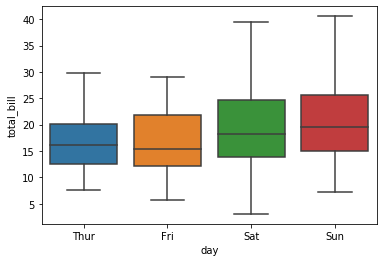

In [94]:
ax = sns.boxplot(x="day", y="total_bill", data=tips, showfliers=False)

In [95]:
import pandas as pd

In [97]:
attrData = pd.read_csv('AttrEmbData.csv')

In [98]:
lstmData = pd.read_csv('lstmData.csv')

In [100]:
attrData = attrData.dropna()

In [104]:
attrData

,EMB_SIZE,iter,macro_avg
0,16.0,0.0,0.715374
1,16.0,1.0,0.740902
2,16.0,2.0,0.759969
3,16.0,3.0,0.702024
4,16.0,4.0,0.637003
5,32.0,0.0,0.743918
6,32.0,1.0,0.736968
7,32.0,2.0,0.775750
8,32.0,3.0,0.778429
9,32.0,4.0,0.784937


In [109]:
lstmData

,NUERON_SIZE,iter,macro_avg
0,100,0,0.711519
1,100,1,0.689975
2,100,2,0.721637
3,100,3,0.625935
4,100,4,0.528379
5,200,0,0.740110
6,200,1,0.761090
7,200,2,0.648460
8,200,3,0.767098
9,200,4,0.701066


Text(0, 0.5, 'Macro F1')

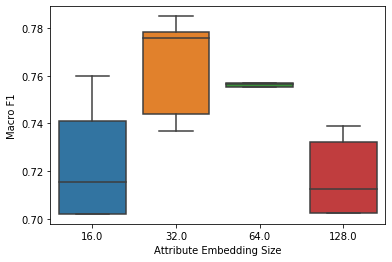

In [114]:
ax = sns.boxplot(x="EMB_SIZE", y="macro_avg", data=attrData, showfliers=False)
ax.set_xlabel("Attribute Embedding Size")
ax.set_ylabel("Macro F1")

In [115]:
fig = ax.get_figure()
fig.savefig("AttributeEmbeddingSize.png")

Text(0, 0.5, 'Macro F1')

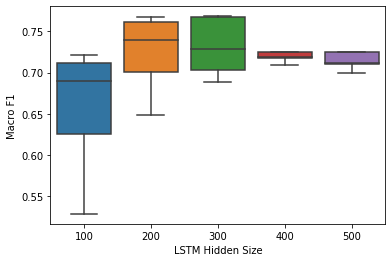

In [116]:
ax = sns.boxplot(x="NUERON_SIZE", y="macro_avg", data=lstmData, showfliers=False)
ax.set_xlabel("LSTM Hidden Size")
ax.set_ylabel("Macro F1")

In [117]:
fig = ax.get_figure()
fig.savefig("LSTMHiddenSize.png")

In [113]:
enDev_macro = pd.read_csv('en_dev_macro_sns.csv')

In [147]:
enDev_macro.loc[enDev_macro['Method'] == 'CRFSuite', 'Method'] = 'Autopager'

Text(0, 0.5, 'Macro F1')

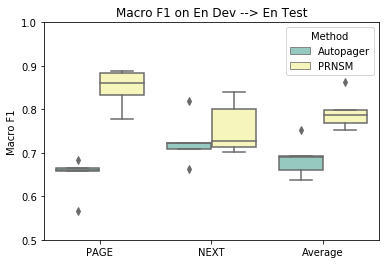

In [148]:
ax = sns.boxplot(x="Label", y="F1", hue="Method",
                 data=enDev_macro, palette="Set3")
ax.set_title("Macro F1 on En Dev --> En Test")
ax.set_ylim(0.5,1)
ax.set_xlabel("")
ax.set_ylabel("Macro F1")

In [139]:
enDev_micro = pd.read_csv('en_dev_micro_sns.csv')

In [144]:
enDev_micro.loc[enDev_micro['Method'] == 'CRFSuite', 'Method'] = 'Autopager'

Text(0, 0.5, 'Micro F1')

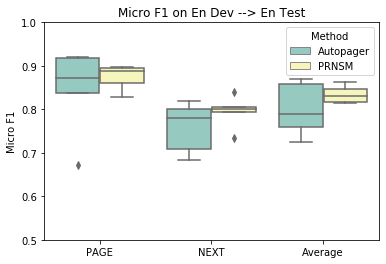

In [146]:
ax = sns.boxplot(x="Label", y="F1", hue="Method",
                 data=enDev_micro, palette="Set3")
ax.set_title("Micro F1 on En Dev --> En Test")
ax.set_ylim(0.5,1)
ax.set_xlabel("")
ax.set_ylabel("Micro F1")